Code taken from: https://github.com/pytorch/examples/tree/master/vae

In [94]:
! pip install sklearn

In [95]:
! pip install Cython

In [96]:
! git clone https://github.com/franciscovillaescusa/Pylians

fatal: destination path 'Pylians' already exists and is not an empty directory.


In [97]:
! cd Pylians/library/ python setup.py build

In [98]:
# from Pylians.library import Pk_library
# import Pylians as PKL
# from Pylians.library import Pk

In [99]:
%load_ext Cython

The Cython extension is already loaded. To reload it, use:
  %reload_ext Cython


In [100]:
%load_ext cythonmagic

The cythonmagic extension is already loaded. To reload it, use:
  %reload_ext cythonmagic


In [101]:
%% cython
import cython
from cython cimport floating

UsageError: Cell magic `%%` not found.


### Pk Library Functions

In [102]:
%load_ext Cython

The Cython extension is already loaded. To reload it, use:
  %reload_ext Cython


In [103]:
# %reload_ext Cython

In [104]:
# %%cython
# import numpy as np 
# import time,sys,os
# import pyfftw
# import scipy.integrate as si
# import numpy as np
# import cython
# from cython.parallel import prange
# from libc.math import sqrt,pow,sin,log10,abs
# from libc.stdlib import malloc, free
# from cpython import bool

In [105]:
# delta = np.load("my_HI_field.npy")

In [106]:
# delta /= np.mean(delta, dtype=np.float64);  delta -= 1.0

In [107]:
# delta = delta.astype(np.float32)

In [108]:
# BoxSize = 75.0/2048*128
# axis=0
# MAS="CIC"
# threads=1

In [109]:
# Pk_loss = Pk(delta, BoxSize, axis, MAS, threads)

In [110]:
# Pk = PKL.Pk(delta, BoxSize, axis, MAS, threads)

In [111]:
## after this go to Pylians/library, open a new notebook, 
## write: ! python setup.py build, run. 

In [112]:
## model imports
from __future__ import print_function
import argparse
import numpy as np
import os
import h5py
import pickle as pkl
import random
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
%matplotlib inline

## plot imports
import itertools
from matplotlib.ticker import MultipleLocator
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import colors
import h5py
import matplotlib as mpl

In [113]:
# ## Taken from Pk.py

# ################################## INPUT ######################################
# snapshot_fname = ['../ics',
#                   '../snapdir_000/snap_000',
#                   '../snapdir_001/snap_001',
#                   '../snapdir_002/snap_002',
#                   '../snapdir_003/snap_003']
                  
# dims           = 1024
# particle_type  = [1,2] #list with particle types. [-1] for total matter
# cpus           = 14
# ###############################################################################

# # do a loop over the different snapshots
# for snapshot in snapshot_fname:

#     ######## REAL-SPACE ########
#     do_RSD = False;  axis = 0 
#     PKL.Pk_Gadget(snapshot,dims,particle_type,do_RSD,axis,cpus)
                  

#     ###### REDSHIFT-SPACE ######
#     do_RSD = True
#     for axis in [0,1,2]:
#         PKL.Pk_Gadget(snapshot,dims,particle_type,do_RSD,axis,cpus)

### Section 0: Plotting

#### Cube Visualization - 3D

In [21]:
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    """Function for dividing/truncating cmaps"""
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

def visualize_cube(cube=None,      ## array name
             edge_dim=None,        ## edge dimension (128 for 128 x 128 x 128 cube)
             start_cube_index_x=0,
             start_cube_index_y=0,
             start_cube_index_z=0,
             fig_size=None,
             stdev_to_white=1,
             norm_multiply=600,
             color_map="Blues",
             lognormal=False):
    
    cube_size = edge_dim
    edge = np.array([*range(cube_size)])
    
    end_x = start_cube_index_x + cube_size
    end_y = start_cube_index_y + cube_size
    end_z = start_cube_index_z + cube_size
    
    fig = plt.figure(figsize=fig_size)
    ax = fig.add_subplot(111, projection='3d')
    
    data_value = cube[start_cube_index_x:end_x,
                      start_cube_index_y:end_y,
                      start_cube_index_z:end_z]
    
    x,y,z = edge,edge,edge
    product = [*itertools.product(x,y,z)]
    
    X = np.array([product[k][0] for k in [*range(len(product))]])
    Y = np.array([product[k][1] for k in [*range(len(product))]])
    Z = np.array([product[k][2] for k in [*range(len(product))]])
    
    ## map data to 1d array that corresponds to the axis values in the product array
    data_1dim = np.array([data_value[X[i]][Y[i]][Z[i]] for i in [*range(len(product))]])
    
    
#     initial_mean = np.mean(data_1dim) - stdev_to_white*np.std(data_1dim)
#     mask = data_1dim > initial_mean
#     mask = mask.astype(np.int)
    
#     data_1dim = np.multiply(mask,data_1dim)
    ## mask X,Y,Z to match the dimensions of the data
    X, Y, Z, data_1dim = [axis[np.where(data_1dim>0)] for axis in [X,Y,Z,data_1dim]]

    if lognormal == False:
        s = norm_multiply*data_1dim/np.linalg.norm(data_1dim)
    else:
        s = np.log(norm_multiply*data_1dim/np.linalg.norm(data_1dim))
    
    cmap=plt.get_cmap(color_map)
    new_cmap = truncate_colormap(cmap, 0.99, 1,n=10)
    
    ## IGNORE BELOW 3D PLOT FORMATTING 
    
    ## plot cube
    
    cube_definition = [(start_cube_index_x, start_cube_index_x, start_cube_index_x),
                      (start_cube_index_x, start_cube_index_x+edge_dim, start_cube_index_x),
                      (start_cube_index_x+edge_dim, start_cube_index_x, start_cube_index_x),
                      (start_cube_index_x, start_cube_index_x, start_cube_index_x+edge_dim)]
    
    cube_definition_array = [
        np.array(list(item))
        for item in cube_definition
    ]
    
    points = []
    points += cube_definition_array
    vectors = [
        cube_definition_array[1] - cube_definition_array[0],
        cube_definition_array[2] - cube_definition_array[0],
        cube_definition_array[3] - cube_definition_array[0]
    ]
    
    
    points += [cube_definition_array[0] + vectors[0] + vectors[1]]
    points += [cube_definition_array[0] + vectors[0] + vectors[2]]
    points += [cube_definition_array[0] + vectors[1] + vectors[2]]
    points += [cube_definition_array[0] + vectors[0] + vectors[1] + vectors[2]]

    points = np.array(points)

    edges = [
        [points[0], points[3], points[5], points[1]],
        [points[1], points[5], points[7], points[4]],
        [points[4], points[2], points[6], points[7]],
        [points[2], points[6], points[3], points[0]],
        [points[0], points[2], points[4], points[1]],
        [points[3], points[6], points[7], points[5]]
    ]
    
#     ax.fig.add_subplot(111, projection='3d')
    
    faces = Poly3DCollection(edges, linewidths=1, edgecolors='k',)
    faces.set_facecolor((0,0,1,0)) ## set transparent facecolor to the cube
    
    ax.add_collection3d(faces)
    
    ax.scatter(points[:,0], points[:,1], points[:,2], s=0)

    ax.set_aspect('equal')
    
    ax.xaxis.pane.fill = False
    ax.yaxis.pane.fill = False
    ax.zaxis.pane.fill = False
    
    ax.xaxis.pane.set_edgecolor('w')
    ax.yaxis.pane.set_edgecolor('w')
    ax.zaxis.pane.set_edgecolor('w')
    
    ax.xaxis.set_major_locator(MultipleLocator(edge_dim))
    ax.yaxis.set_major_locator(MultipleLocator(edge_dim))
    ax.zaxis.set_major_locator(MultipleLocator(edge_dim))
    
    ax.grid(False)
    
    ax.set_xlim3d(0,edge_dim)
    ax.set_ylim3d(0,edge_dim)
    ax.set_zlim3d(0,edge_dim)
#     ax.get_frame_on()
    
    ax.xaxis._axinfo['tick']['inward_factor'] = 0
    ax.xaxis._axinfo['tick']['outward_factor'] = 0
    ax.yaxis._axinfo['tick']['inward_factor'] = 0
    ax.yaxis._axinfo['tick']['outward_factor'] = 0
    ax.zaxis._axinfo['tick']['inward_factor'] = 0
    ax.zaxis._axinfo['tick']['outward_factor'] = 0
    
    ax.scatter(X, Y, Z,       ## axis vals
               c=data_1dim,   ## data, mapped to 1-dim
               cmap=new_cmap,
               s=s,           ## sizes - dims multiplied by each data point's magnitude
               alpha=0.7,
               edgecolors="face")
    
    
    
    plt.show()

#### Mass Histogram Function

In [22]:
def cube_mass_histogram(cube=None,      ## array name
             edge_dim=128,        ## edge dimension (128 for 128 x 128 x 128 cube)
             start_cube_index_x=0,
             start_cube_index_y=0,
             start_cube_index_z=0,
             fig_size=(20,10),
             stdev_to_white=1,
             norm_multiply=1,
             color_map="Blues",
             lognormal=False,
             hist_color="b",
                       hist_bins=300,
                       xlim=None):
    
    ## adjust cube and get 1d array of in-cube masses
    cube_size = edge_dim
    edge = np.array([*range(cube_size)])
    
    end_x = start_cube_index_x + cube_size
    end_y = start_cube_index_y + cube_size
    end_z = start_cube_index_z + cube_size
    
    data_value = cube[start_cube_index_x:end_x,
                      start_cube_index_y:end_y,
                      start_cube_index_z:end_z]
    
    x,y,z = edge,edge,edge
    product = [*itertools.product(x,y,z)]
    
    X = np.array([product[k][0] for k in [*range(len(product))]])
    Y = np.array([product[k][1] for k in [*range(len(product))]])
    Z = np.array([product[k][2] for k in [*range(len(product))]])
    
    ## map data to 1d array that corresponds to the axis values in the product array
    data_1dim = np.array([data_value[X[i]][Y[i]][Z[i]] for i in [*range(len(product))]])
    
    ## start plotting
    plt.figure(figsize=fig_size)
    plt.hist(data_1dim,bins=hist_bins,
            alpha=0.4)
    
    if xlim != None:
        plt.xlim(xlim[0],xlim[1])
    else:
        plt.xlim(None)
        
    plt.xlabel("Masses")
    plt.ylabel("Number of Samples That Correspond to the Mass")
    plt.title("Output Mass Histogram")
    plt.show()

### Arguments

In [23]:
# modify to accept hard coded arguments
# batch_size = 8
batch_size = 16
# batch_size = 32
epochs = 100
no_cuda = False
log_interval = 1

cuda = not no_cuda and torch.cuda.is_available()
# cuda = False

seed = 1
torch.manual_seed(seed)


# device = torch.device("cuda" if args.cuda else "cpu")
device = torch.device("cuda" if cuda else "cpu")

# kwargs = {'num_workers': 1, 'pin_memory': True} if args.cuda else {}
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}

### Section 1: Sampling & Preprocessing

In [24]:
scaler = StandardScaler()

In [25]:
def define_test(s_test, s_train):
    #2048/16=128
    m=8
    x=random.randint(0,m)*s_train
    y=random.randint(0,m)*s_train
    z=random.randint(0,m)*s_train
    #print(x,y,z)
    return {'x':[x,x+s_test], 'y':[y,y+s_test], 'z':[z,z+s_test]}

def check_coords(test_coords, train_coords):
    valid=True
    for i in ['x','y','z']:
        r=(max(test_coords[i][0], 
               train_coords[i][0]), 
           min(test_coords[i][1],
               train_coords[i][1]))
        if r[0]<=r[1]:
            valid=False
    return valid

In [26]:
def get_samples(s_sample, nsamples, redshift, test_coords):
    #n is size of minibatch, get valid samples (not intersecting with test_coords)
    sample_list=[]
    m=2048-128
    for n in range(nsamples):
        #print("Sample No = " + str(n + 1) + " / " + str(nsamples))
        sample_valid=False
        while sample_valid==False:
            x = random.randint(0,m)
            y = random.randint(0,m)
            z = random.randint(0,m)
            sample_coords = {'x':[x,x+s_sample], 
                             'y':[y,y+s_sample], 
                             'z':[z,z+s_sample]}
            
            sample_valid = check_coords(test_coords, 
                                        sample_coords)
        
        sample_list.append(sample_coords)
    
    print("Sampling finished.")
        
    #Load cube and get samples and convert them to np.arrays
    sample_array=[]
    datapath=''
    f = h5py.File(datapath+'fields_z='+redshift+'.hdf5', 'r')
    f=f['delta_HI']
#     f = scaler.fit_transform(np.array(f))
    
    # getting the max of the whole cube
    #print(f.shape)
    max_list = []
    for i in range(f.shape[0]):
        #print(np.max(f[i:i+1,:,:]))
        max_list.append(np.max(f[i:i+1,:,:]))
    max_cube = max(max_list)
    #f.close()
    
    print("Getting max value finished.")
    
    counter = 0
    for c in sample_list:
        print("Counter = " + str(counter + 1) + " / " + str(len(sample_list)))
        a = f[c['x'][0]:c['x'][1],
              c['y'][0]:c['y'][1],
              c['z'][0]:c['z'][1]]
        
        # a = np.array(a)
        ### datayi -1 1 arasina almayi dene
        
#         a = np.array(a) / max_cube
#         a = np.array([scaler.fit_transform(np.array(x)) for x in a])
#         a = (a - np.mean(a)*np.ones(a.shape))/np.std(a)
#         a = 
        a = np.array(a)/max_cube
        a = a + 1
        a = np.log(a)

        sample_array.append(a)

        counter = counter + 1
        
    f=0
    sample_array = np.array(sample_array)
    return sample_array

In [27]:
t_coords=define_test(1024,128)

In [28]:
class HydrogenDataset2(Dataset):
    """Hydrogen Dataset"""

    def __init__(self, h5_file, root_dir, s_test, s_train,
                 s_sample, nsamples, redshift):
        """
        Args:
            h5_file (string): name of the h5 file with 32 sampled cubes.
            root_dir (string): Directory with the .h5 file.
        """
        file_size = os.path.getsize(root_dir + h5_file) / 1e6 # in MBs
        print("The whole file size is " + str(int(file_size)) + " MBs")
        
        # self.subcubes = h5py.File('../data/sample_32.h5', 'r')
        self.subcubes = h5py.File(root_dir + h5_file, 'r')["delta_HI"]
        self.h5_file = h5_file
        self.root_dir = root_dir
        self.s_test = s_test
        self.s_train = s_train
        self.t_coords = define_test(self.s_test,
                                    self.s_train)
        self.s_sample = s_sample
        self.nsamples = nsamples
        self.redshift = redshift
        
        self.samples = get_samples(s_sample = self.s_sample,
                             nsamples = self.nsamples,
                             redshift = self.redshift,
                             test_coords = self.t_coords)

    def __len__(self):
        # Function called when len(self) is executed
        
        #print(len(self.subcubes))
#         return len(self.nsamples)
        return self.nsamples

    def __getitem__(self, idx):
        """
        This can be implemented in such a way that the whole h5 file read 
        using h5py.File() and get_sample() function is called to return
        a random subcube. This won't increase memory usage because the
        subcubes will be read in the same way and only the batch will
        be read into memory.
        
        Here we have implemented it so that it can be used with data
        generated by get_sample() function.
        
        The output of this function is one subcube with the dimensions
        specified by get_sample() implementation.
        """
        
        # default version -> error in training because of dimensions
#         sample = self.subcubes[idx]
        
        # reshaped version to add another dimension
#         sample = self.subcubes[idx].reshape((1,128,128,128))

        # On prince using get_samples()
#         print("nsamples = " + str(self.nsamples))
#         sample = get_samples(s_sample = self.s_sample,
#                              nsamples = self.nsamples,
#                              redshift = self.redshift,
#                              test_coords = self.t_coords)
    
        sample = self.samples[idx].reshape((1,128,128,128))
        
        # added division by 1e6 for exploding variance
        # and resulting in inf during reparametrization trick part
#         sample = sample/1e6
        
        ##3 normalize here 
        
#         sample = sample/1e6

        return sample

In [29]:
sampled_subcubes = HydrogenDataset2(h5_file="fields_z=1.0.hdf5",
                                    root_dir = "",
                                    s_test = 1024, 
                                    s_train = 128,
                                    s_sample = 128, 
                                    nsamples = 256, 
                                    redshift = "1.0")

The whole file size is 68719 MBs
Sampling finished.
Getting max value finished.
Counter = 1 / 256
Counter = 2 / 256
Counter = 3 / 256
Counter = 4 / 256
Counter = 5 / 256
Counter = 6 / 256
Counter = 7 / 256
Counter = 8 / 256
Counter = 9 / 256
Counter = 10 / 256
Counter = 11 / 256
Counter = 12 / 256
Counter = 13 / 256
Counter = 14 / 256
Counter = 15 / 256
Counter = 16 / 256
Counter = 17 / 256
Counter = 18 / 256
Counter = 19 / 256
Counter = 20 / 256
Counter = 21 / 256
Counter = 22 / 256
Counter = 23 / 256
Counter = 24 / 256
Counter = 25 / 256
Counter = 26 / 256
Counter = 27 / 256
Counter = 28 / 256
Counter = 29 / 256
Counter = 30 / 256
Counter = 31 / 256
Counter = 32 / 256
Counter = 33 / 256
Counter = 34 / 256
Counter = 35 / 256
Counter = 36 / 256
Counter = 37 / 256
Counter = 38 / 256
Counter = 39 / 256
Counter = 40 / 256
Counter = 41 / 256
Counter = 42 / 256
Counter = 43 / 256
Counter = 44 / 256
Counter = 45 / 256
Counter = 46 / 256
Counter = 47 / 256
Counter = 48 / 256
Counter = 49 / 25

In [114]:
type(sampled_subcubes)

__main__.HydrogenDataset2

In [31]:
np.mean(sampled_subcubes[1])

4.0915404e-07

In [32]:
np.std(sampled_subcubes[1])

0.00012126367

In [33]:
np.min(sampled_subcubes[1])

0.0

In [34]:
np.max(sampled_subcubes[1])

0.14112961

In [35]:
# np.save("my_HI_field.npy",sampled_subcubes[1])

In [36]:
# ! ls Pylians/library/Pk_library/

In [37]:
# import Pylians as PKL
# from Pylians.PKL import Pk

# ## example Pylians

# delta = np.load("my_HI_field.npy")
# delta /= np.mean(delta, dtype=np.float64)  
# delta -= 1.0
# delta = delta.astype(np.float32)

# BoxSize = 75.0/2048*128
# axis=0
# MAS="CIC"
# threads=1

# Pk = PKL.Pk(delta, BoxSize, axis, MAS, threads)

# np.savetxt("my_Pk.txt", np.transpose([Pk.k3D, Pk.Pk[:,0]]))

### Section 2: Model and Data Loaders

In [38]:
# Data Loaders
train_loader = DataLoader(
        dataset=sampled_subcubes,
        #batch_size=args.batch_size, 
        batch_size=batch_size,
        shuffle=True, 
        **kwargs)

test_loader = DataLoader(
        dataset=sampled_subcubes,
        #batch_size=args.batch_size, 
        batch_size=batch_size,
        shuffle=True, 
        **kwargs)

#### Model

In [123]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        """
        The Encoding Layers
        nn.Conv3d 
        nn.MaxPool3d 
        
        out_channels is the number of different filters we convolute 
        over the whole sampled subcube.
        
        So the first convolutional layer's in_channel should be 0 (?)
        
        In addition, the next layer's in_channel should be equal to
        the previous layer's out_channels (all examples show that
        this is the case)
        """
        
        # Convolutional Layer 1
        self.encode_conv1 = nn.Conv3d(in_channels=1, 
                                      out_channels=8, 
                                      kernel_size=(4,4,4), # == 4
                                      stride = (2,2,2), # == 2
                                      padding=(1,1,1)) # == 1
        nn.init.xavier_uniform_(self.encode_conv1.weight) #Xaviers Initialisation
        
        self.encode_relu1 = nn.ReLU()
        
        self.encode_maxpool1 = nn.MaxPool3d(kernel_size=(2, 2, 2), 
                                             stride=(2, 2, 2),
                                            return_indices = True)
        
        
        # Convolutional Layer 2
        self.encode_conv2 = nn.Conv3d(in_channels=8, 
                                      out_channels=16, 
                                      kernel_size=(4,4,4), # == 4 
                                      stride = (2,2,2),
                                      padding=(1,1,1))
        nn.init.xavier_uniform_(self.encode_conv2.weight) #Xaviers Initialisation
        
        self.encode_relu2 = nn.ReLU()
        self.encode_maxpool2 = nn.MaxPool3d(kernel_size=(2, 2, 2), 
                                             stride=(2, 2, 2),
                                            return_indices = True)

        # Convolutional Layer 3
        self.encode_conv3 = nn.Conv3d(in_channels=16, 
                                      out_channels=32, 
                                      kernel_size=(4,4,4), # == 4 
                                      stride = (2,2,2),
                                      padding=(1,1,1))
        self.encode_relu3 = nn.ReLU()
        nn.init.xavier_uniform_(self.encode_conv3.weight) #Xaviers Initialisation
        
#         self.encode_relu3 = nn.ReLU()
#         self.encode_maxpool3 = nn.MaxPool3d(kernel_size=(2, 2, 2), 
#                                              stride=(2, 2, 2),
#                                             return_indices = True)

        
        
        """
        Fully Connected Layers after 3D Convolutional Layers
        First FC layer's input should be equal to 
        last convolutional layer's output
        8192 = 8^3 * 16 
            8^3 = (output of 2nd convolutional layer)
            16 = number of out_channels
        """
        
        self.encode_fc1_linear = nn.Linear(in_features=2048, ## 2048
                                           out_features=128)
        
        ## RELU TO LEAKY RELU
#         self.encode_fc1_relu = nn.ReLU()
        self.encode_LeakyReLU_1 = nn.LeakyReLU(negative_slope=-0.015)
    
        self.encode_fc1_dropout = nn.Dropout(0.5)
        nn.init.xavier_uniform_(self.encode_fc1_linear.weight) #Xaviers Initialisation

        
#         self.encode_fc2 = nn.Sequential(
#             nn.Linear(in_features = 5096,
#                       out_features = 5096),
#             nn.ReLU(),
#             nn.Dropout(0.5))

        self.encode_fc2_linear = nn.Linear(in_features=128, 
                                           out_features=128)
    
        ## RELU TO LEAKY RELU
#         self.encode_fc2_relu = nn.ReLU()
        self.encode_LeakyReLU_2 = nn.LeakyReLU(negative_slope=-0.15)
    
        self.encode_fc2_dropout = nn.Dropout(0.5)
        nn.init.xavier_uniform_(self.encode_fc2_linear.weight) #Xaviers Initialisation
        
        """
        The last fully connected layer's output is the dimensions
        of the embeddings?
        
        PyTorch VAE example uses output of 20 dimensions for mu &
        logvariance
        """
#         self.encode_fc31 = nn.Sequential(
#             nn.Linear(in_features=5096,
#                       out_features=20))
        
        self.encode_fc31_linear = nn.Linear(in_features=128, 
                                           out_features=16) ### burasi
        
        
        ## RELU TO LEAKY RELU
#         self.encode_fc31_relu = nn.ReLU()
        self.encode_LeakyReLU_31 = nn.LeakyReLU(negative_slope=-0.000015)
        
        self.encode_fc31_dropout = nn.Dropout(0.5)
        nn.init.xavier_uniform_(self.encode_fc31_linear.weight) #Xaviers Initialisation

        
#         self.encode_fc32 = nn.Sequential(
#             nn.Linear(in_features=5096,
#                       out_features=20))
        ## out features daki 10 degisebilir - yukaridaki ile ayni olmali 
        self.encode_fc32_linear = nn.Linear(in_features=128, 
                                           out_features=16)
        
        ## RELU TO LEAKY RELU
#         self.encode_fc32_relu = nn.ReLU()
        self.encode_LeakyReLU_32 = nn.LeakyReLU(negative_slope=-0.000015)
        
        self.encode_fc32_dropout = nn.Dropout(0.5)
        nn.init.xavier_uniform_(self.encode_fc32_linear.weight) #Xaviers Initialisation

        
        
        """
        The Decoding Layers
        nn.Conv3d -> nn.ConvTranspose3d
        nn.MaxPool3d -> nn.MaxUnpool3d
        """
        ## buradaki 10 degisebilir - latent gibi 
#         self.decode_fc1 = nn.Sequential(
#             nn.Linear(in_features=10,
#                       out_features=128))

        self.decode_fc1 = nn.Sequential(
            nn.Linear(in_features=16,
                      out_features=128))
        
        self.decode_fc2 = nn.Sequential(
            nn.Linear(in_features=128, 
                      out_features=128), 
            nn.ReLU(),
            nn.Dropout(0.5))
        #init.xavier_normal(self.fc1.state_dict()['weight'])
        
        self.decode_fc3 = nn.Sequential(
            nn.Linear(in_features = 128,
                      out_features = 2048),
            nn.ReLU(),
            nn.Dropout(0.5))
        #init.xavier_normal(self.fc2.state_dict()['weight'])
        
        
        self.decode_conv1 = nn.ConvTranspose3d(in_channels=32, 
                                              out_channels=16, 
                                              kernel_size=(4,4,4),
                                              stride = (2,2,2),
                                              padding=(1,1,1))
        self.decode_relu1 = nn.ReLU()
        self.decode_maxunpool1 = nn.MaxUnpool3d(kernel_size=(2, 2, 2), 
                                                     stride=(2, 2, 2))
        #init.xavier_normal(self.group1.state_dict()['weight'])
        
        self.decode_conv2 = nn.ConvTranspose3d(in_channels=16, 
                                              out_channels=8, 
                                              kernel_size=(4,4,4),
                                              stride = (2,2,2),
                                              padding=(1,1,1))
        self.decode_relu2 = nn.ReLU()
        self.decode_maxunpool2 = nn.MaxUnpool3d(kernel_size=(2, 2, 2), 
                                                     stride=(2, 2, 2))
        
        self.decode_conv3 = nn.ConvTranspose3d(in_channels=8, 
                                              out_channels=1, 
                                              kernel_size=(4,4,4),
                                              stride = (2,2,2),
                                              padding=(1,1,1))
        self.decode_relu3 = nn.ReLU()
        self.decode_maxunpool3 = nn.MaxUnpool3d(kernel_size=(2, 2, 2), 
                                                     stride=(2, 2, 2))
        
        self.decode_LeakyRelu1 = nn.LeakyReLU(negative_slope=-0.15)
        self.decode_LeakyRelu2 = nn.LeakyReLU(negative_slope=-0.15)
        self.decode_LeakyRelu3 = nn.LeakyReLU(negative_slope=-0.015)
        
        ## initialize out lists 
        self.first_decode_out_sum = []
        self.conv_1_out_sum = []
        self.relu_1_out_sum = []
        self.max_unpool_1_out_sum = []
        self.conv_2_out_sum = []
        self.relu_2_out_sum = []
        self.max_unpool_2_out_sum = []
        self.conv_3_out_sum = []
        self.relu_3_out_sum = []
        
        
    # Encoding part of VAE
    def encode(self, x):
#         h1 = F.relu(self.fc1(x))
#         return self.fc21(h1), self.fc22(h1)

        print("Starting Encoding")
#         print("----------------------------")
        
        out = self.encode_conv1(x)
#         print("First Conv output shape = " + str(out.shape))
        #print(out.shape)
        out = self.encode_relu1(out)
#         print("First ReLU Layer output shape = " + str(out.shape))
        size1 = out.size()
        out, ind1 = self.encode_maxpool1(out)
#         print("First MaxPooling output shape = " + str(out.shape))
#         print("Ind1 shape = " + str(ind1.shape))
#         #print("Size1 = " + str(size1))
#         print("----------------------------")
        
        out = self.encode_conv2(out)
#         print("Second Conv output shape = " + str(out.shape))
        out = self.encode_relu2(out)
#         print("Second ReLU Layer output shape = " + str(out.shape))
        size2 = out.size()
        out, ind2 = self.encode_maxpool2(out)
#         print("Second MaxPooling output shape = " + str(out.shape))
#         print("Ind2 shape = " + str(ind2.shape))
        #print("Size2 = " + str(size2))
#          print("----------------------------")
        
        out = self.encode_conv3(out)
#         print("Last Conv output shape = " + str(out.shape))
        out = self.encode_relu3(out)
#         print("Last ReLU output shape = " + str(out.shape))
        size3 = out.size()
#         out, ind3 = self.encode_maxpool3(out)
#         print("Last Conv Layer output shape = " + str(out.shape))
#         print("Ind3 shape = " + str(ind3.shape))
        #print("Size3 = " + str(size3))
#         print("----------------------------")

        """
        From here on, the convolutional layers' output is flattened
        into a rank 1 tensor of size x & put into a fully connected 
        network to output ??????
        
        https://github.com/pytorch/examples/blob/master/vae/main.py
        PyTorch's own example uses just 2 fully-connected layers
        to output mu and logvar predictions, below we use 3.
        """
        #out = out.view(out.size(0), -1)
        
        
        # batch_size = 1 - WORKS
#         out = out.view(1, -1)
        # batch_size != 1
        out = out.view(batch_size, -1)
        print(out.shape)
        
#         print("Last Conv Layer output shape after reshaping \n \
#                 (Input to first FC layer) = " + str(out.shape))
        
#         out = self.encode_fc1(out)
    
        out = self.encode_fc1_linear(out)
        
        ## RELU TO LEAKY RELU
#         out = self.encode_fc1_relu(out)
        out = self.encode_LeakyReLU_1(out)
        
        out = self.encode_fc1_dropout(out)
        
#         out = self.encode_fc2(out)

        out = self.encode_fc2_linear(out)
    
        ## RELU TO LEAKY RELU
#         out = self.encode_fc2_relu(out)
        out = self.encode_LeakyReLU_2(out)
        out = self.encode_fc2_dropout(out)
        
        
#         out_mu = self.encode_fc31(out)
        
        out_mu = self.encode_fc31_linear(out)
        
        ## RELU TO LEAKY RELU
#         out_mu = self.encode_fc31_relu(out_mu)
        out_mu = self.encode_LeakyReLU_31(out_mu)
        out_mu = self.encode_fc31_dropout(out_mu)
        
#         out_logvar = self.encode_fc32(out)

        out_logvar = self.encode_fc32_linear(out)
    
        ## RELU TO LEAKY RELU
#         out_logvar = self.encode_fc32_relu(out_logvar)
        out_logvar = self.encode_LeakyReLU_32(out_logvar)
        
        out_logvar = self.encode_fc32_dropout(out_logvar)
        
        print("Encode - Forward Pass Finished")
        print(out_mu.shape)
        print(out_logvar.shape)
#         print("----------------------------")
        
#         return out_mu, out_logvar, [ind1,ind2,ind3], [size1,size2,size3]
        return out_mu, out_logvar, [ind1,ind2], [size1,size2]
    

    # Reparametrization Trick
    def reparameterize(self, mu, logvar):
        """
        torch.exp = returns a new tensor with the exponential of 
                    the elements of input
        rand_like = returns a tensor with the same size as input
                    that is filled with random numbers from a normal
                    distribution with mean 0 and variance 1
        
        """
#         print("Reparametrization...")
#         print("logvar (in reparametrization) = \n" + str(logvar))
#         print("logvar (in reparametrization) = \n" + str(logvar*1e6))
#         print("mu * 1e6 (in reparametrization) = \n" + str(mu))
#         print("mu * 1e6 (in reparametrization) = \n" + str(mu*1e6))
        
        std = torch.exp(0.5*logvar)
#         std = logvar.mul(0.5).exp_()
        eps = torch.randn_like(std)
        
#         print("0.5*logvar (in reparametrization) = \n" + str(0.5*logvar))
#         print("std (in reparametrization) = \n" + str(std))
#         print("eps (in reparametrization) = \n" + str(eps))
         
#         print("eps.mul(std).add_(mu) \n \
#                 [This is the output from reparameterize()] =\
#                     \n" + str(eps.mul(std).add_(mu)))
        
        return eps.mul(std).add_(mu)
    
    
    # Decoding part of VAE
    def decode(self, z, indices_list, size_list):
        

        
#         h3 = F.relu(self.fc3(z))
#         return torch.sigmoid(self.fc4(h3))
#         print("----------------------------")
        print("Starting Decoding")
#         print("z shape = " + str(z.shape))
        
        ### buradaki butun outlarin sumlarina bak 
        out = self.decode_fc1(z)
#         print("1st FC output shape = " + str(out.shape))
        out = self.decode_fc2(out)
#         print("2nd FC output shape = " + str(out.shape))
        out = self.decode_fc3(out)
#         print("Last FC output shape = " + str(out.shape))
        
        # batch_size = 1 - WORKS
#         out = out.view(1, 32, 4, 4, 4)
        # batch_size != 1 
        out = out.view(batch_size, 32, 4, 4, 4)
        self.first_decode_out_sum.append(np.sum(out.cpu().detach().numpy()))
        print ("FIRST DECODE OUT SUM = "+ str(np.sum(out.cpu().detach().numpy())))
        
#         print("First Deconv input shape = " + str(out.shape))
#         print("After last convolution (encoding stage) output shape = " +\
#                   str(indices_list[1].shape))
        out = self.decode_conv1(out)
        self.conv_1_out_sum.append(np.sum(out.cpu().detach().numpy()))
        print ("CONV 1 OUT SUM = "+ str(np.sum(out.cpu().detach().numpy())))
#         print("First Deconv output shape = " + str(out.shape))
        
        ## RELU TO LEAKY RELU
        out = self.decode_relu1(out)
        self.relu_1_out_sum.append(np.sum(out.cpu().detach().numpy()))
#         out = self.decode_LeakyRelu1(out)
        print ("RELU 1 OUT SUM = "+ str(np.sum(out.cpu().detach().numpy())))
#         print("First ReLU output shape = " + str(out.shape))
        # maxunpooling needs indices

#         out = self.decode_maxunpool1(out,
#                              indices = indices_list[1])
        out = self.decode_maxunpool1(out,
                                     indices = indices_list[1],
                                     output_size = size_list[1])
    
        self.max_unpool_1_out_sum.append(np.sum(out.cpu().detach().numpy()))
        print ("MAX UNPOOL 1 OUT SUM = "+ str(np.sum(out.cpu().detach().numpy())))
#         print("2nd MaxUnpool ouput shape = " + str(out.shape))
        
        out = self.decode_conv2(out)
        self.conv_2_out_sum.append(np.sum(out.cpu().detach().numpy()))
        print ("CONV 2 OUT SUM = "+ str(np.sum(out.cpu().detach().numpy())))
#         print("2nd Deconv output shape = " + str(out.shape))

        ## RELU TO LEAKY RELU
        out = self.decode_relu2(out)
        self.relu_2_out_sum.append(np.sum(out.cpu().detach().numpy()))
#         out = self.decode_LeakyRelu2(out)
        print ("RELU 2 OUT SUM = "+ str(np.sum(out.cpu().detach().numpy())))
#         print("2nd ReLU output shape = " + str(out.shape))
        out = self.decode_maxunpool2(out,
                     indices = indices_list[0])
        self.max_unpool_2_out_sum.append(np.sum(out.cpu().detach().numpy()))
        print ("MAX UNPOOL 2 OUT SUM = "+ str(np.sum(out.cpu().detach().numpy())))
#         out = self.decode_maxunpool2(out,
#                                      indices= indices_list[1],
#                                      output_size = size_list[1])
        
        out = self.decode_conv3(out)
        self.conv_3_out_sum.append(np.sum(out.cpu().detach().numpy()))
        print ("CONV 3 OUT SUM = "+ str(np.sum(out.cpu().detach().numpy())))
        
        ## RELU TO LEAKY RELU
        out = self.decode_relu3(out)
        self.relu_3_out_sum.append(np.sum(out.cpu().detach().numpy()))
#         out = self.decode_LeakyRelu3(out)
        print ("RELU 3 OUT SUM = "+ str(np.sum(out.cpu().detach().numpy())))
#         print("Last ReLU output shape = " + str(out.shape))
#         out = self.decode_maxunpool1(out,
#                              indices = indices_list[0])
        # there is no last maxunpool in https://github.com/pgtgrly/Convolution-Deconvolution-Network-Pytorch/blob/master/Neural_Network_Class.py
#         out = self.decode_maxunpool2(out,
#                                      indices= indices_list[0],
#                                      output_size = size_list[0])
        
        return out, self.first_decode_out_sum, self.conv_1_out_sum, self.relu_1_out_sum, \
                    self.max_unpool_1_out_sum,\
                    self.conv_2_out_sum, self.relu_2_out_sum, self.max_unpool_2_out_sum, \
                    self.conv_3_out_sum, \
                    self.relu_3_out_sum
    

    # Forward Pass
    def forward(self, x):
#         mu, logvar = self.encode(x.view(-1, 784))
        mu, logvar, indices_list, size_list = self.encode(x)
#         print("logvar (after encoding) = \n" + str(logvar))
#         print("mu (after encoding) = \n" + str(mu))
        
        z = self.reparameterize(mu, logvar)
#         print("z = ")
#         print(z)
        reconstructed_x, first_decode_out_sum, conv_1_out_sum, relu_1_out_sum, max_unpool_1_out_sum,\
                    conv_2_out_sum, relu_2_out_sum, max_unpool_2_out_sum, conv_3_out_sum, \
                    relu_3_out_sum = self.decode(z, indices_list, size_list)
    
        return reconstructed_x, first_decode_out_sum, conv_1_out_sum, relu_1_out_sum, max_unpool_1_out_sum,\
                    conv_2_out_sum, relu_2_out_sum, max_unpool_2_out_sum, conv_3_out_sum, \
                    relu_3_out_sum , mu, logvar
       

In [124]:
model = VAE().to(device)

In [125]:
optimizer = optim.Adam(model.parameters(), 
                       lr=0.001,
                      weight_decay=0.01) ## change learning rate

#### Loss Function

In [126]:
# Reconstruction + KL divergence losses summed over all elements and batch
def loss_function(recon_x, x, mu, logvar):
#     print("--------------------------------------")
#     print("Calculating Loss...")
#     print("recon_x shape = " + str(recon_x.shape))
    
#     BCE = F.binary_cross_entropy(recon_x, 
#                                  x.view(-1, 1, 128, 128, 128), 
#                                  reduction='sum')
#     print("BCE Loss = " + str(BCE))


    """
    https://towardsdatascience.com/teaching-a-variational-autoencoder-vae-to-draw-mnist-characters-978675c95776
    This article is about reconstructing MNIST dataset (2D images with 1 channels)
    And it uses squared difference for the reconstruction loss, thus
    it is safe to say that for 3D reconstruction we might use the same thing too.
    
    But the MSE loss seems to be around 1e20 magnitude, thus suggesting some
    bug might exist in it.
    The multplication by 1e12 is because of the 1e6 division when loading
    the dataset
    """
    MSE = F.mse_loss(recon_x, 
                     x.view(-1, 1, 128, 128, 128), 
                     reduction='sum')
    
    print("MSE Loss = " + str(MSE))

    """
    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    
    # https://vxlabs.com/2017/12/08/variational-autoencoder-in-pytorch-commented-and-annotated/
    # normalises the KLD loss by batch_size
    """
#     print("logvar (KLD Loss) = \n" + str(logvar))
#     print("mu (KLD Loss) = \n" + str(mu))
#     print("logvar.exp() (KLD Loss) = \n" + str(logvar.exp()))
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    KLD = KLD / float(batch_size)
    print("KLD Loss = " + str(KLD))

#     return MSE
#     return BCE
#     return BCE + KLD
    return MSE + KLD

#### Train and Test Epochs

In [131]:
decoder_sum_lists = {}

for out_plot in ["first_decode_out_sum", "conv_1_out_sum", "relu_1_out_sum", "max_unpool_1_out_sum",
            "conv_2_out_sum", "relu_2_out_sum", "max_unpool_2_out_sum", "conv_3_out_sum", \
            "relu_3_out_sum"]:

    decoder_sum_lists[out_plot] = []

def train(epoch):
    model.train()
    train_loss = 0
#     for batch_idx, (data, _) in enumerate(train_loader):
    for batch_idx, data in enumerate(train_loader):
#         print(batch_idx)
#         print(data)
        
        #print("Batch size = " + str(data.shape))
        
        data = data.to(device)
        print("Data transfer to device completed.")
        
        optimizer.zero_grad()
        
        recon_batch, first_decode_out_sum, conv_1_out_sum, relu_1_out_sum, max_unpool_1_out_sum,\
                    conv_2_out_sum, relu_2_out_sum, max_unpool_2_out_sum, conv_3_out_sum, \
                    relu_3_out_sum , mu, logvar = model(data)
        
#         decoder_sum_lists["first_decode_out_sum"].append(first_decode_out_sum)
#         decoder_sum_lists["conv_1_out_sum"].append(conv_1_out_sum)
#         decoder_sum_lists["relu_1_out_sum"].append(relu_1_out_sum)
#         decoder_sum_lists["max_unpool_1_out_sum"].append(max_unpool_1_out_sum)
#         decoder_sum_lists["conv_2_out_sum"].append(conv_2_out_sum)
#         decoder_sum_lists["relu_2_out_sum"].append(relu_2_out_sum)
#         decoder_sum_lists["max_unpool_2_out_sum"].append(max_unpool_2_out_sum)
#         decoder_sum_lists["conv_3_out_sum"].append(conv_3_out_sum)
#         decoder_sum_lists["relu_3_out_sum"].append(relu_3_out_sum)
            
        # Plotting Input Cube
        print("data shape = " + str(data.view(-1,128,128,128).shape))
        print("data shape = " + str(data[0].cpu().view(128,128,128).numpy().shape))
        
#         if epoch % (epochs / 20) == 0 and batch_idx == 1:
            
            ## plot first_decoder out
        print ("Plotting the first decoder output sum")
        print ("first decoder out sum = "+str(first_decode_out_sum))
        plt.figure(figsize=(20,10))
        plt.plot(first_decode_out_sum, linewidth=3.5, alpha=0.6, 
                 color="b")
        plt.rcParams["font.size"] = 16
        plt.xlabel("Batch Iterations")
        plt.title("First Decoder Output Sum")
#             plt.xticks = range(epochs)
#             plt.grid()
        plt.show()

        ## plot first convolution out
        print ("Plotting the first convolution output sum")
        plt.figure(figsize=(20,10))
        plt.plot(conv_1_out_sum, linewidth=3.5, alpha=0.6, 
                 color="r")
        plt.rcParams["font.size"] = 16
        plt.xlabel("Batch Iterations")
        plt.title("First Convolution Output Sum")
#             plt.xticks = range(epochs)
#             plt.grid()
        plt.show()

        ## plot first relu out
        print ("Plotting the first relu output sum")
        plt.figure(figsize=(20,10))
        plt.plot(relu_1_out_sum, linewidth=3.5, alpha=0.6, 
                 color="m")
        plt.rcParams["font.size"] = 16
        plt.xlabel("Batch Iterations")
        plt.title("First ReLU Output Sum")
#             plt.xticks = range(epochs)
#             plt.grid()
        plt.show()

        ## plot first max unpool out
        print ("Plotting the first max unpool output sum")
        plt.figure(figsize=(20,10))
        plt.plot(max_unpool_1_out_sum, linewidth=3.5, alpha=0.6, 
                 color="darkorange")
        plt.rcParams["font.size"] = 16
        plt.xlabel("Batch Iterations")
        plt.title("First Max Unpool Output Sum")
#             plt.xticks = range(epochs)
#             plt.grid()
        plt.show()

        ## plot second convolution out
        print ("Plotting the second convolution output sum")
        plt.figure(figsize=(20,10))
        plt.plot(conv_2_out_sum, linewidth=3.5, alpha=0.6, 
                 color="r")
        plt.rcParams["font.size"] = 16
        plt.xlabel("Batch Iterations")
        plt.title("Second Convolution Output Sum")
#             plt.xticks = range(epochs)
#             plt.grid()
        plt.show()

        ## plot second relu out
        print ("Plotting the second relu output sum")
        plt.figure(figsize=(20,10))
        plt.plot(relu_2_out_sum, linewidth=3.5, alpha=0.6, 
                 color="m")
        plt.rcParams["font.size"] = 16
        plt.xlabel("Batch Iterations")
        plt.title("Second ReLU Output Sum")
#             plt.xticks = range(epochs)
#             plt.grid()
        plt.show()

        ## plot second max unpool out
        print ("Plotting the second max unpool output sum")
        plt.figure(figsize=(20,10))
        plt.plot(max_unpool_2_out_sum, linewidth=3.5,
                 alpha=0.6, 
                 color="darkorange")
        plt.rcParams["font.size"] = 16
        plt.xlabel("Batch Iterations")
        plt.title("Second Max Unpool Output Sum")
#             plt.xticks = range(epochs)
#             plt.grid()
        plt.show()

        ## plot third convolution out
        print ("Plotting the third convolution output sum")
        plt.figure(figsize=(20,10))
        plt.plot(conv_3_out_sum, linewidth=3.5, alpha=0.6,
                 color="r")
        plt.rcParams["font.size"] = 16
        plt.xlabel("Batch Iterations")
        plt.title("Third Convolution Output Sum")
#             plt.xticks = range(epochs)
#             plt.grid()
        plt.show()

        ## plot third relu out
        print ("Plotting the third relu output sum")
        plt.figure(figsize=(20,10))
        plt.plot(relu_3_out_sum, linewidth=3.5, alpha=0.6, 
                 color="m")
        plt.rcParams["font.size"] = 16
        plt.xlabel("Batch Iterations")
        plt.title("Third ReLU Output Sum")
#             plt.xticks = range(epochs)
#             plt.grid()
        plt.show()


        if epoch % (epochs / 20) == 0 and batch_idx == 0:
            print ("Visualizing original cube")
            visualize_cube(cube=data[0].cpu().view(128,128,128).detach().numpy(),
                           edge_dim = 128,
                           start_cube_index_x = 0,
                          start_cube_index_y = 0,
                          start_cube_index_z = 0,
                          fig_size = (20,20),
                          stdev_to_white = -2,
                          norm_multiply = 1000,
                          color_map = "Blues",
                          lognormal = False)
            
            print ("Plotting cube histogram")
            plt.figure(figsize=(20,10))
            plt.hist(data[0].cpu().view(128,128,128).detach().numpy().ravel(),color="b",alpha=0.3,
                    bins=int(50000),label="original",edgecolor="k")
#             cube_mass_histogram(data[0].cpu().view(128,128,128).detach().numpy())
            plt.hist(recon_batch[0].cpu().view(128,128,128).detach().numpy().ravel(),color="m",
                    alpha=0.3,bins=int(5000),label="reconstructed",edgecolor="k")
            plt.xlim(0,2e-6)
            plt.rcParams["font.size"] = 16
            plt.legend()
#             print ("Zooming In")
#             cube_mass_histogram(data[0].cpu().view(128,128,128).detach().numpy()
#                                 ,xlim=(0,1e-6))
            print ("Original Cube Mass Sum: "\
                   + str(np.sum(data[0].cpu().view(128,128,128).detach().numpy())))
        
        # Plotting Reconstructed Cube
        print("reconstructed cube = " + \
              str(recon_batch.view(-1,128,128,128).shape))
        print("reconstructed cube = " + \
              str(recon_batch[0].view(128,128,128).shape))


        if epoch % (epochs / 20) == 0 and batch_idx == 0:
            print ("Visualizing reconstructed cube")
            visualize_cube(cube=recon_batch[0].cpu().view(128,128,128).detach().numpy(),
                           edge_dim = 128,
                           start_cube_index_x = 0,
                          start_cube_index_y = 0,
                          start_cube_index_z = 0,
                          fig_size = (20,20),
                          stdev_to_white = -2,
                          norm_multiply = 1000,
                          color_map = "Blues",
                          lognormal = False)
            
            print ("Plotting reconstructed sample histogram")
            plt.figure(figsize=(20,10))
            plt.hist(data[0].cpu().view(128,128,128).detach().numpy().ravel(),color="b",alpha=0.3,
                    bins=int(50000),label="original",edgecolor="k")
#             cube_mass_histogram(data[0].cpu().view(128,128,128).detach().numpy())
            plt.hist(recon_batch[0].cpu().view(128,128,128).detach().numpy().ravel(),color="m",
                    alpha=0.3,bins=int(5000),label="reconstructed",edgecolor="k")
            plt.xlim(0,2e-6)
            plt.rcParams["font.size"] = 16
            plt.legend()
#             cube_mass_histogram(cube=recon_batch[0].cpu().view(128,128,128).detach().numpy())
#             print ("Zooming In")
#             cube_mass_histogram(recon_batch[0].cpu().view(128,128,128).detach().numpy()
#                                 ,xlim=(0,1e-6))
            
            print ("Output mass sum (reconstructed batch): "\
                   + str(np.sum(recon_batch[0].cpu().view(128,128,128).detach().numpy())))
        
        
        loss = loss_function(recon_batch, data, mu, logvar)
        
        loss.backward()
        train_loss += loss.item()
        
        loss_history.append(loss.item())
        
        optimizer.step()
        # if batch_idx % args.log_interval == 0:
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.12f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.item() / len(data)))

    print('====> Epoch: {} Average loss: {:.12f}'.format(
          epoch, train_loss / len(train_loader.dataset)))

In [132]:
def test(epoch):
    model.eval()
    test_loss = 0
    with torch.no_grad():
#         for i, (data, _) in enumerate(test_loader):
        for k, data in enumerate(test_loader):
            print("k = " + str(k))
        
            data = data.to(device)
            
            # Plotting Input Cube
            print("data shape = " + str(data.view(-1,128,128,128).shape))
            print("data shape = " + str(data[0].view(128,128,128).shape))
  
            if epoch % (epochs / 4) == 0 and k == 0:
                visualize_cube(cube=data[0].view(128,128,128),
                               edge_dim = 128,
                               start_cube_index_x = 0,
                              start_cube_index_y = 0,
                              start_cube_index_z = 0,
                              fig_size = (20,20),
                              stdev_to_white = 1,
                              norm_multiply = 1000,
                              color_map = "Blues",
                              lognormal = False)
            
#                 plt.figure(figsize=(20,20))
#                 plt.hist(data[0].cpu().view(128,128,128).detach().numpy(),color="m")
                print ("Plotting original cube histogram")
                cube_mass_histogram(data[0].cpu().view(128,128,128).detach().numpy())
#                 plt.hist(recon_batch[0].cpu().view(128,128,128).detach().numpy().ravel(),color="b")
#                 plt.legend()
            
            recon_batch, mu, logvar = model(data)
            
            # Plotting Reconstructed Cube
            print("reconstructed cube = " + \
                  str(recon_batch.view(-1,128,128,128).shape))
            print("reconstructed cube = " + \
                  str(recon_batch[0].view(128,128,128).shape))
            
            if epoch % (epochs / 4) == 0 and k == 0:
                visualize_cube(cube=recon_batch[0].view(128,128,128),
                               edge_dim = 128,
                               start_cube_index_x = 0,
                              start_cube_index_y = 0,
                              start_cube_index_z = 0,
                              fig_size = (20,20),
                              stdev_to_white = 1,
                              norm_multiply = 1000,
                              color_map = "Blues",
                              lognormal = False)
                
#                 plt.figure(figsize=(20,20))
#                 plt.hist(data[0].cpu().view(128,128,128).detach().numpy(),color="m")
                print ("Plotting reconstructed sample histogram")
                cube_mass_histogram(data[0].cpu().view(128,128,128).detach().numpy())
#                 plt.hist(recon_batch[0].cpu().view(128,128,128).detach().numpy().ravel(),color="b")
#                 plt.legend()
            
            test_loss += loss_function(recon_batch, data, mu, logvar).item()

#             if k == 0:
#                 n = min(data.size(0), 8)
#                 comparison = torch.cat([data[:n], 
#                                         recon_batch.view(batch_size, 1, 128, 128, 128)[:n]])
                                      #recon_batch.view(args.batch_size, 1, 28, 28)[:n]])
#                                         recon_batch.view(batch_size, 1, 28, 28)[:n]])
#                 save_image(comparison.cpu(),
#                          'results/reconstruction_' + str(epoch) + '.png', nrow=n)

    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.12f}'.format(test_loss))

### Start Training

Epoch = 1 / 100
Data transfer to device completed.
Starting Encoding
torch.Size([16, 2048])
Encode - Forward Pass Finished
torch.Size([16, 16])
torch.Size([16, 16])
Starting Decoding
FIRST DECODE OUT SUM = 23537.137
CONV 1 OUT SUM = 343867.12
RELU 1 OUT SUM = 343867.12
MAX UNPOOL 1 OUT SUM = 343867.12
CONV 2 OUT SUM = 3158291.2
RELU 2 OUT SUM = 3159684.0
MAX UNPOOL 2 OUT SUM = 3159684.8
CONV 3 OUT SUM = -5306956.0
RELU 3 OUT SUM = 5337.1265
data shape = torch.Size([16, 128, 128, 128])
data shape = (128, 128, 128)
Plotting the first decoder output sum
first decoder out sum = [2896.9578, 2894.755, 3238.6477, 3808.3076, 3741.1228, 4201.9287, 4773.0415, 5594.073, 6045.5674, 6948.961, 14237.286, 22334.652, 15180.516, 17629.209, 21233.797, 16922.594, 14840.281, 14490.682, 15087.692, 15661.113, 17474.27, 15106.627, 16474.158, 18892.68, 18719.54, 20596.926, 20129.008, 19567.004, 23979.137, 22001.125, 21199.014, 26055.531, 22023.223, 26002.963, 23571.432, 25816.768, 26200.242, 29389.098, 25502.

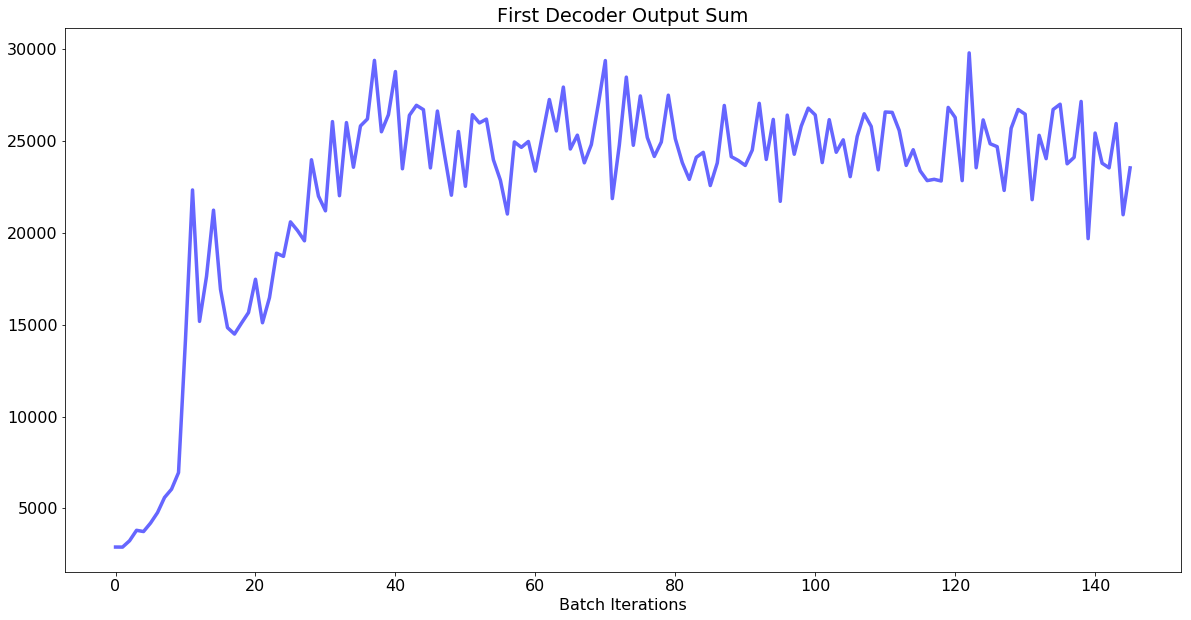

Plotting the first convolution output sum


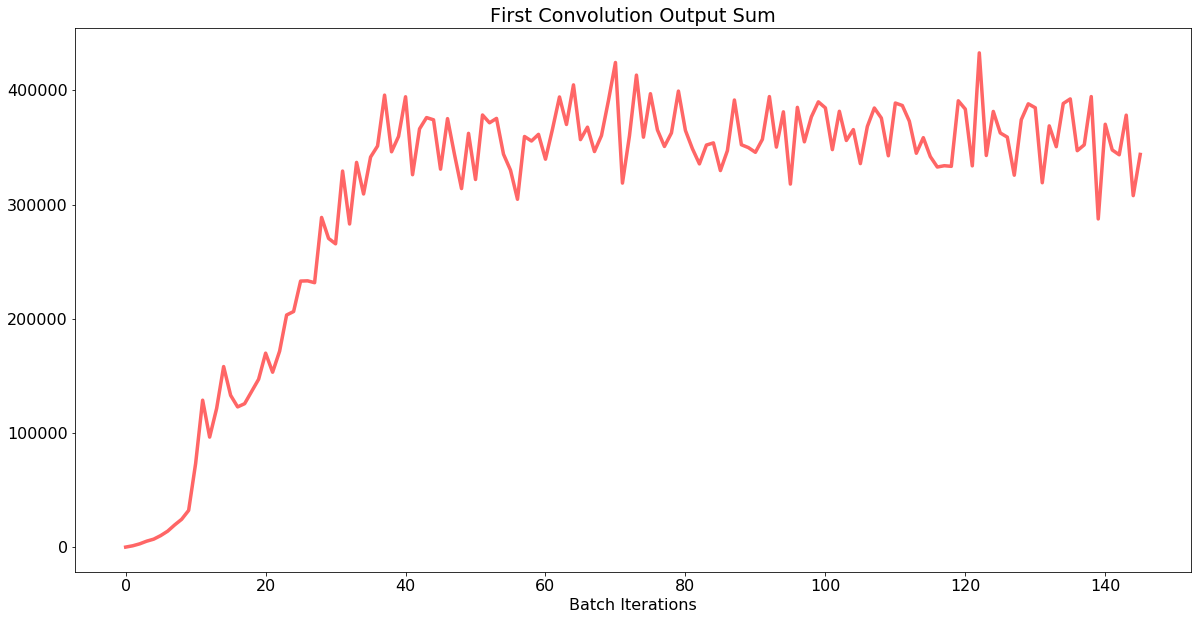

Plotting the first relu output sum


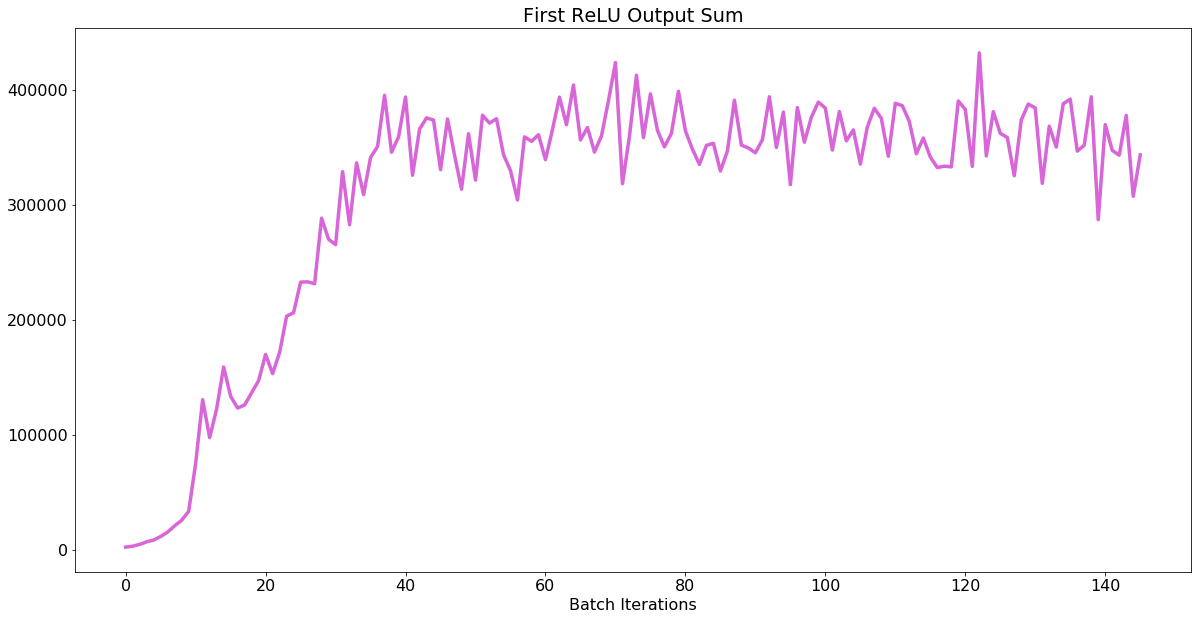

Plotting the first max unpool output sum


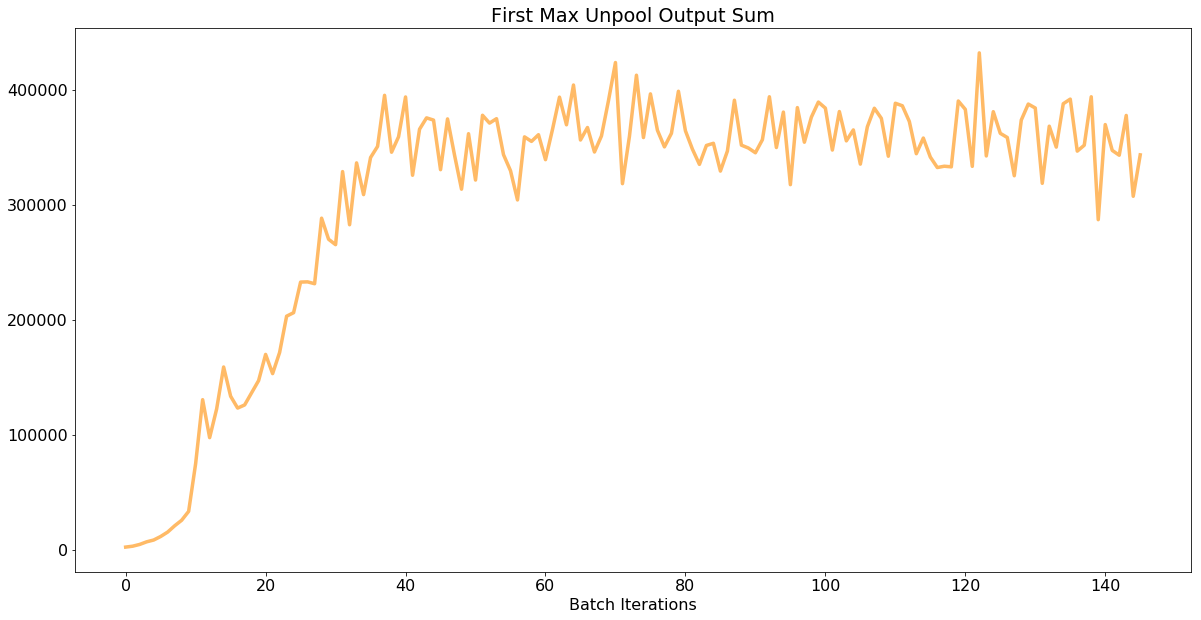

Plotting the second convolution output sum


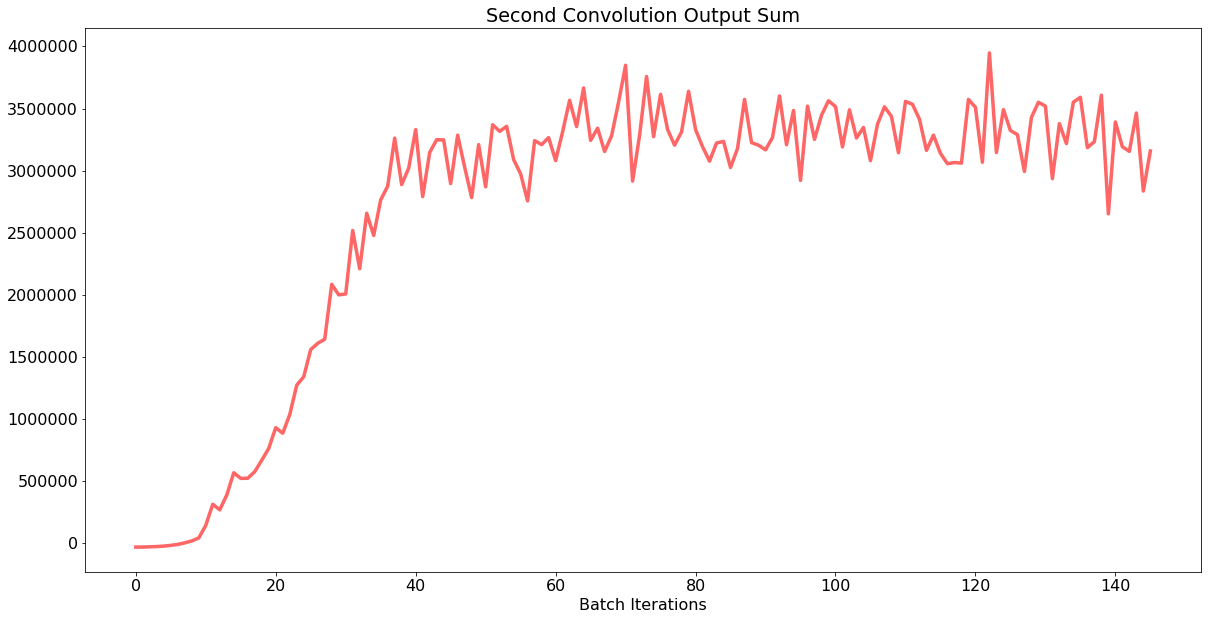

Plotting the second relu output sum


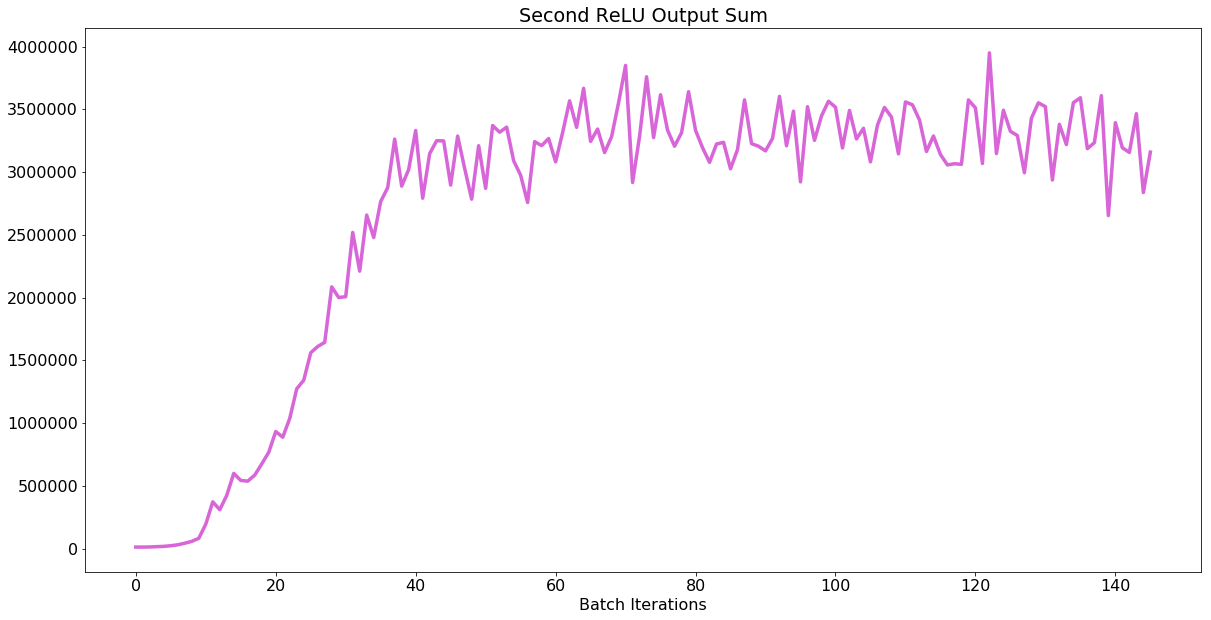

Plotting the second max unpool output sum


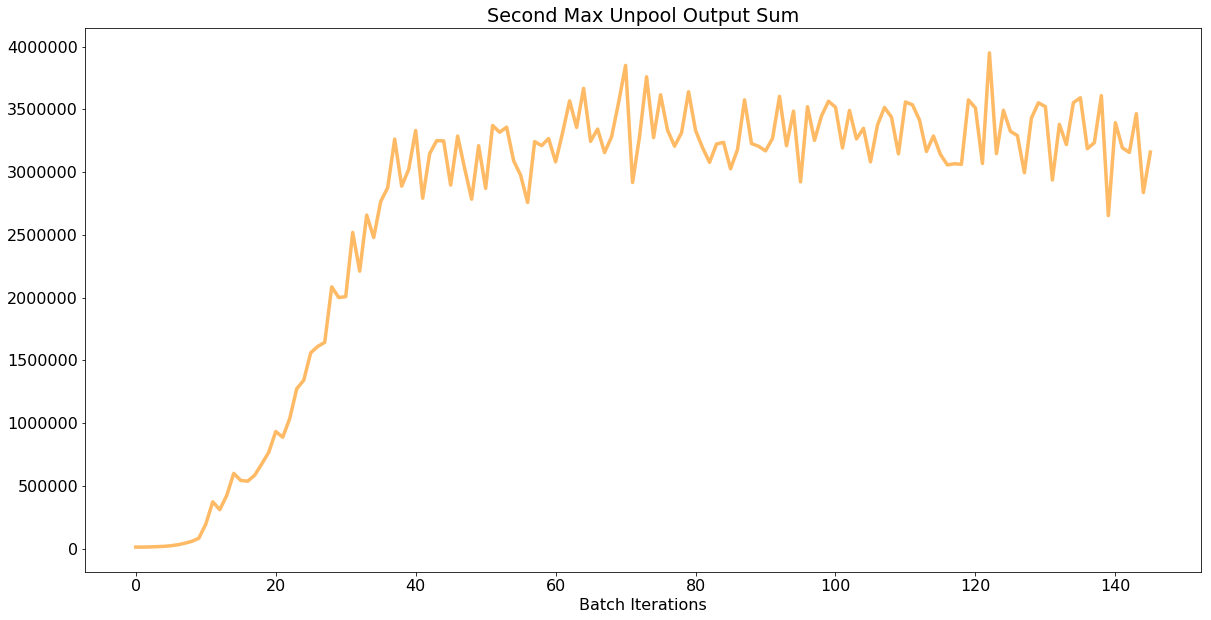

Plotting the third convolution output sum


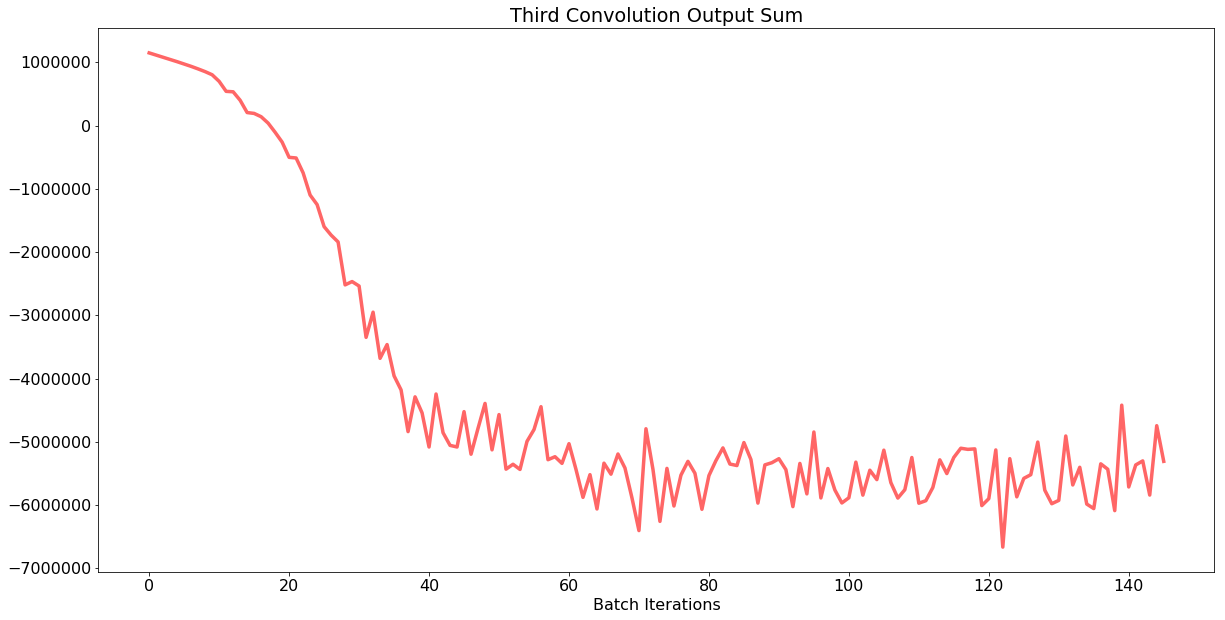

Plotting the third relu output sum


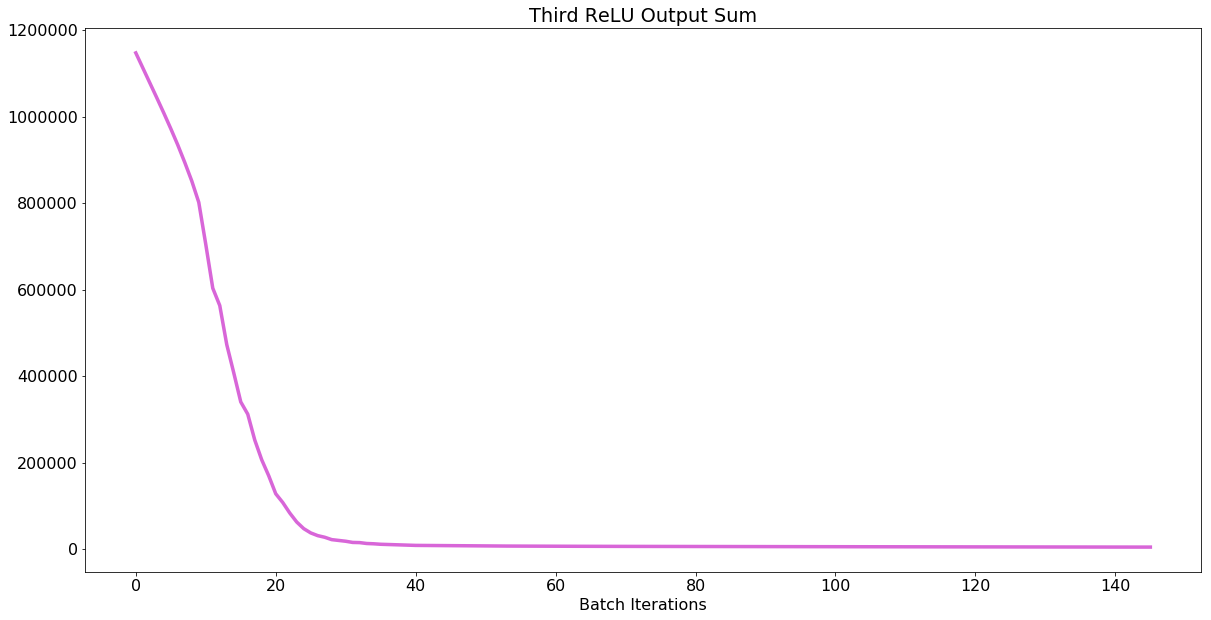

reconstructed cube = torch.Size([16, 128, 128, 128])
reconstructed cube = torch.Size([128, 128, 128])
MSE Loss = tensor(34.6140, device='cuda:0', grad_fn=<MseLossBackward>)
KLD Loss = tensor(0.1380, device='cuda:0', grad_fn=<DivBackward0>)
Train Epoch: 1 [0/256 (0%)]	Loss: 2.171997070312
Data transfer to device completed.
Starting Encoding
torch.Size([16, 2048])
Encode - Forward Pass Finished
torch.Size([16, 16])
torch.Size([16, 16])
Starting Decoding
FIRST DECODE OUT SUM = 22203.598
CONV 1 OUT SUM = 324579.56
RELU 1 OUT SUM = 324579.56
MAX UNPOOL 1 OUT SUM = 324579.66
CONV 2 OUT SUM = 2986487.0
RELU 2 OUT SUM = 2987728.2
MAX UNPOOL 2 OUT SUM = 2987728.2
CONV 3 OUT SUM = -5007734.0
RELU 3 OUT SUM = 5297.9985
data shape = torch.Size([16, 128, 128, 128])
data shape = (128, 128, 128)
Plotting the first decoder output sum
first decoder out sum = [2896.9578, 2894.755, 3238.6477, 3808.3076, 3741.1228, 4201.9287, 4773.0415, 5594.073, 6045.5674, 6948.961, 14237.286, 22334.652, 15180.516, 17629

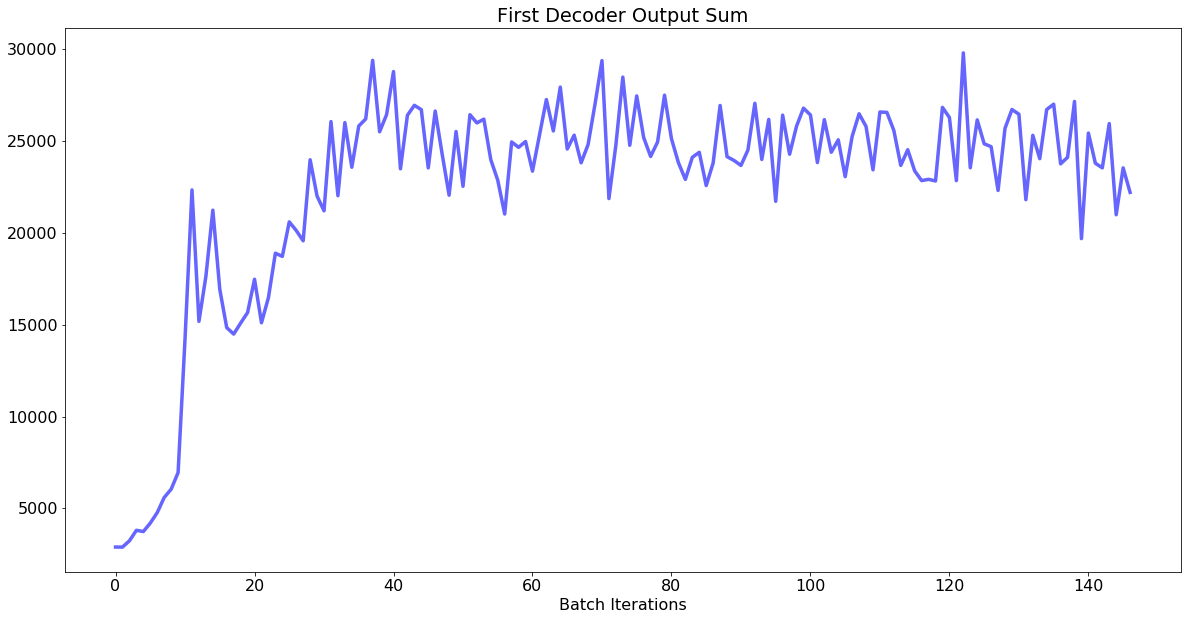

Plotting the first convolution output sum


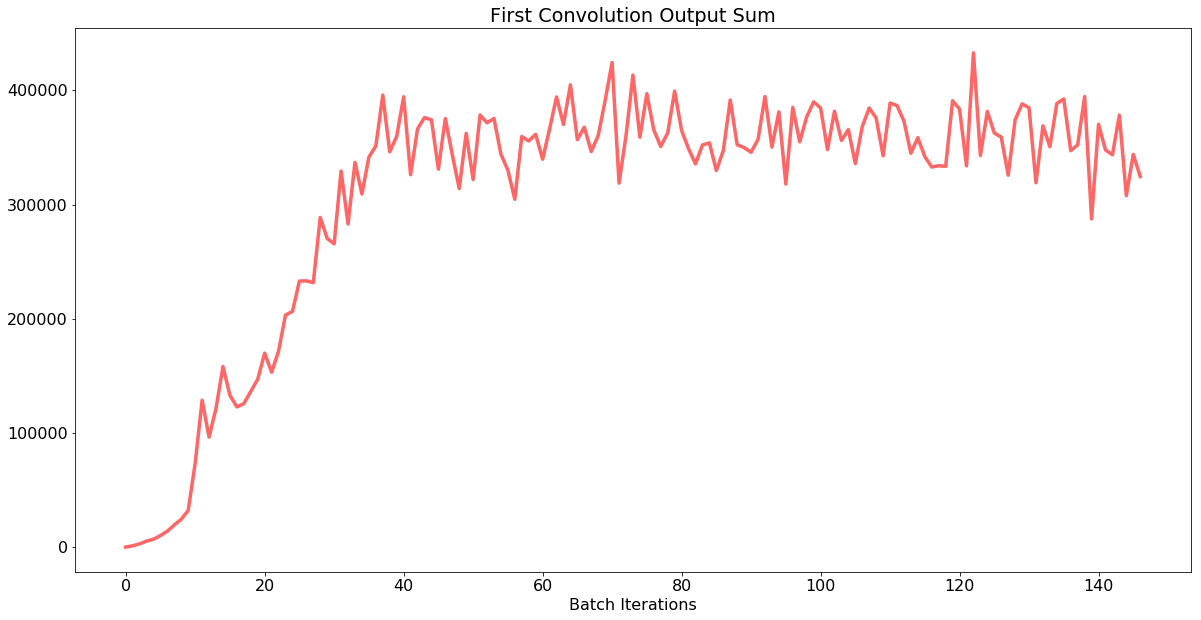

Plotting the first relu output sum


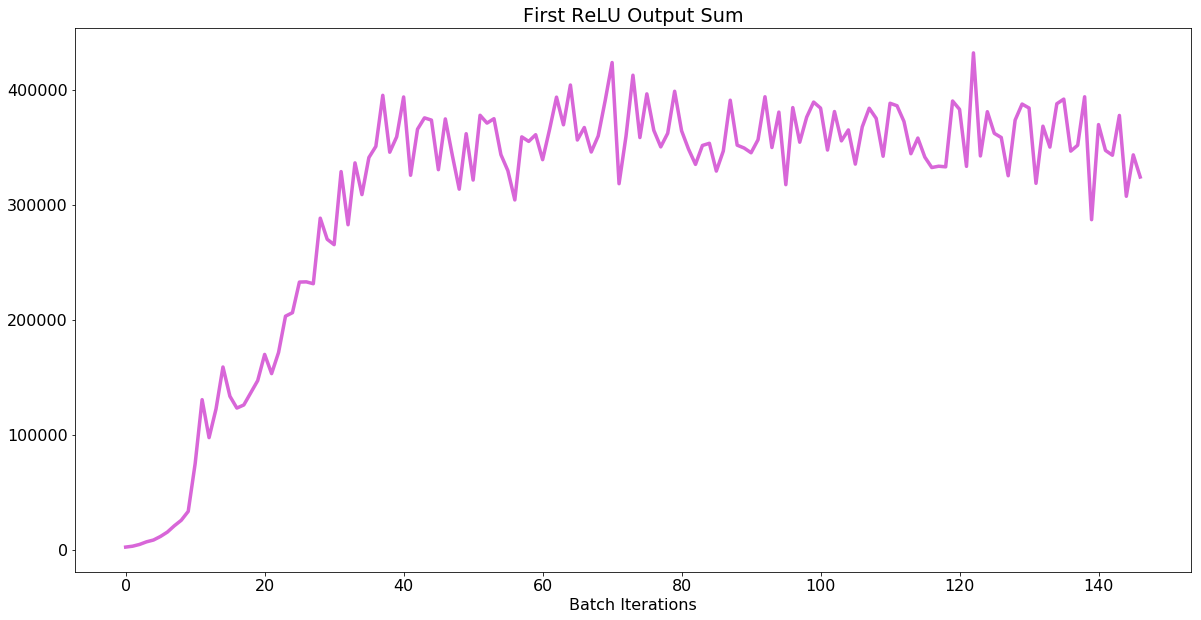

Plotting the first max unpool output sum


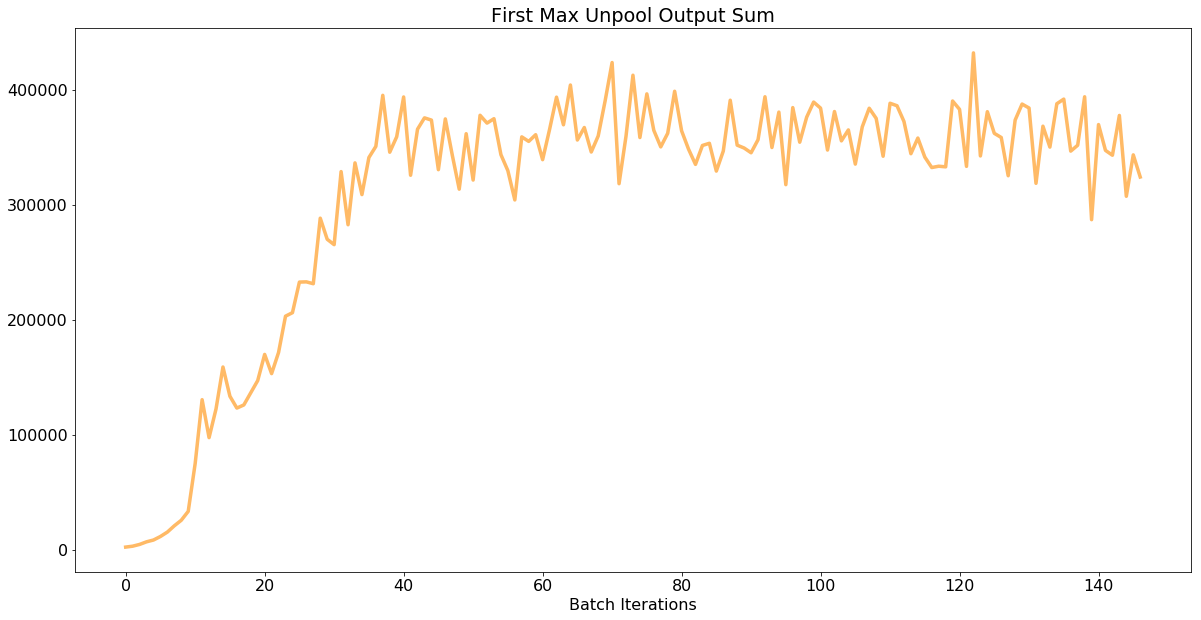

Plotting the second convolution output sum


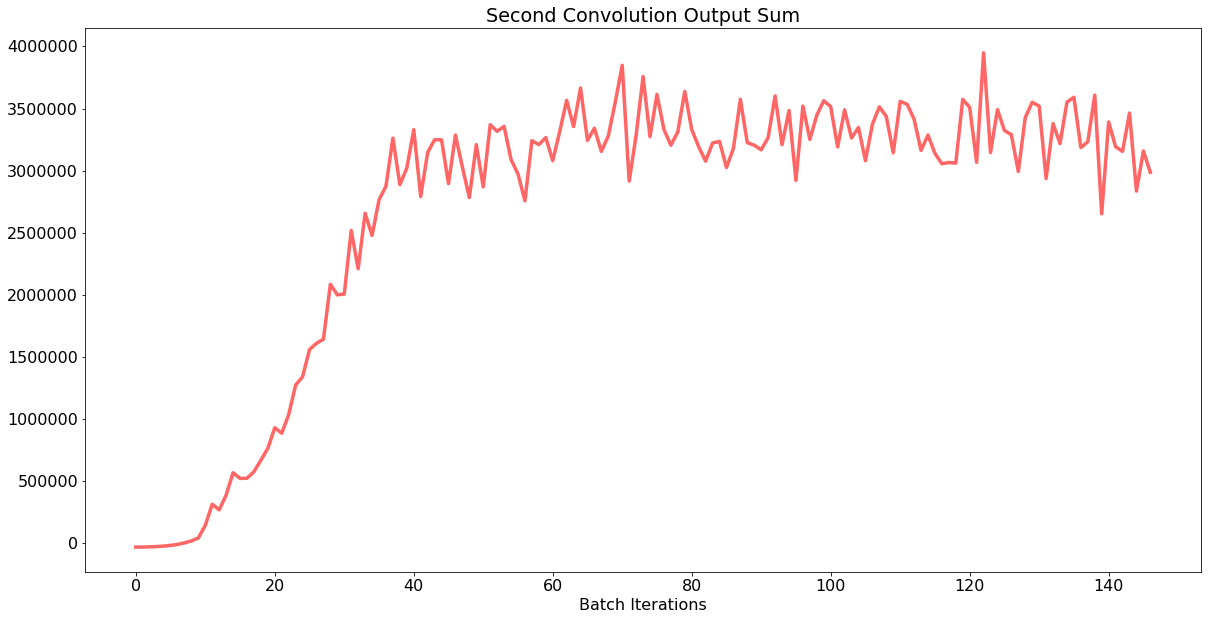

Plotting the second relu output sum


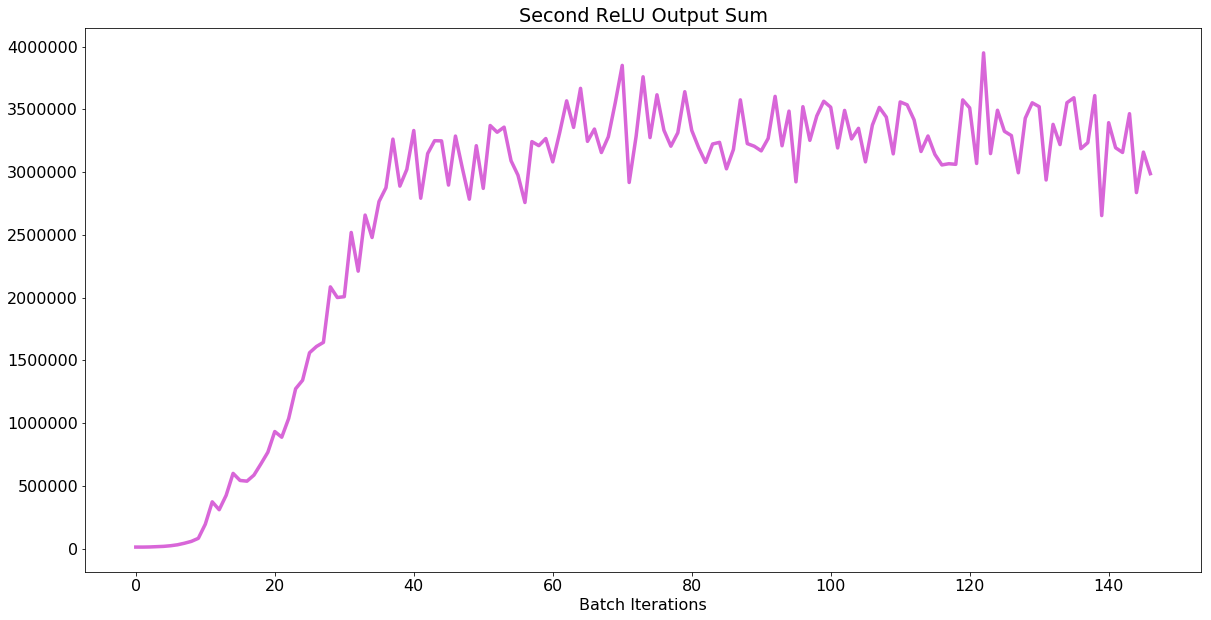

Plotting the second max unpool output sum


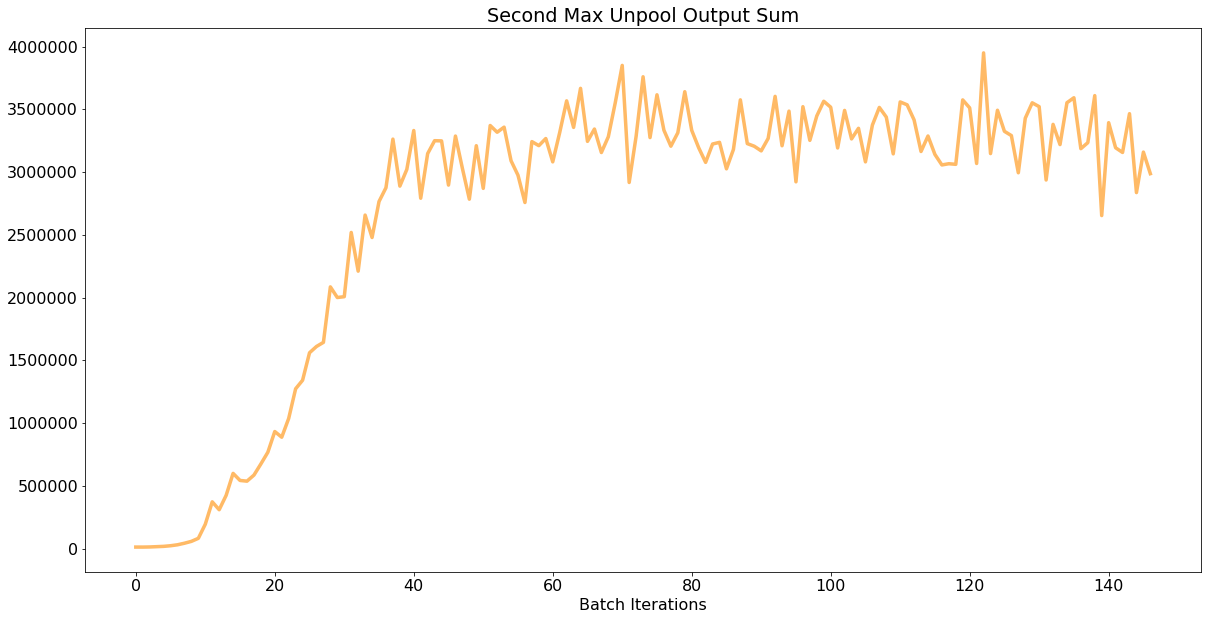

Plotting the third convolution output sum


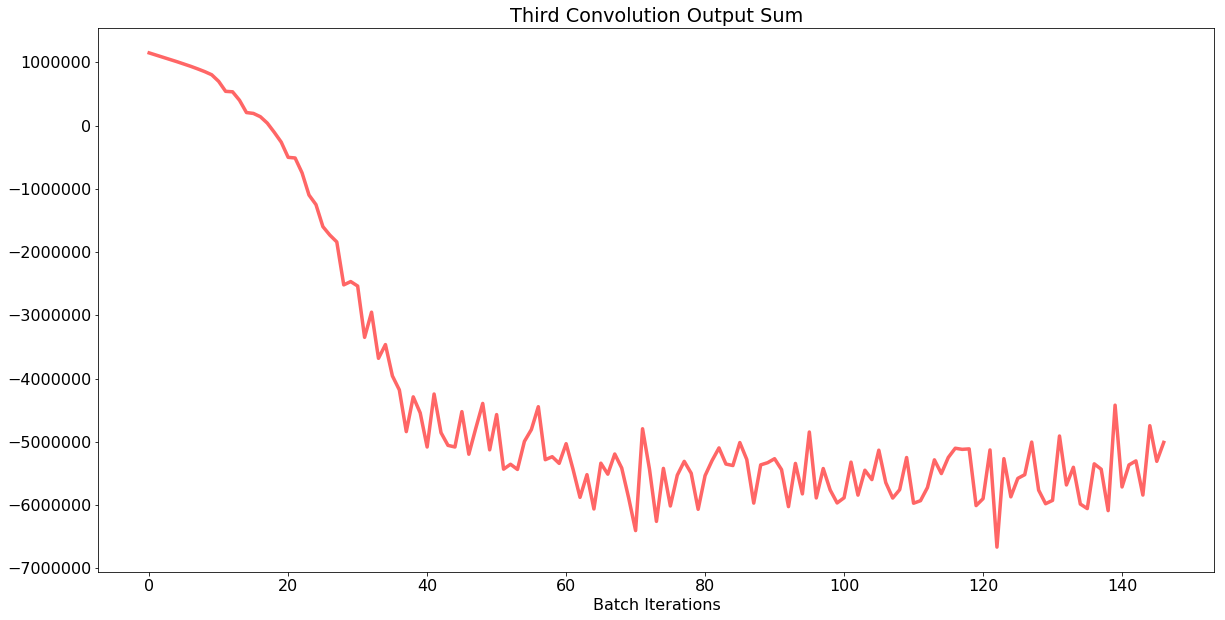

Plotting the third relu output sum


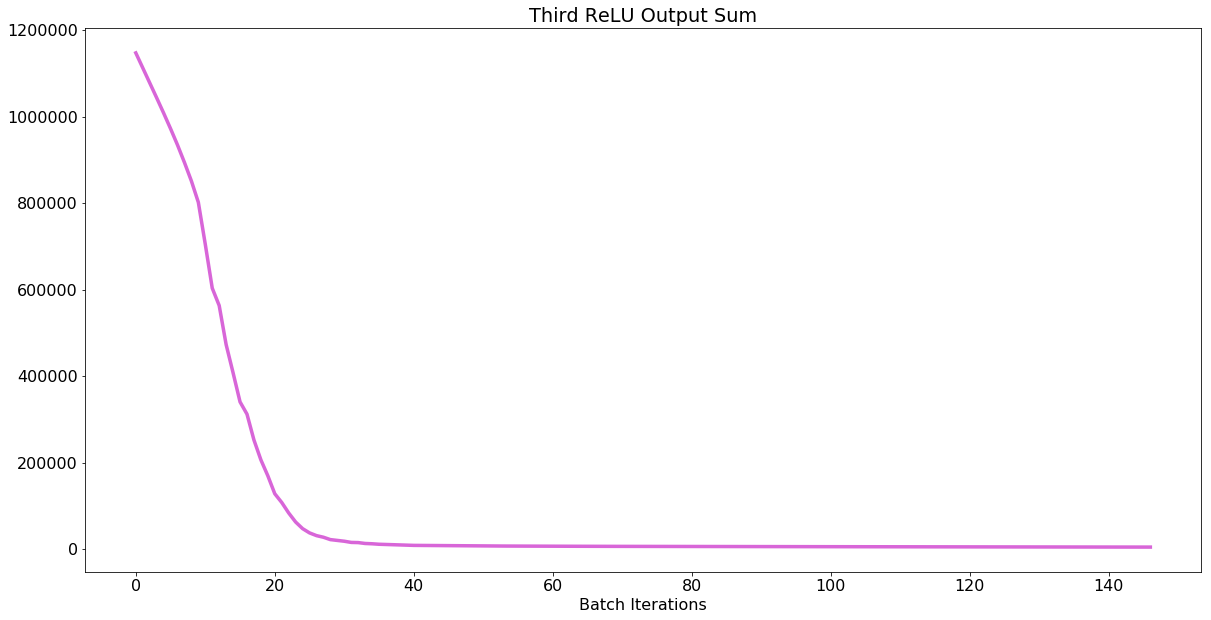

reconstructed cube = torch.Size([16, 128, 128, 128])
reconstructed cube = torch.Size([128, 128, 128])
MSE Loss = tensor(34.1209, device='cuda:0', grad_fn=<MseLossBackward>)
KLD Loss = tensor(0.1437, device='cuda:0', grad_fn=<DivBackward0>)
Train Epoch: 1 [16/256 (6%)]	Loss: 2.141531705856
Data transfer to device completed.
Starting Encoding
torch.Size([16, 2048])
Encode - Forward Pass Finished
torch.Size([16, 16])
torch.Size([16, 16])
Starting Decoding
FIRST DECODE OUT SUM = 25132.238
CONV 1 OUT SUM = 366750.28
RELU 1 OUT SUM = 366750.28
MAX UNPOOL 1 OUT SUM = 366750.3
CONV 2 OUT SUM = 3362323.8
RELU 2 OUT SUM = 3363797.5
MAX UNPOOL 2 OUT SUM = 3363795.8
CONV 3 OUT SUM = -5665021.0
RELU 3 OUT SUM = 5258.791
data shape = torch.Size([16, 128, 128, 128])
data shape = (128, 128, 128)
Plotting the first decoder output sum
first decoder out sum = [2896.9578, 2894.755, 3238.6477, 3808.3076, 3741.1228, 4201.9287, 4773.0415, 5594.073, 6045.5674, 6948.961, 14237.286, 22334.652, 15180.516, 17629.

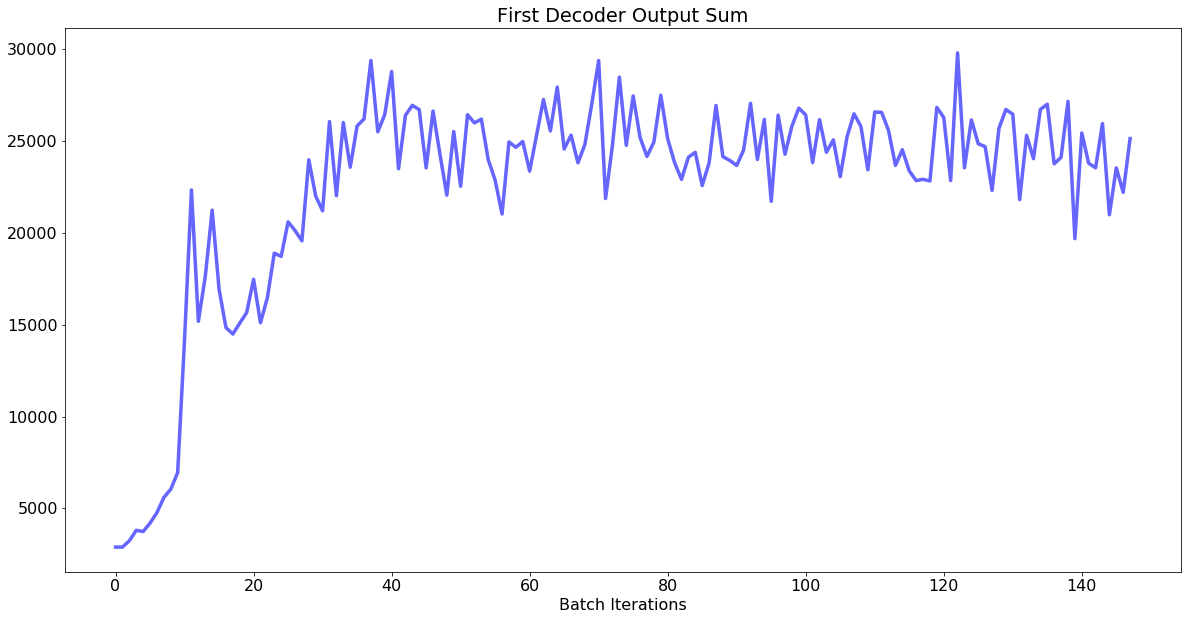

Plotting the first convolution output sum


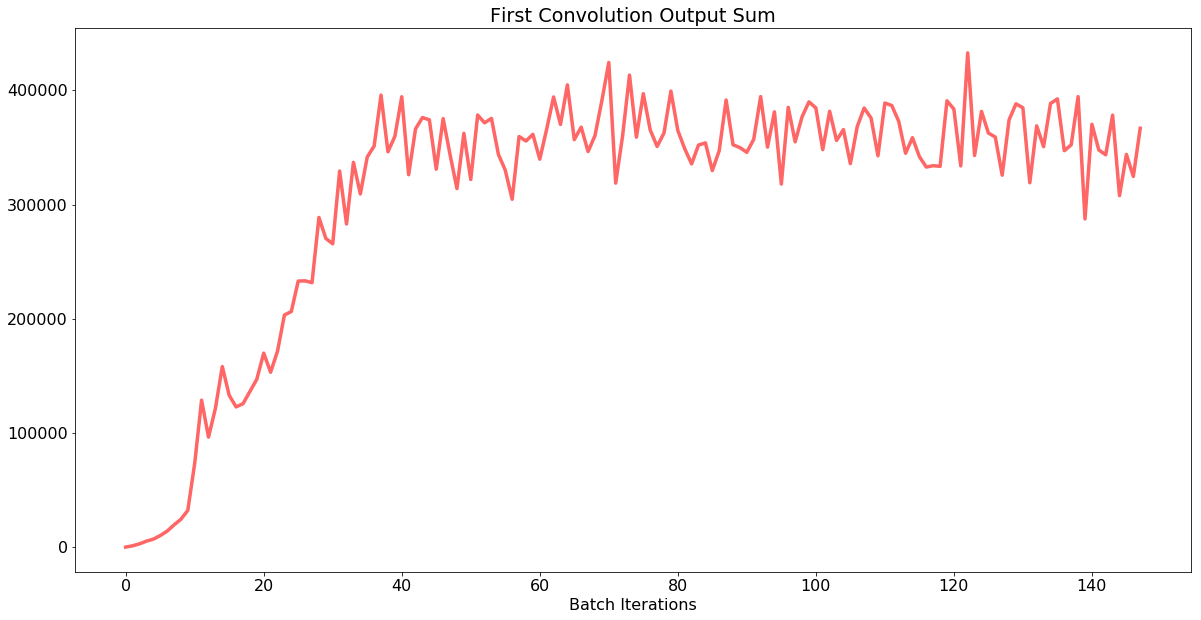

Plotting the first relu output sum


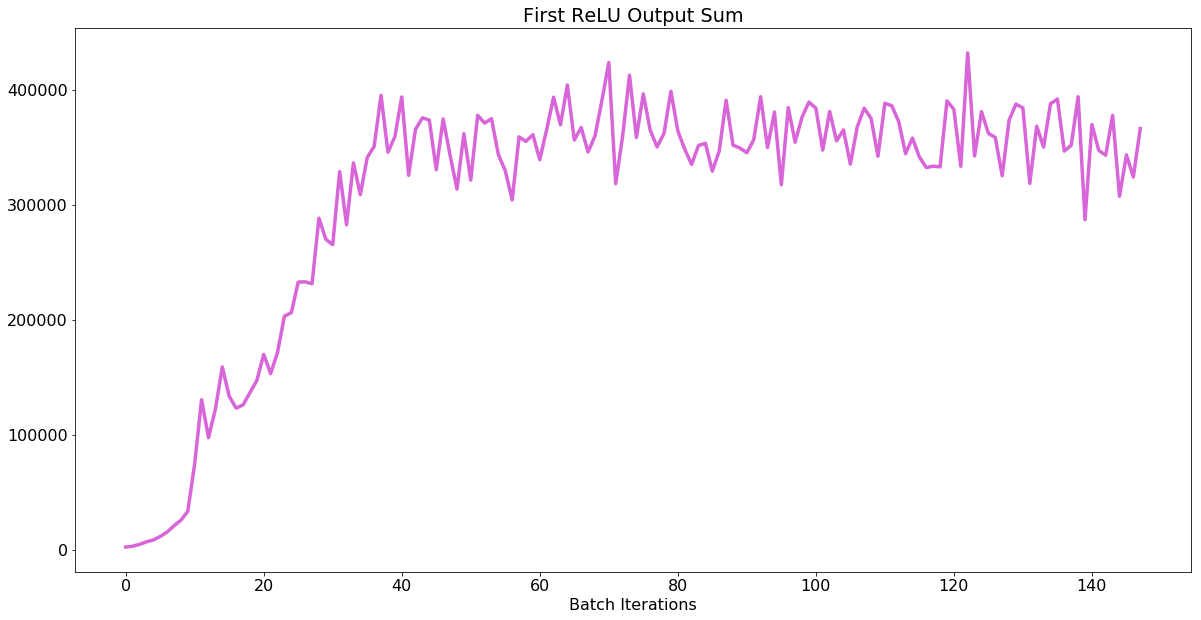

Plotting the first max unpool output sum


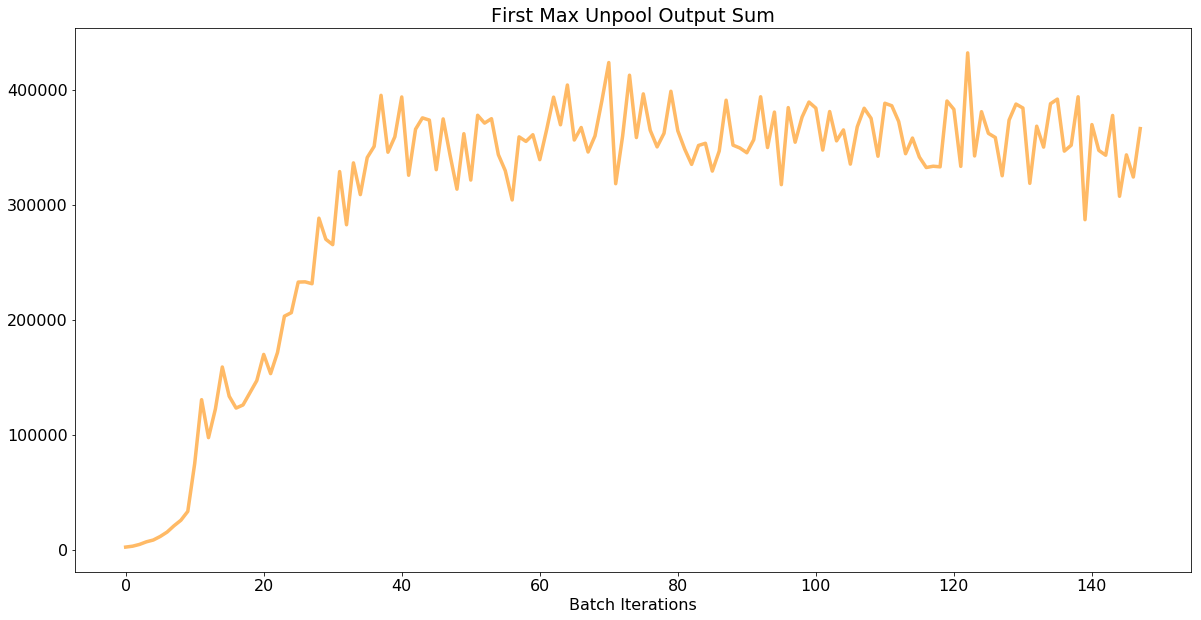

Plotting the second convolution output sum


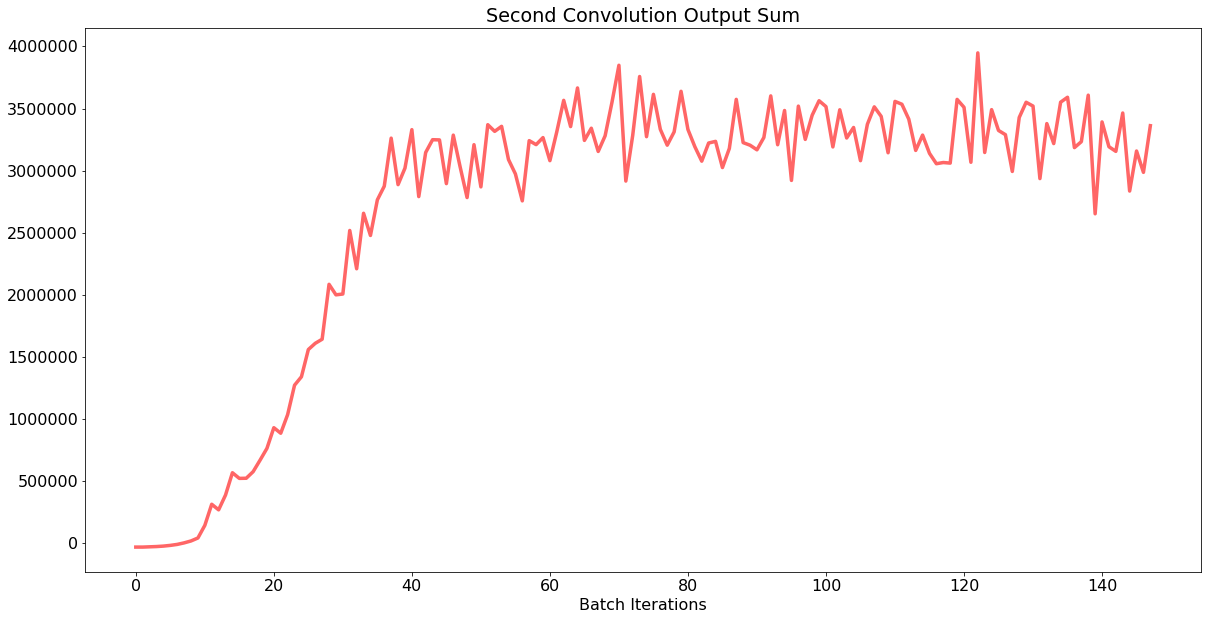

Plotting the second relu output sum


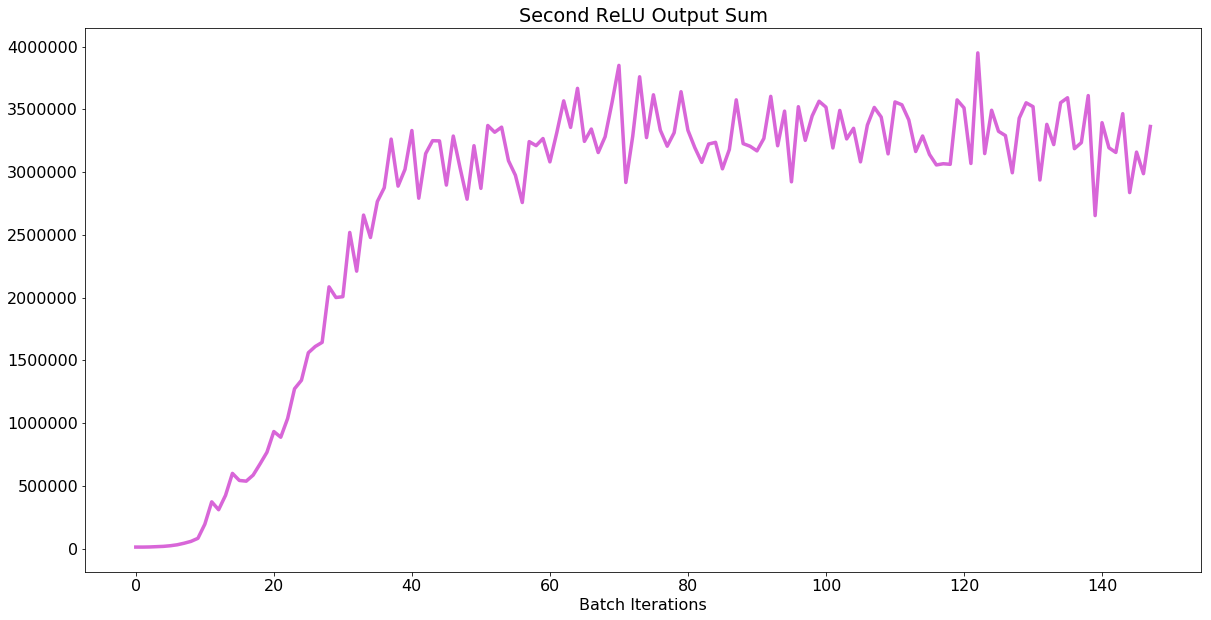

Plotting the second max unpool output sum


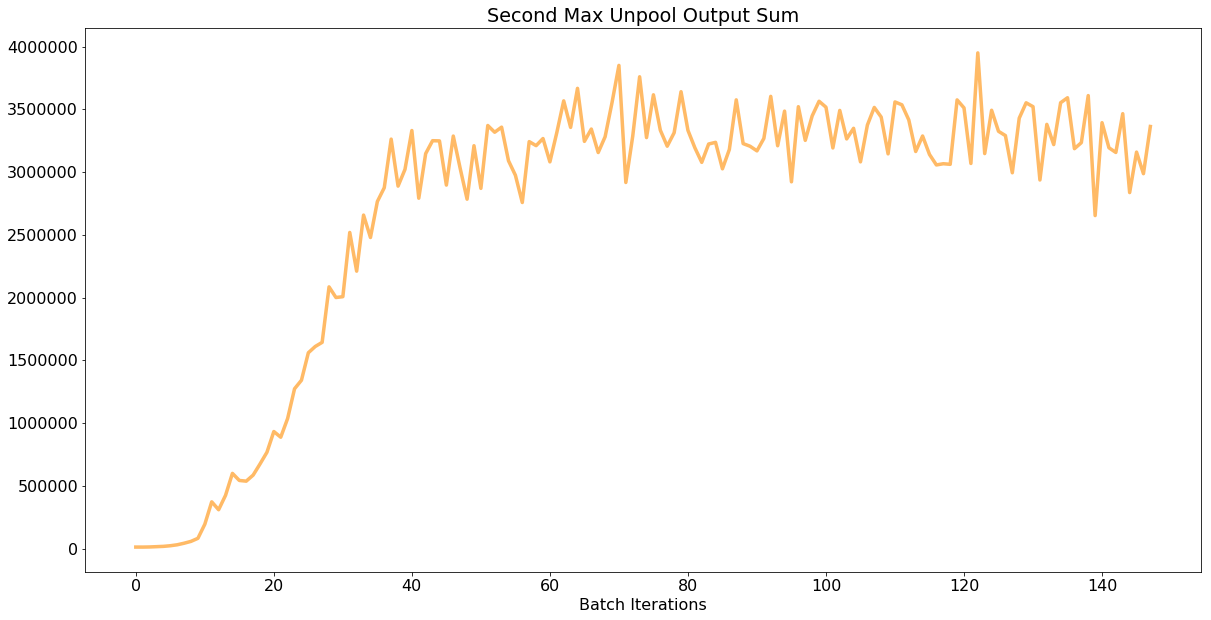

Plotting the third convolution output sum


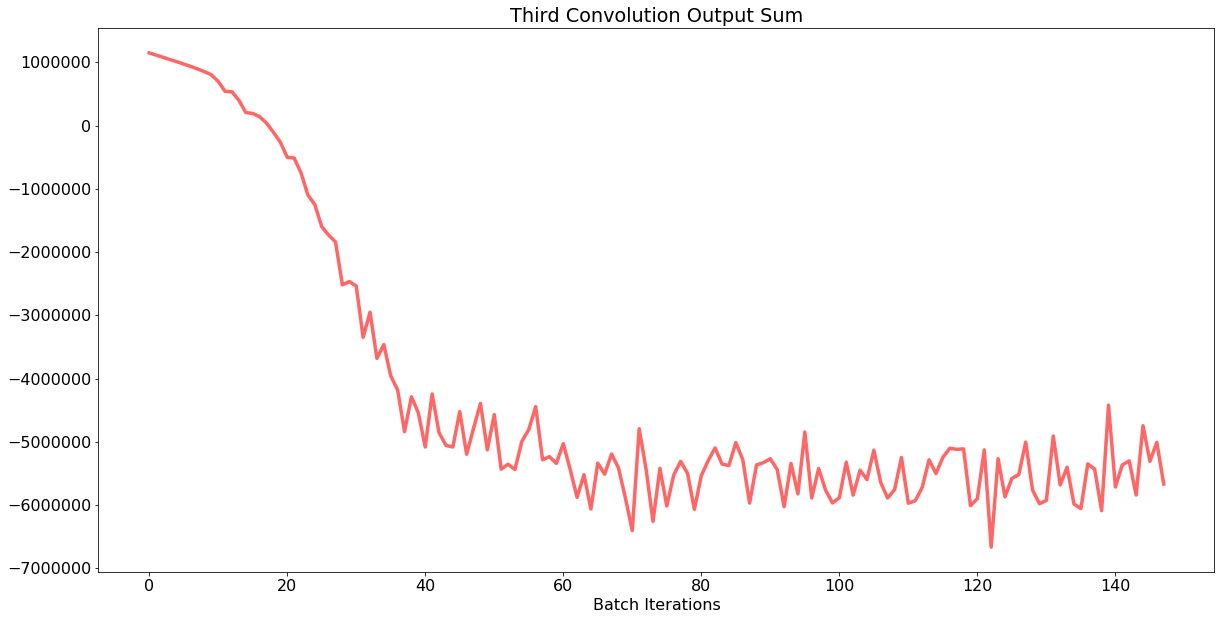

Plotting the third relu output sum


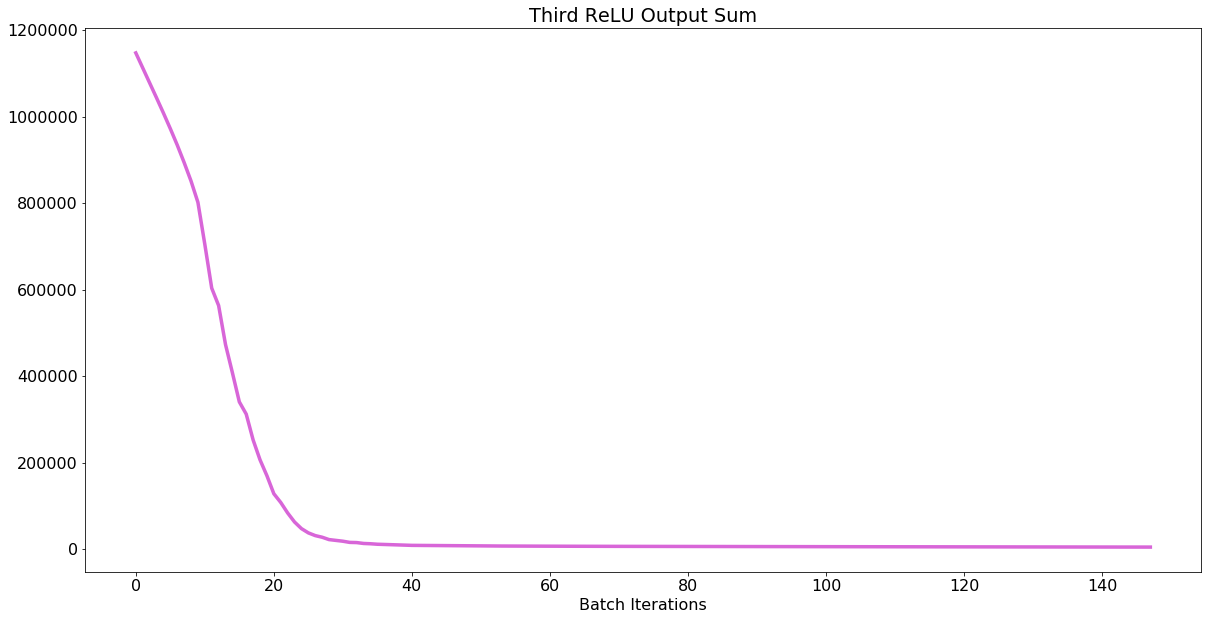

reconstructed cube = torch.Size([16, 128, 128, 128])
reconstructed cube = torch.Size([128, 128, 128])
MSE Loss = tensor(32.4284, device='cuda:0', grad_fn=<MseLossBackward>)
KLD Loss = tensor(0.1451, device='cuda:0', grad_fn=<DivBackward0>)
Train Epoch: 1 [32/256 (12%)]	Loss: 2.035846233368
Data transfer to device completed.
Starting Encoding
torch.Size([16, 2048])
Encode - Forward Pass Finished
torch.Size([16, 16])
torch.Size([16, 16])
Starting Decoding
FIRST DECODE OUT SUM = 24314.742
CONV 1 OUT SUM = 353876.53
RELU 1 OUT SUM = 353876.53
MAX UNPOOL 1 OUT SUM = 353876.5
CONV 2 OUT SUM = 3245168.5
RELU 2 OUT SUM = 3246598.2
MAX UNPOOL 2 OUT SUM = 3246599.0
CONV 3 OUT SUM = -5460248.5
RELU 3 OUT SUM = 5269.0244
data shape = torch.Size([16, 128, 128, 128])
data shape = (128, 128, 128)
Plotting the first decoder output sum
first decoder out sum = [2896.9578, 2894.755, 3238.6477, 3808.3076, 3741.1228, 4201.9287, 4773.0415, 5594.073, 6045.5674, 6948.961, 14237.286, 22334.652, 15180.516, 1762

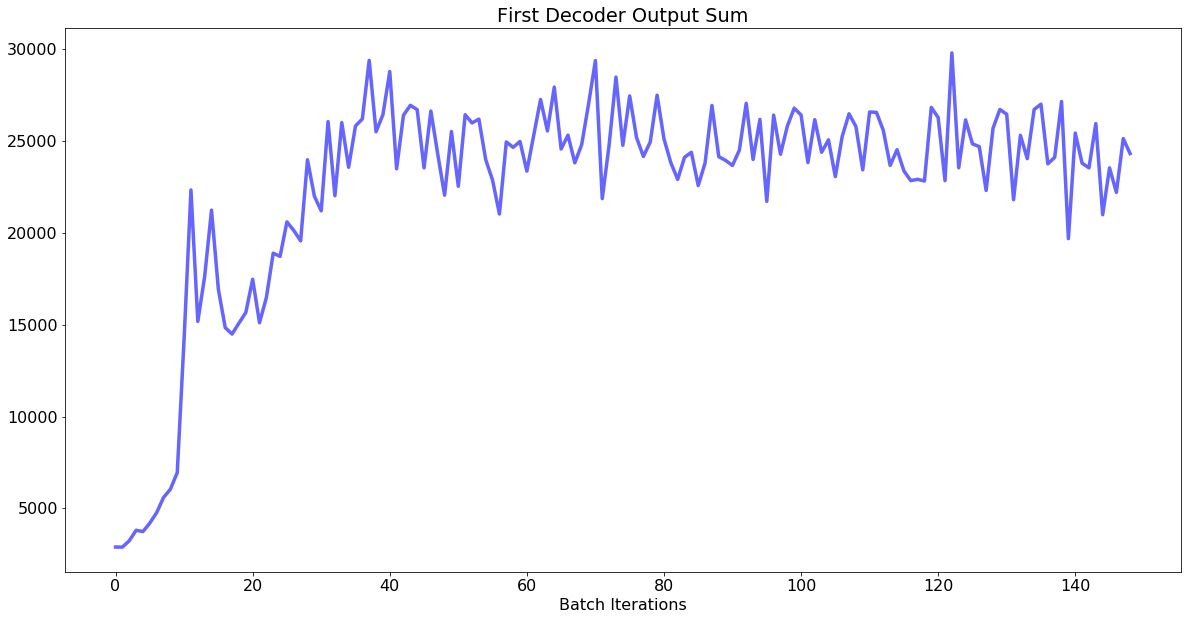

Plotting the first convolution output sum


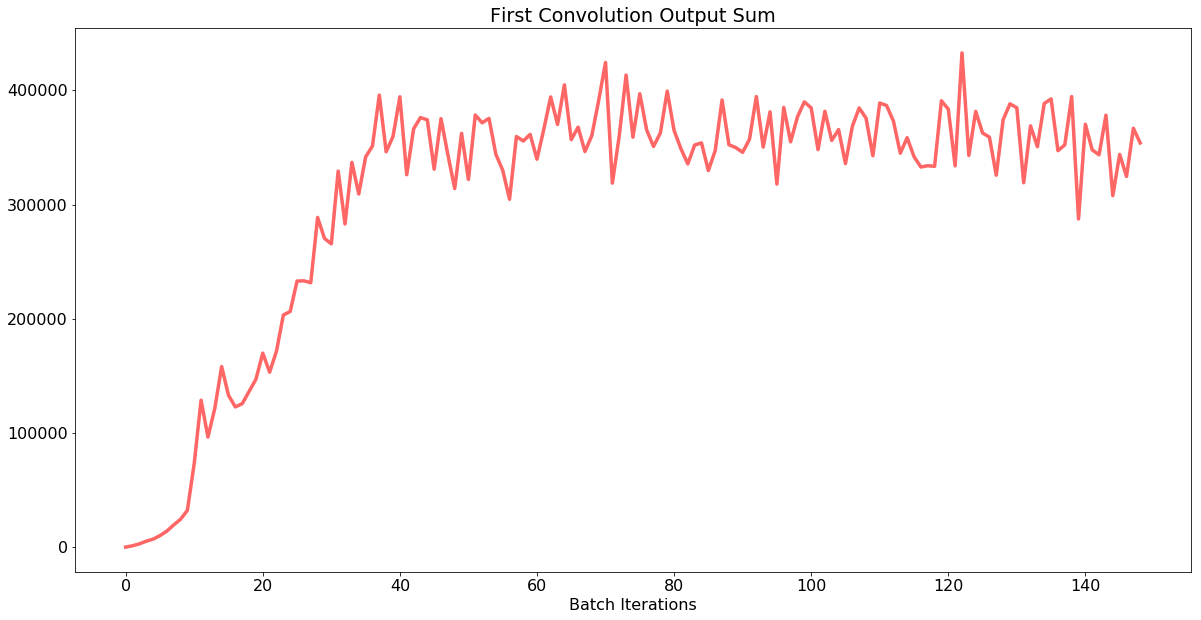

Plotting the first relu output sum


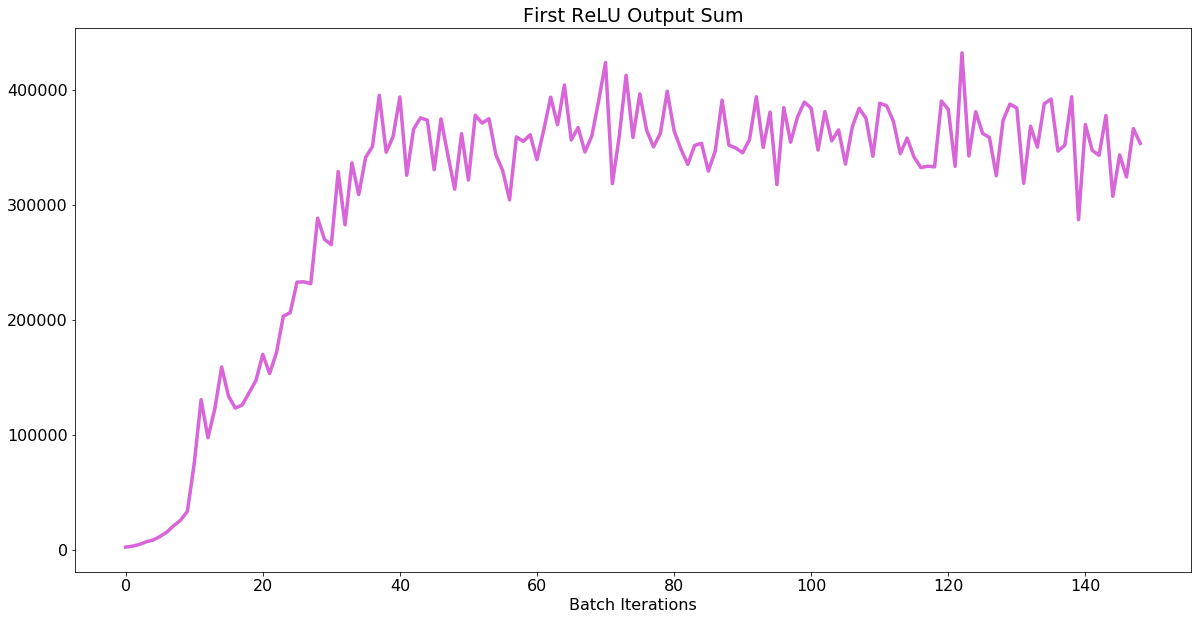

Plotting the first max unpool output sum


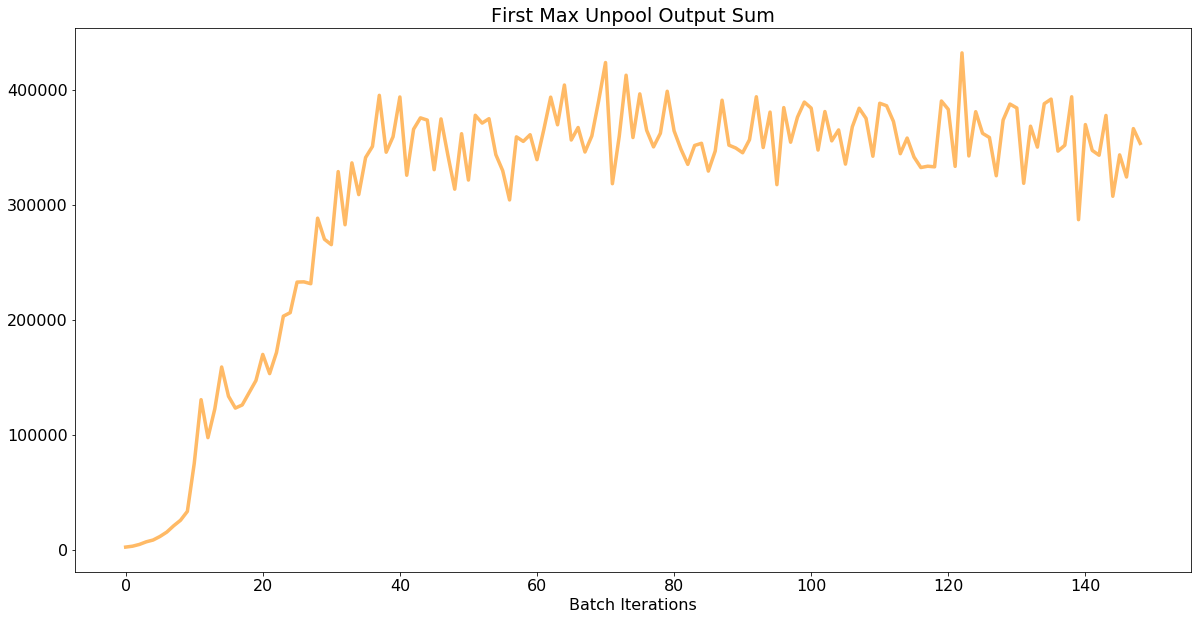

Plotting the second convolution output sum


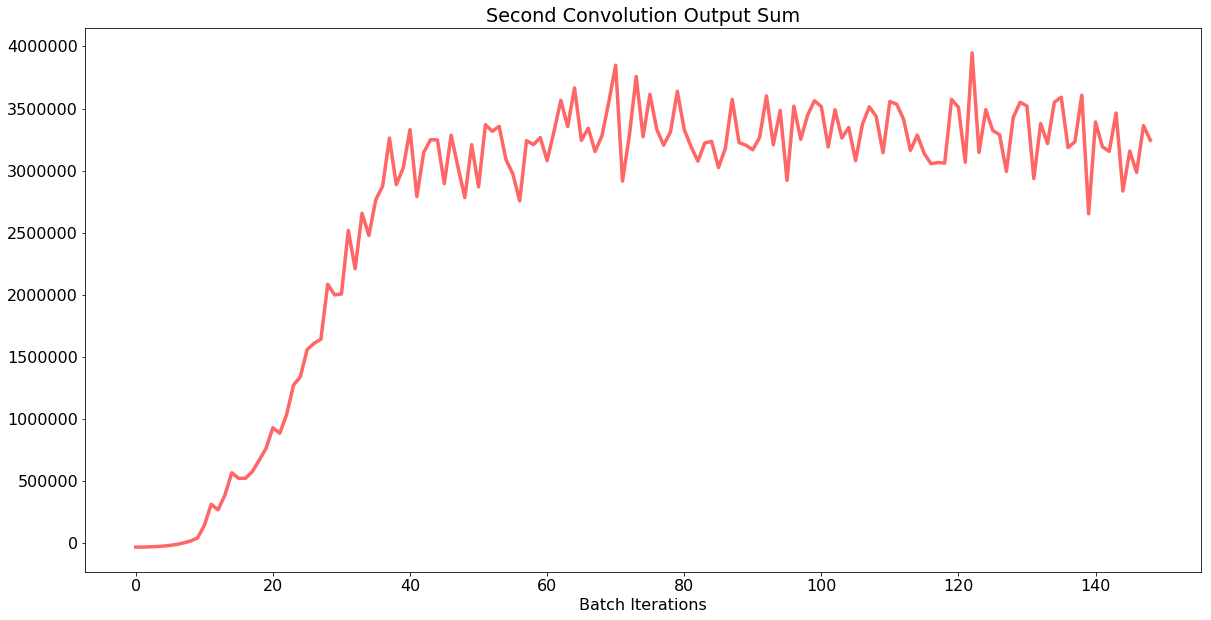

Plotting the second relu output sum


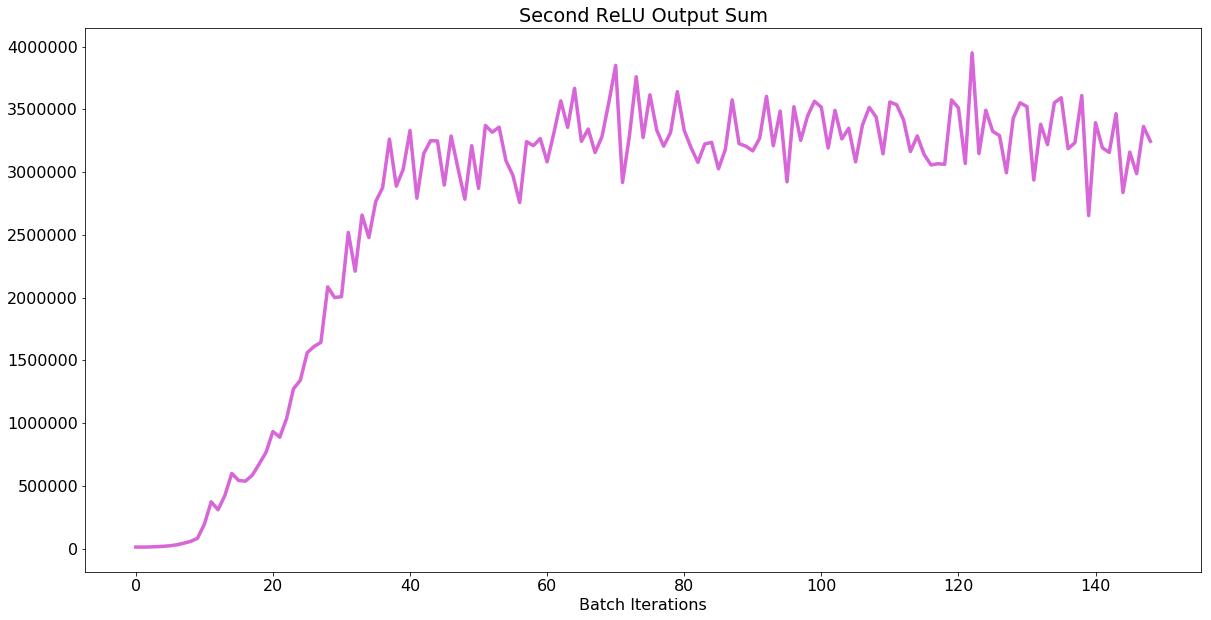

Plotting the second max unpool output sum


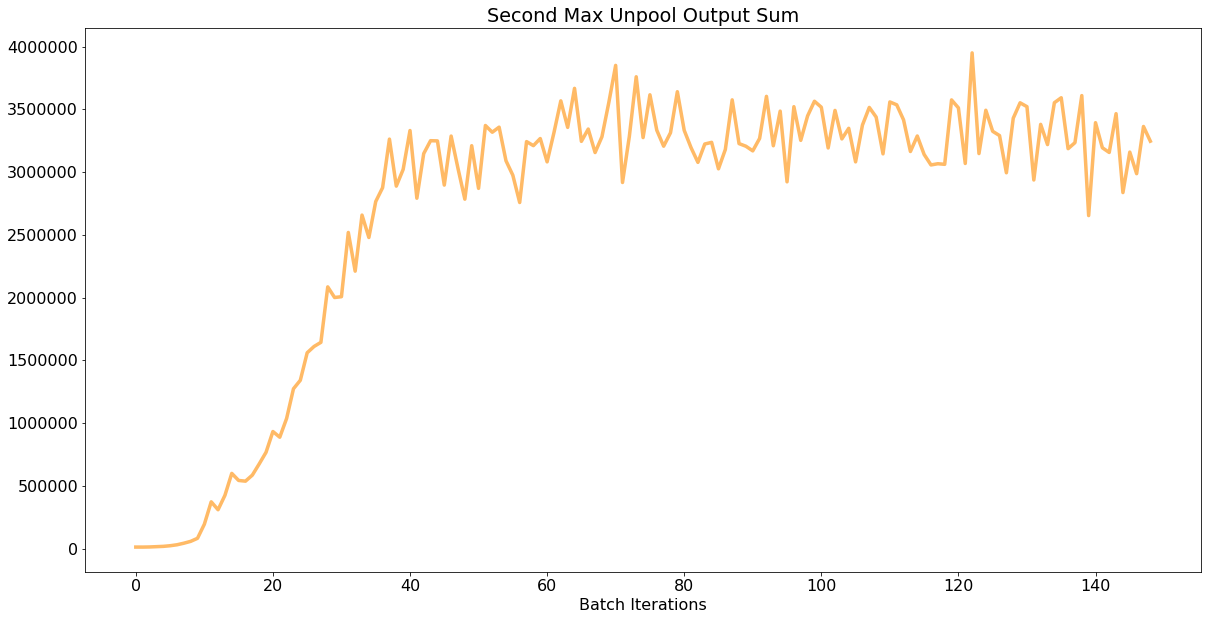

Plotting the third convolution output sum


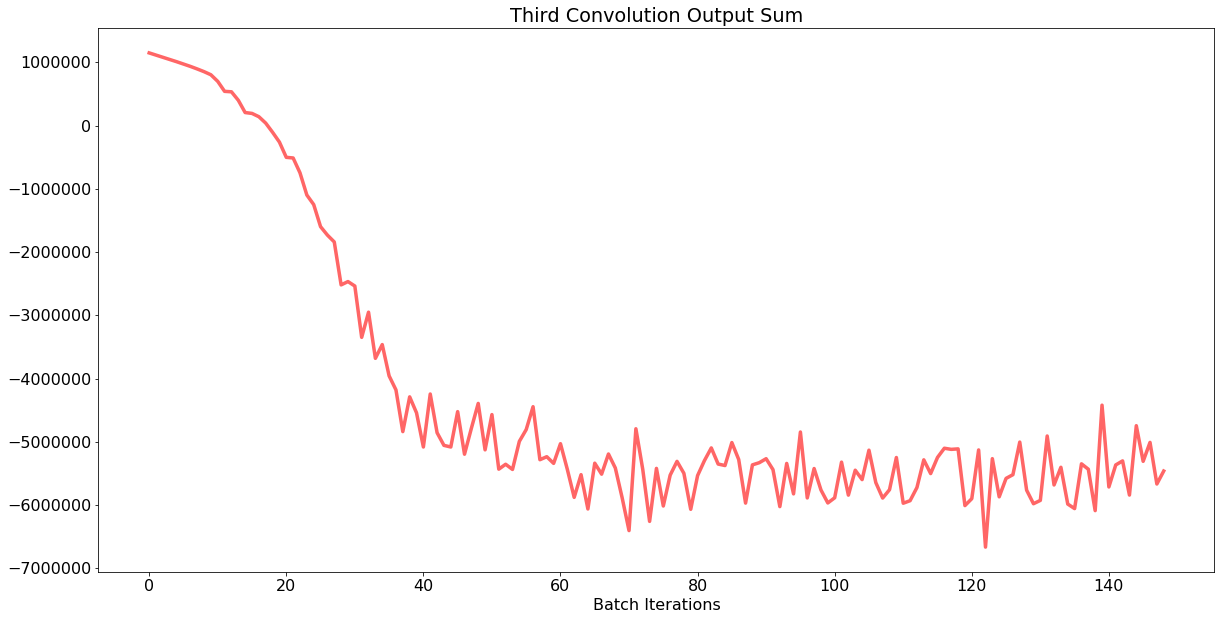

Plotting the third relu output sum


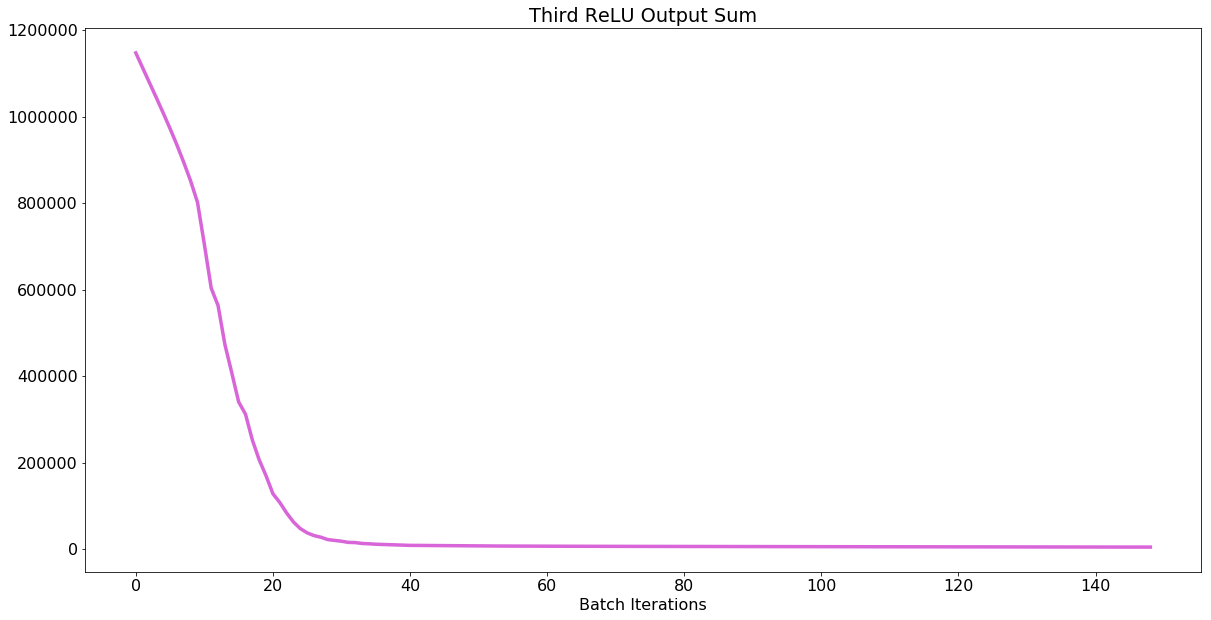

reconstructed cube = torch.Size([16, 128, 128, 128])
reconstructed cube = torch.Size([128, 128, 128])
MSE Loss = tensor(35.3379, device='cuda:0', grad_fn=<MseLossBackward>)
KLD Loss = tensor(0.1566, device='cuda:0', grad_fn=<DivBackward0>)
Train Epoch: 1 [48/256 (19%)]	Loss: 2.218406915665
Data transfer to device completed.
Starting Encoding
torch.Size([16, 2048])
Encode - Forward Pass Finished
torch.Size([16, 16])
torch.Size([16, 16])
Starting Decoding
FIRST DECODE OUT SUM = 25075.773
CONV 1 OUT SUM = 365596.4
RELU 1 OUT SUM = 365596.4
MAX UNPOOL 1 OUT SUM = 365596.44
CONV 2 OUT SUM = 3351439.0
RELU 2 OUT SUM = 3352937.0
MAX UNPOOL 2 OUT SUM = 3352938.8
CONV 3 OUT SUM = -5647591.5
RELU 3 OUT SUM = 5232.0776
data shape = torch.Size([16, 128, 128, 128])
data shape = (128, 128, 128)
Plotting the first decoder output sum
first decoder out sum = [2896.9578, 2894.755, 3238.6477, 3808.3076, 3741.1228, 4201.9287, 4773.0415, 5594.073, 6045.5674, 6948.961, 14237.286, 22334.652, 15180.516, 17629

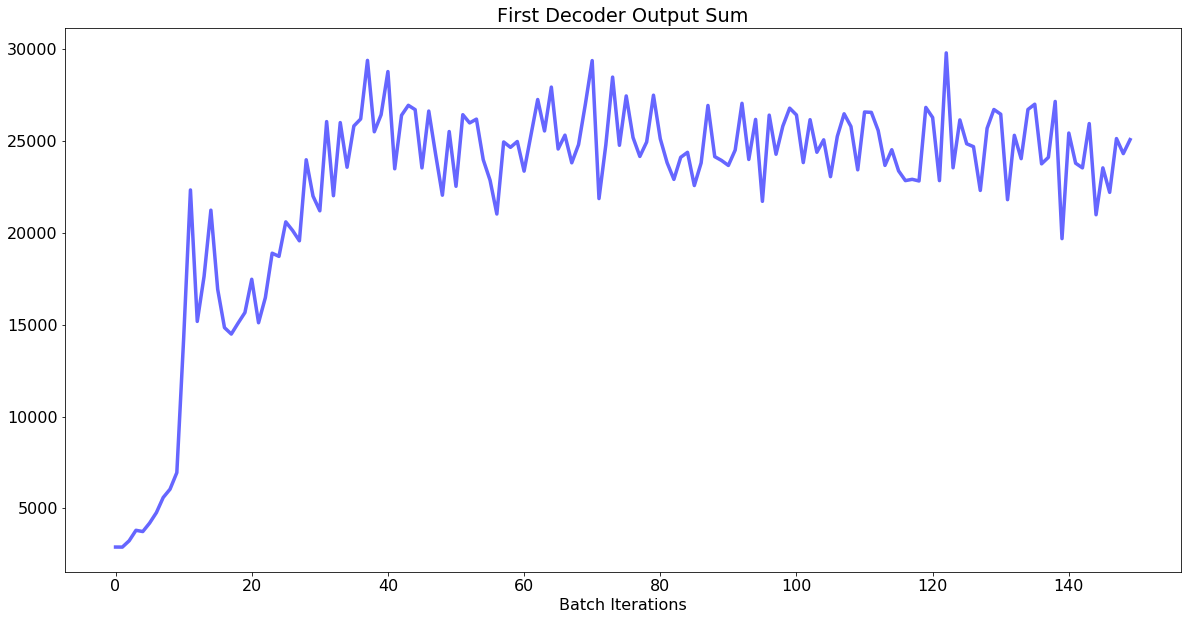

Plotting the first convolution output sum


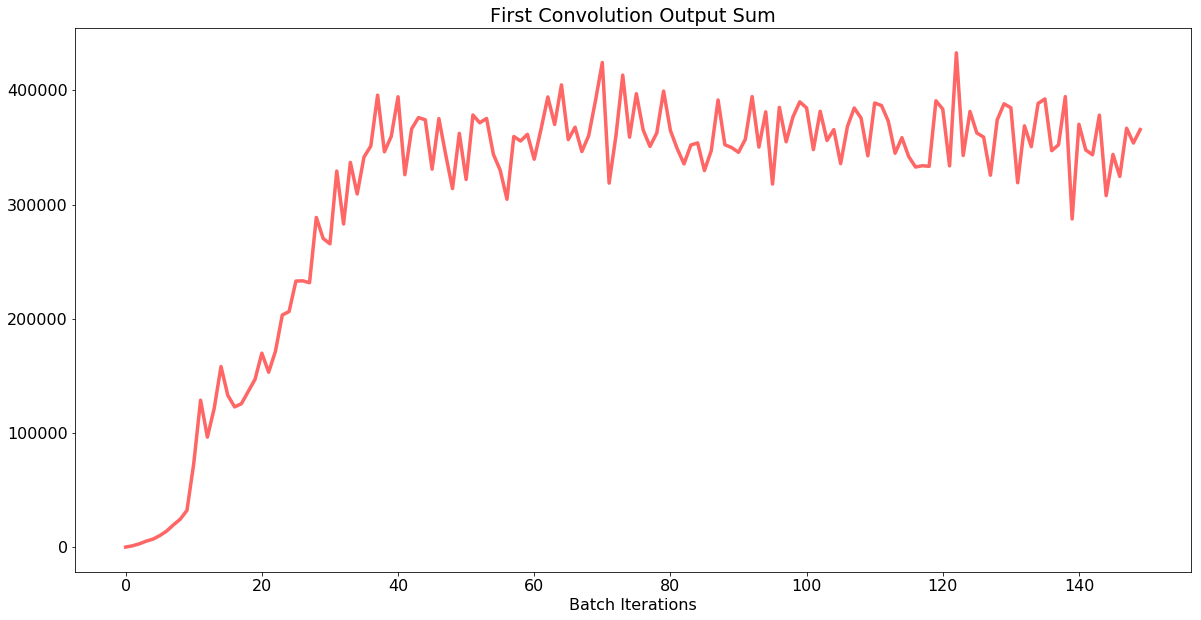

Plotting the first relu output sum


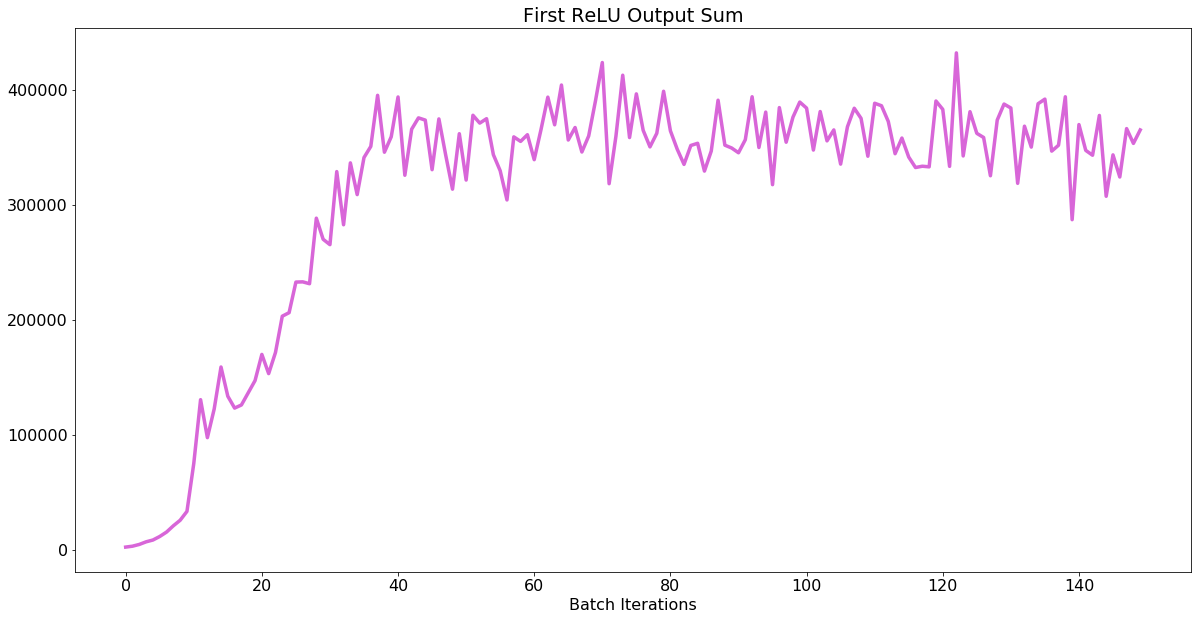

Plotting the first max unpool output sum


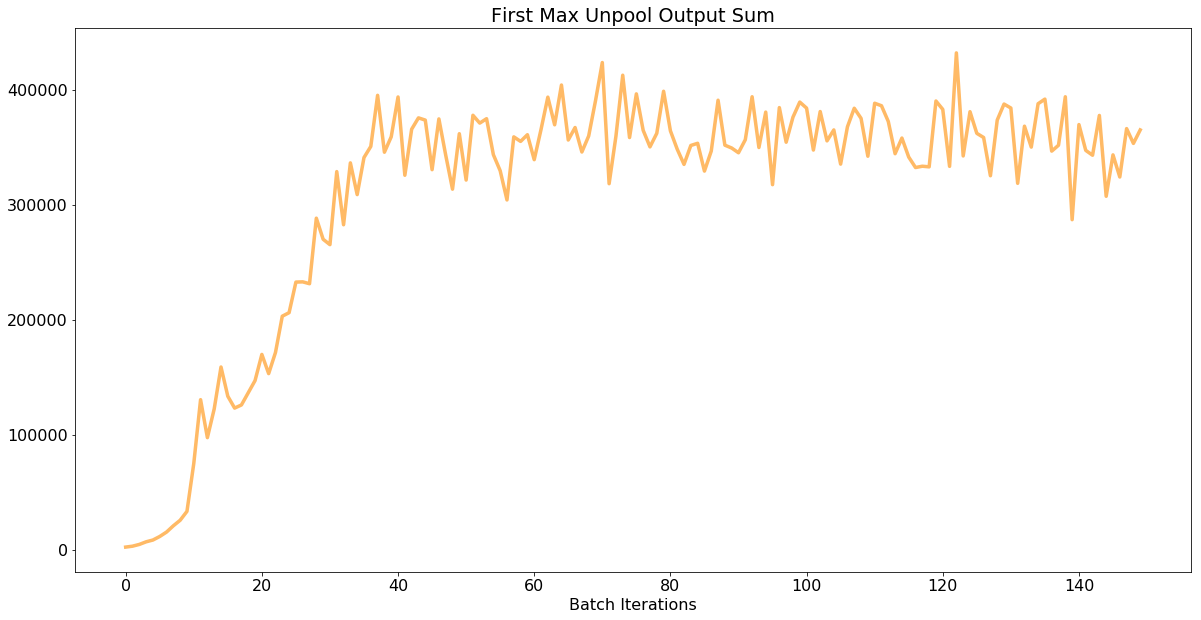

Plotting the second convolution output sum


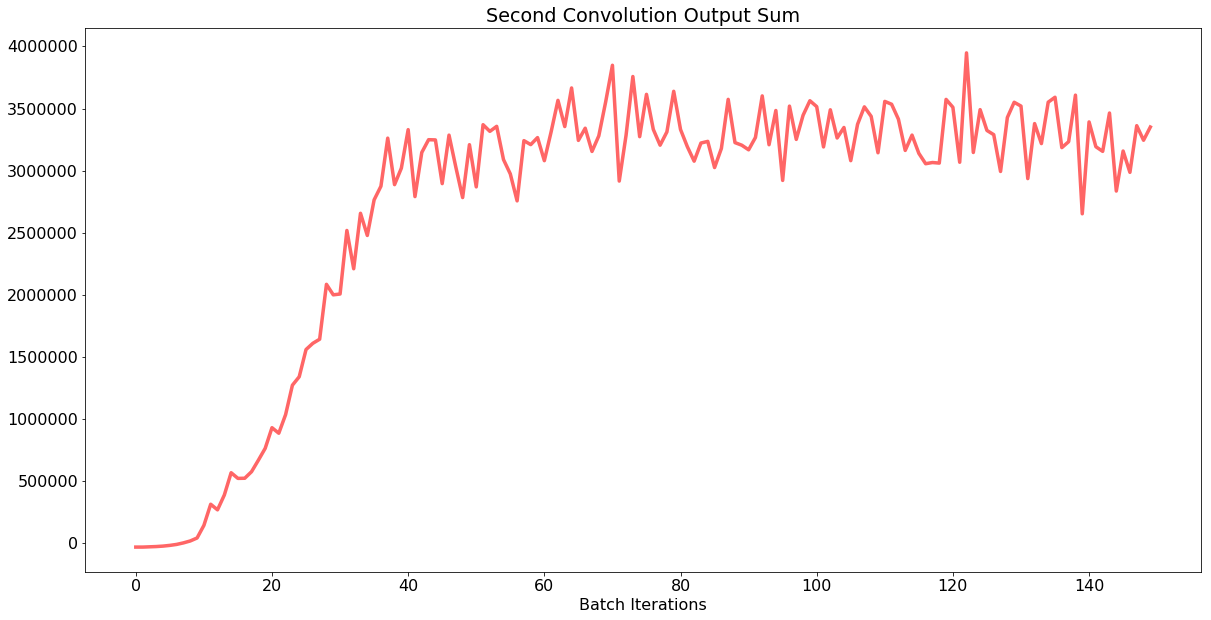

Plotting the second relu output sum


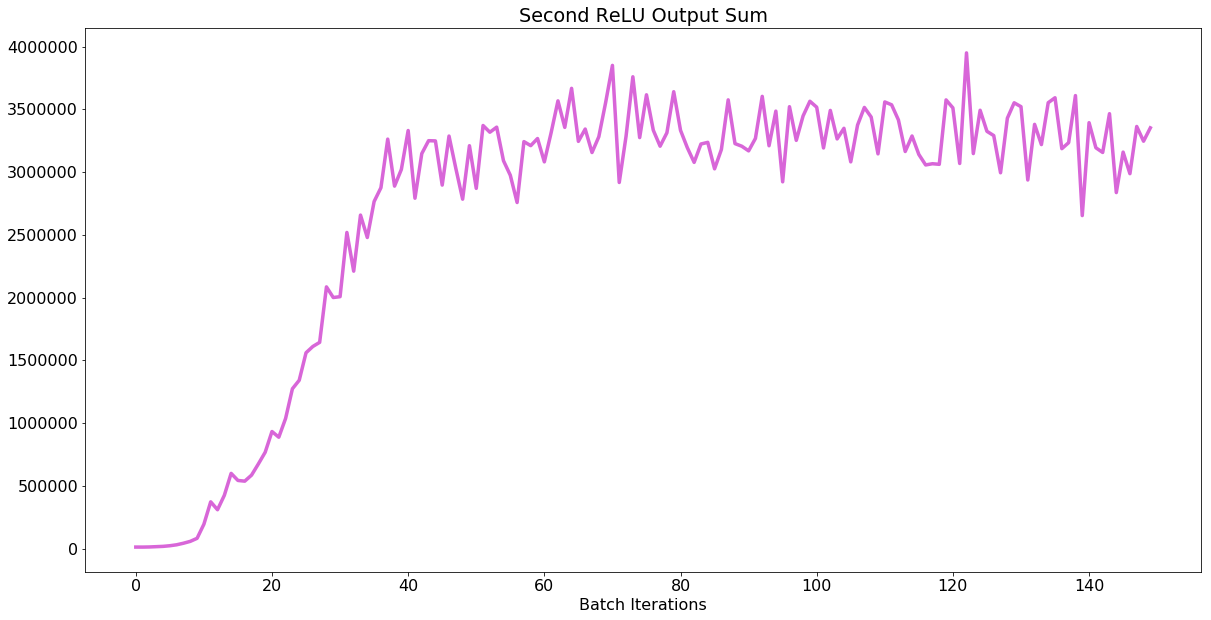

Plotting the second max unpool output sum


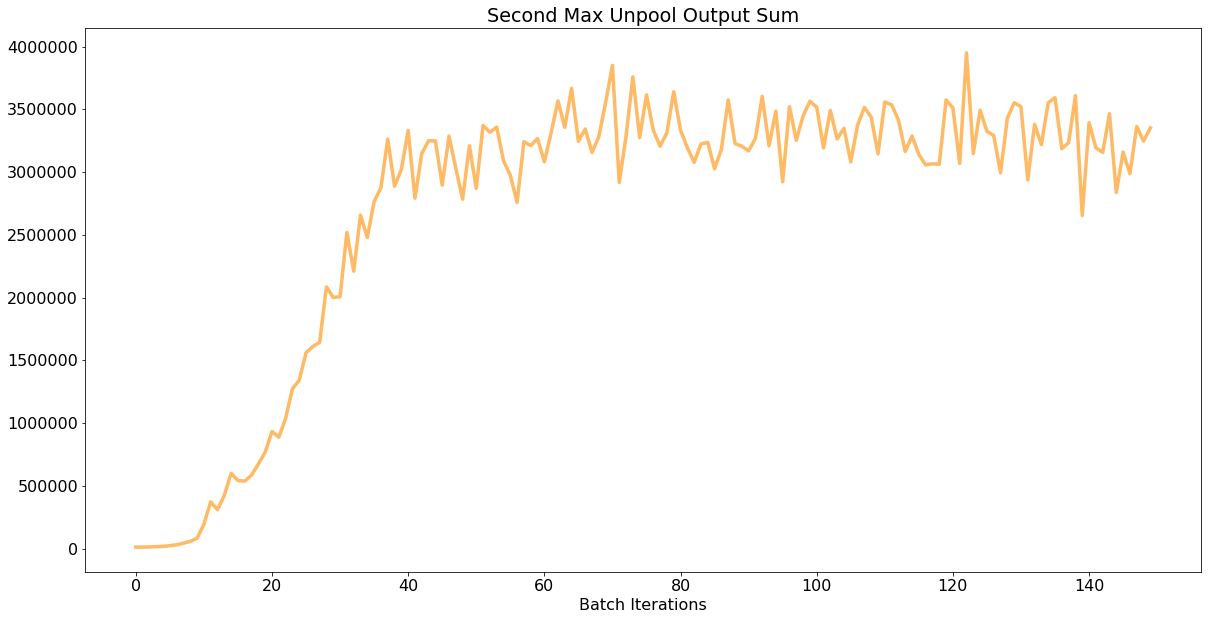

Plotting the third convolution output sum


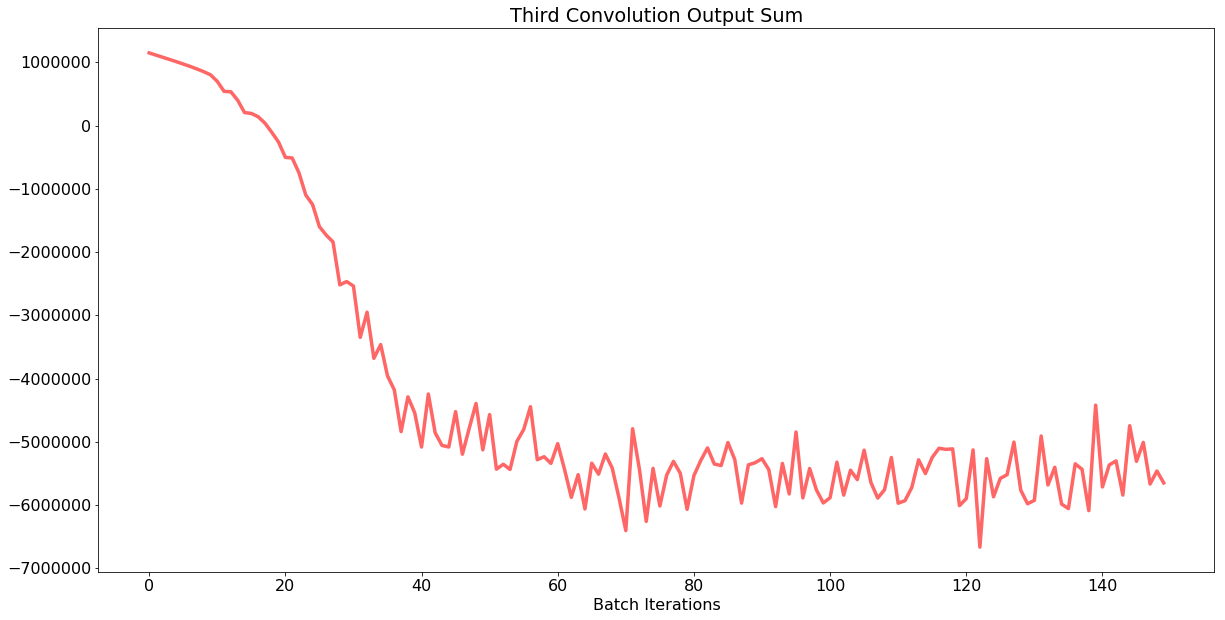

Plotting the third relu output sum


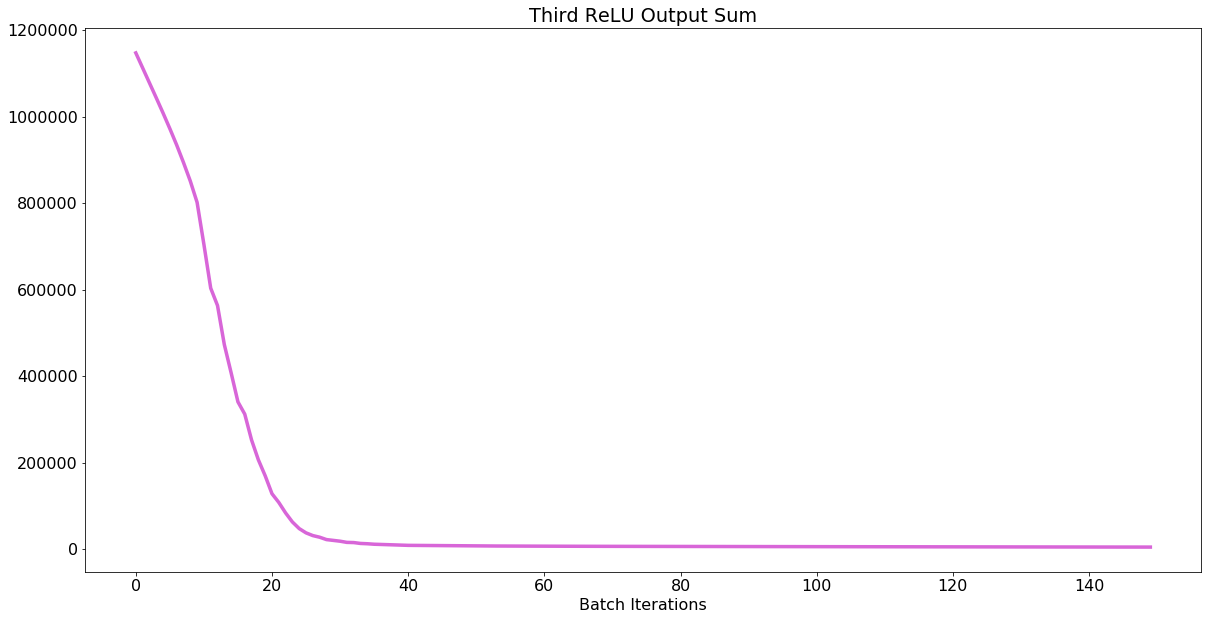

reconstructed cube = torch.Size([16, 128, 128, 128])
reconstructed cube = torch.Size([128, 128, 128])
MSE Loss = tensor(32.7260, device='cuda:0', grad_fn=<MseLossBackward>)
KLD Loss = tensor(0.1537, device='cuda:0', grad_fn=<DivBackward0>)
Train Epoch: 1 [64/256 (25%)]	Loss: 2.054979562759
Data transfer to device completed.
Starting Encoding
torch.Size([16, 2048])
Encode - Forward Pass Finished
torch.Size([16, 16])
torch.Size([16, 16])
Starting Decoding
FIRST DECODE OUT SUM = 25653.86
CONV 1 OUT SUM = 374048.9
RELU 1 OUT SUM = 374048.9
MAX UNPOOL 1 OUT SUM = 374048.88
CONV 2 OUT SUM = 3427521.8
RELU 2 OUT SUM = 3429022.0
MAX UNPOOL 2 OUT SUM = 3429019.5
CONV 3 OUT SUM = -5781716.5
RELU 3 OUT SUM = 5197.5894
data shape = torch.Size([16, 128, 128, 128])
data shape = (128, 128, 128)
Plotting the first decoder output sum
first decoder out sum = [2896.9578, 2894.755, 3238.6477, 3808.3076, 3741.1228, 4201.9287, 4773.0415, 5594.073, 6045.5674, 6948.961, 14237.286, 22334.652, 15180.516, 17629.

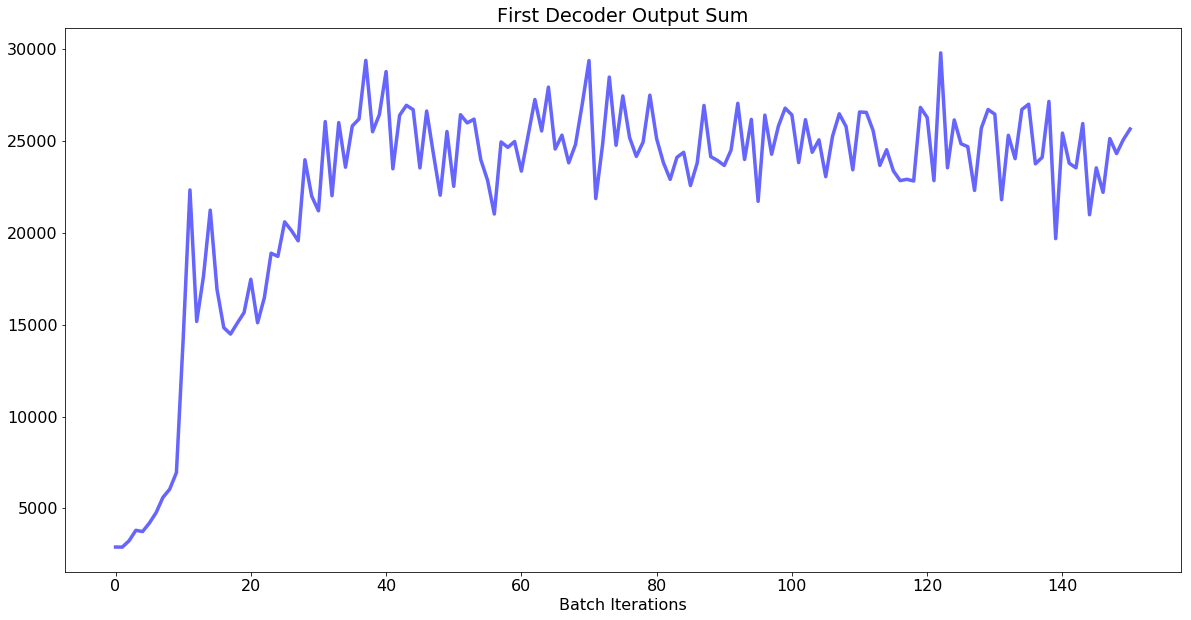

Plotting the first convolution output sum


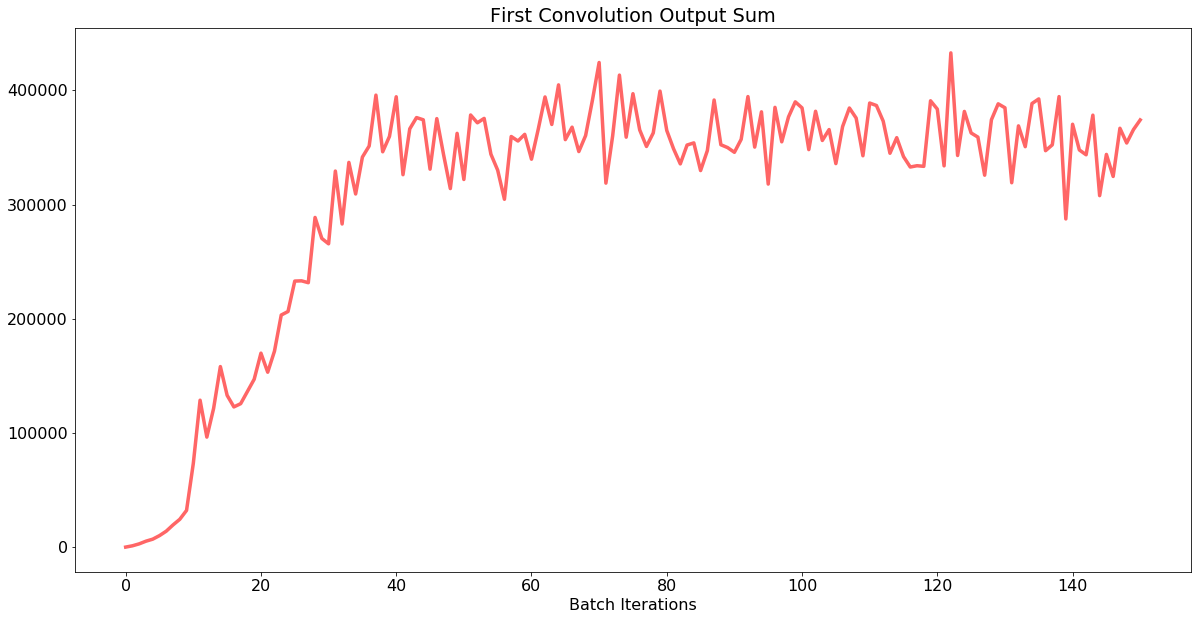

Plotting the first relu output sum


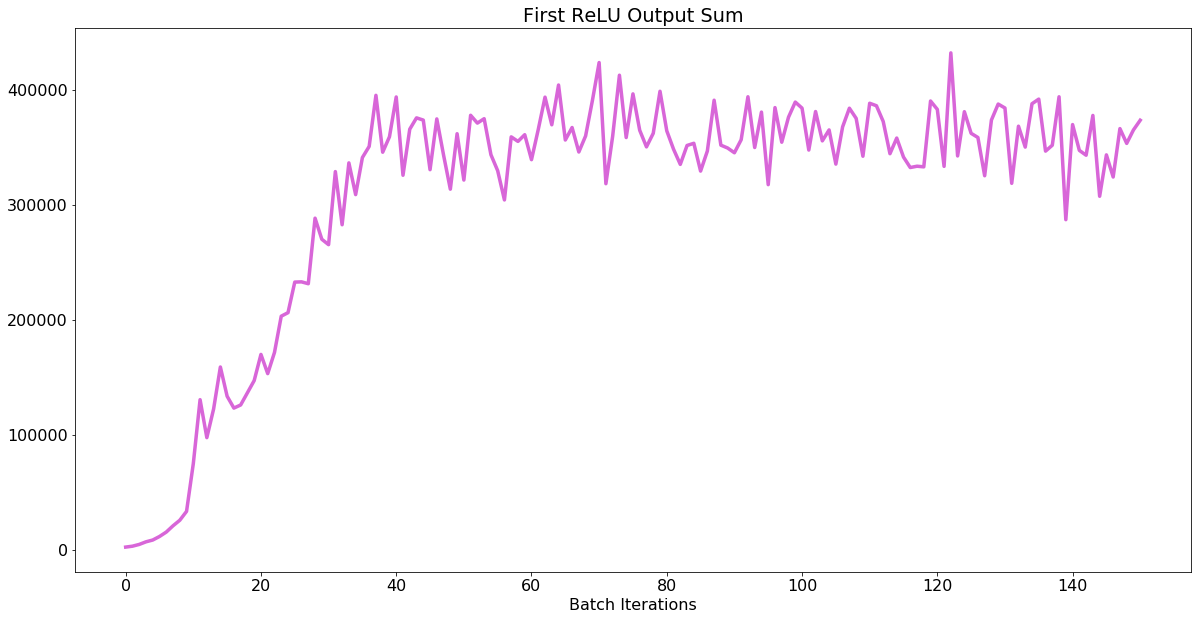

Plotting the first max unpool output sum


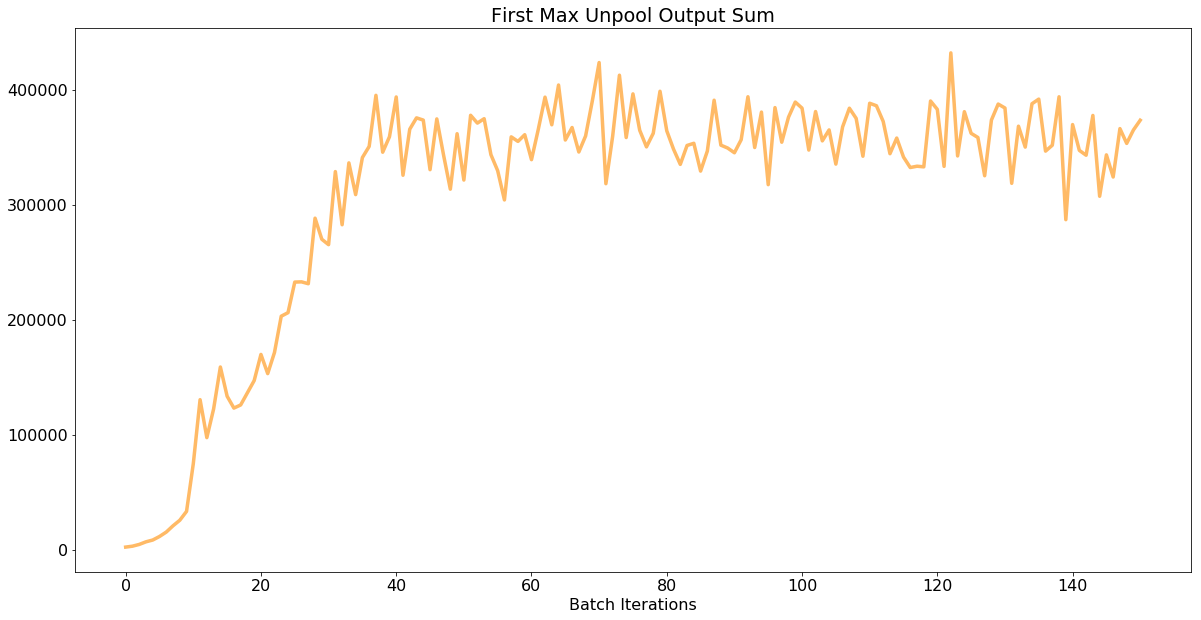

Plotting the second convolution output sum


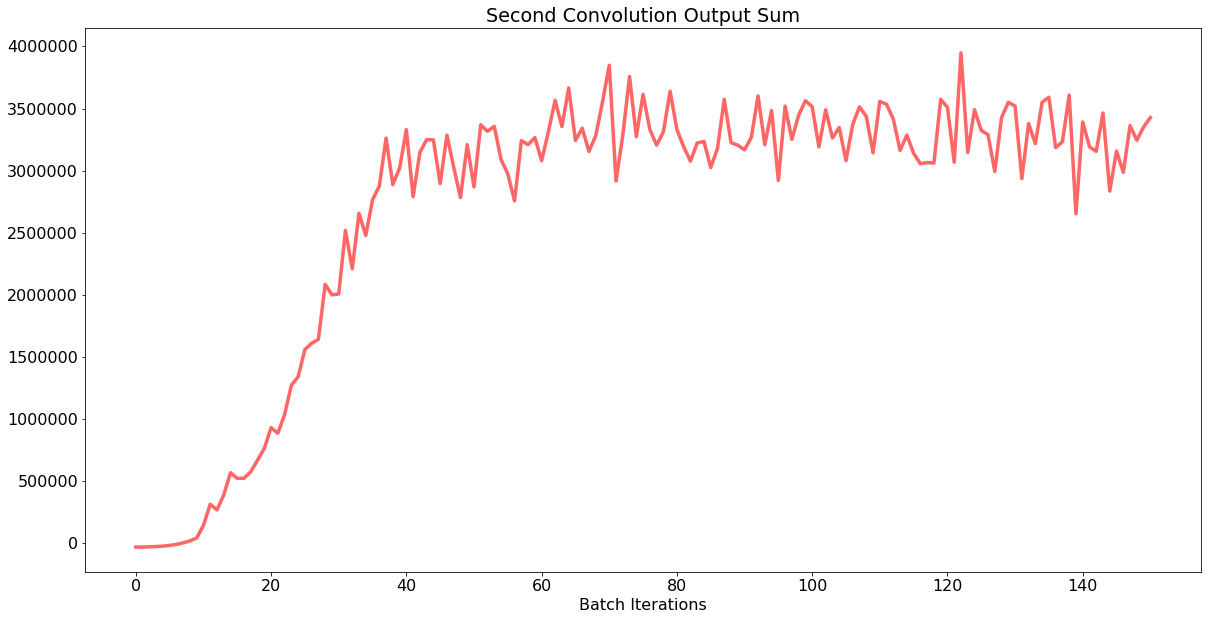

Plotting the second relu output sum


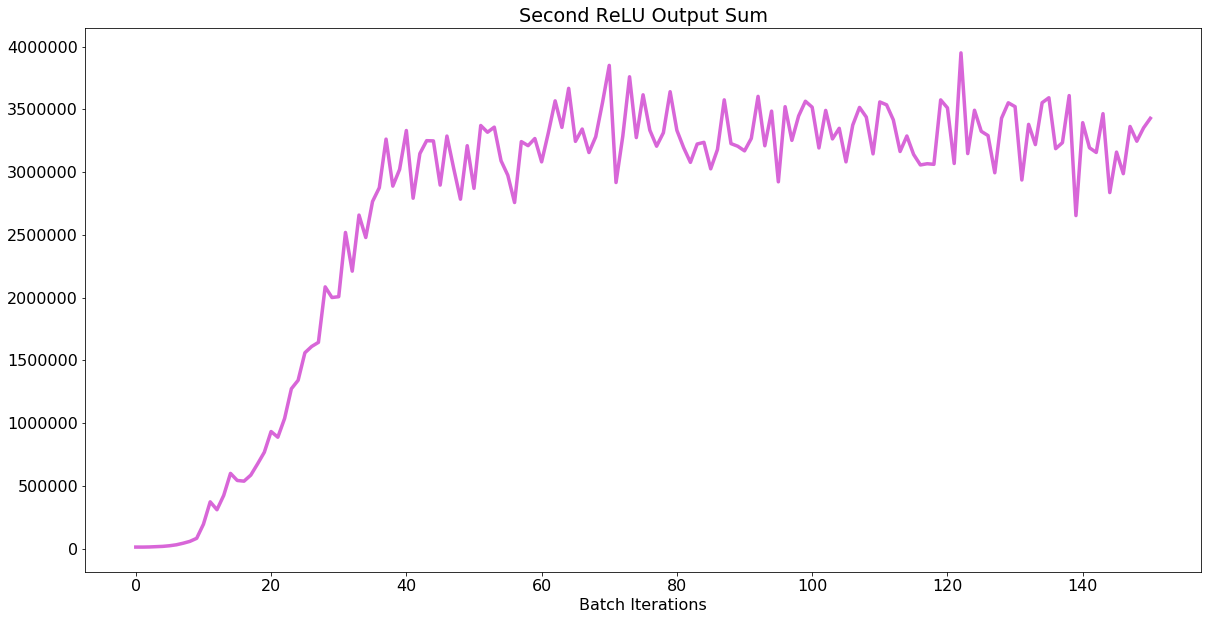

Plotting the second max unpool output sum


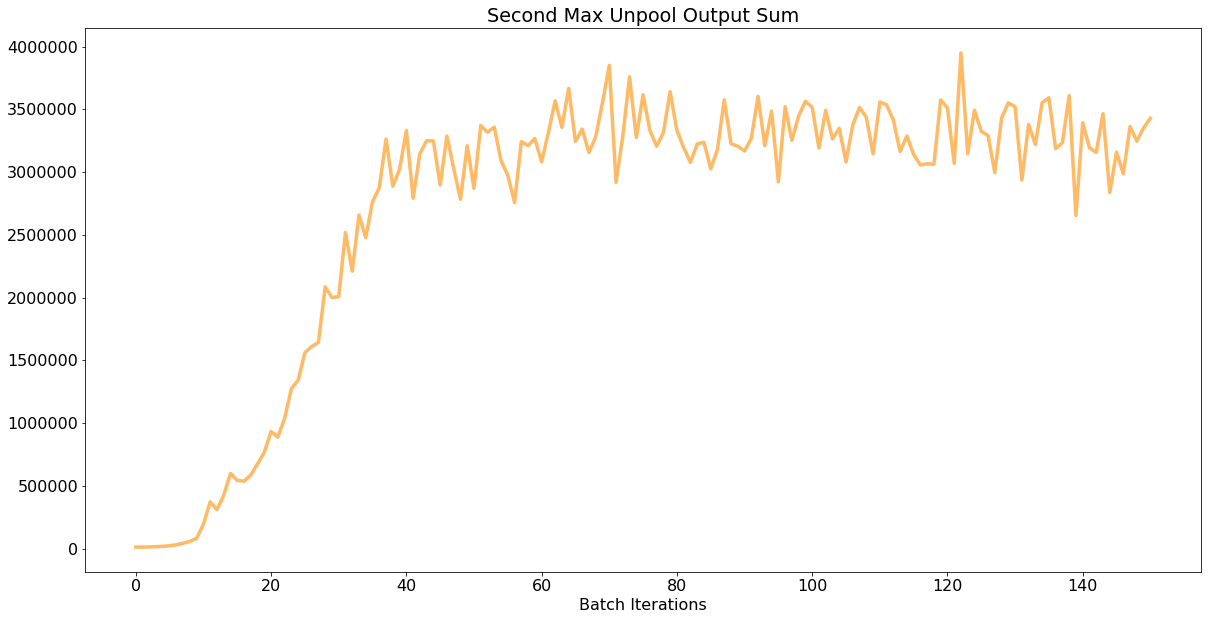

Plotting the third convolution output sum


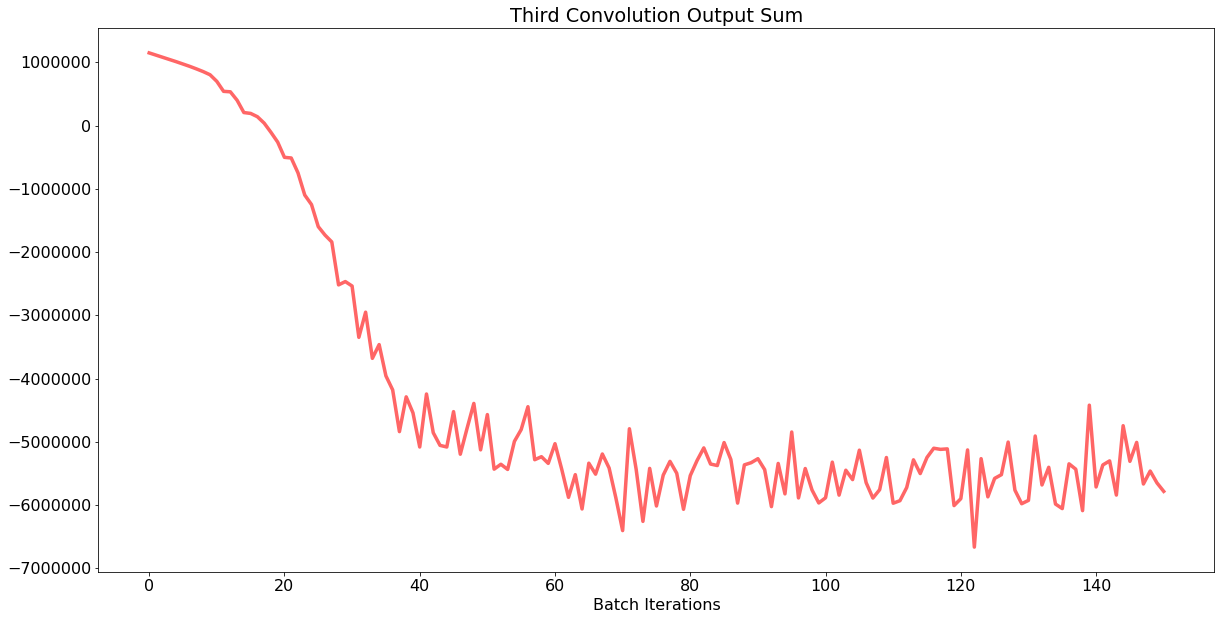

Plotting the third relu output sum


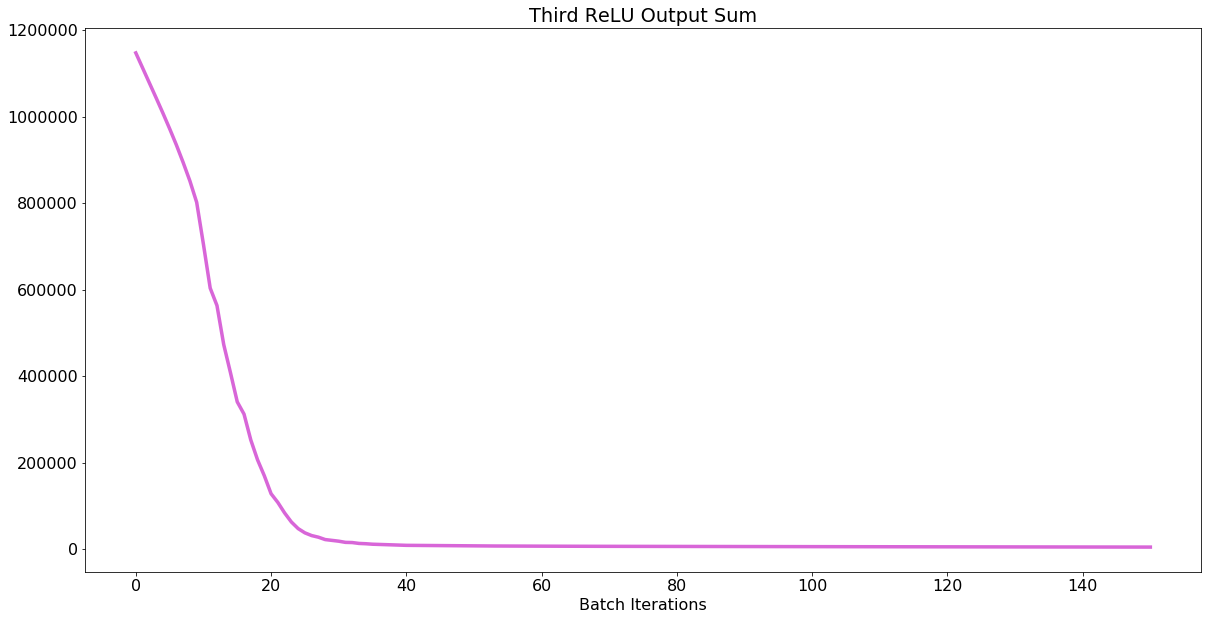

reconstructed cube = torch.Size([16, 128, 128, 128])
reconstructed cube = torch.Size([128, 128, 128])
MSE Loss = tensor(32.5924, device='cuda:0', grad_fn=<MseLossBackward>)
KLD Loss = tensor(0.1462, device='cuda:0', grad_fn=<DivBackward0>)
Train Epoch: 1 [80/256 (31%)]	Loss: 2.046166181564
Data transfer to device completed.
Starting Encoding
torch.Size([16, 2048])
Encode - Forward Pass Finished
torch.Size([16, 16])
torch.Size([16, 16])
Starting Decoding
FIRST DECODE OUT SUM = 26089.758
CONV 1 OUT SUM = 379792.56
RELU 1 OUT SUM = 379792.56
MAX UNPOOL 1 OUT SUM = 379792.66
CONV 2 OUT SUM = 3478416.0
RELU 2 OUT SUM = 3479954.2
MAX UNPOOL 2 OUT SUM = 3479953.8
CONV 3 OUT SUM = -5871473.0
RELU 3 OUT SUM = 5197.8403
data shape = torch.Size([16, 128, 128, 128])
data shape = (128, 128, 128)
Plotting the first decoder output sum
first decoder out sum = [2896.9578, 2894.755, 3238.6477, 3808.3076, 3741.1228, 4201.9287, 4773.0415, 5594.073, 6045.5674, 6948.961, 14237.286, 22334.652, 15180.516, 176

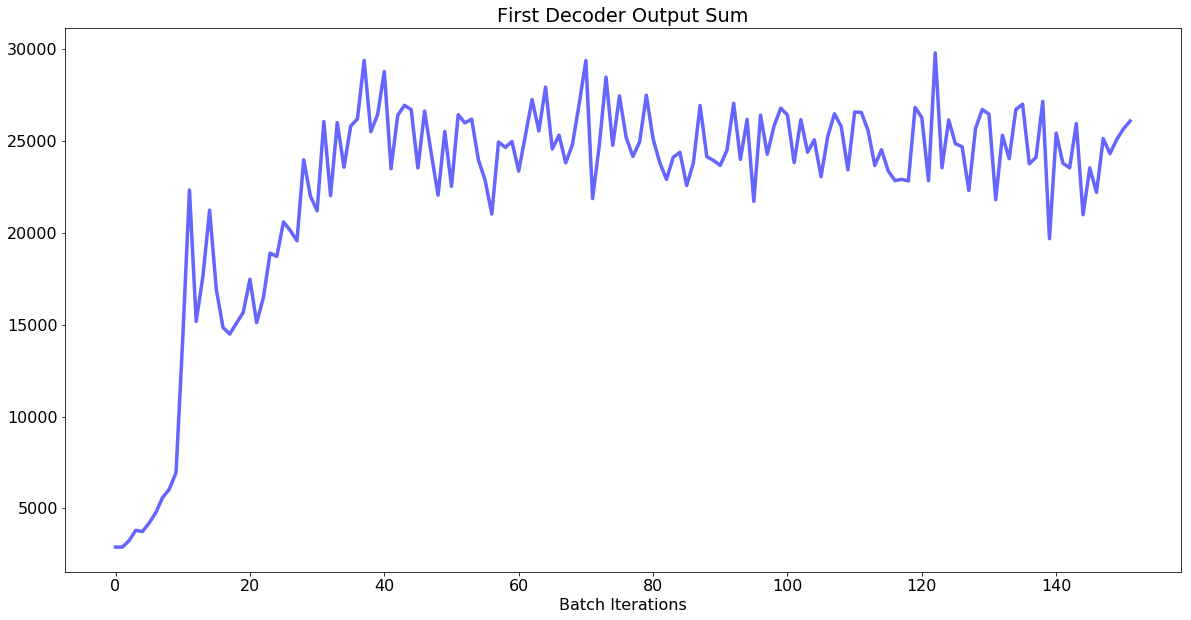

Plotting the first convolution output sum


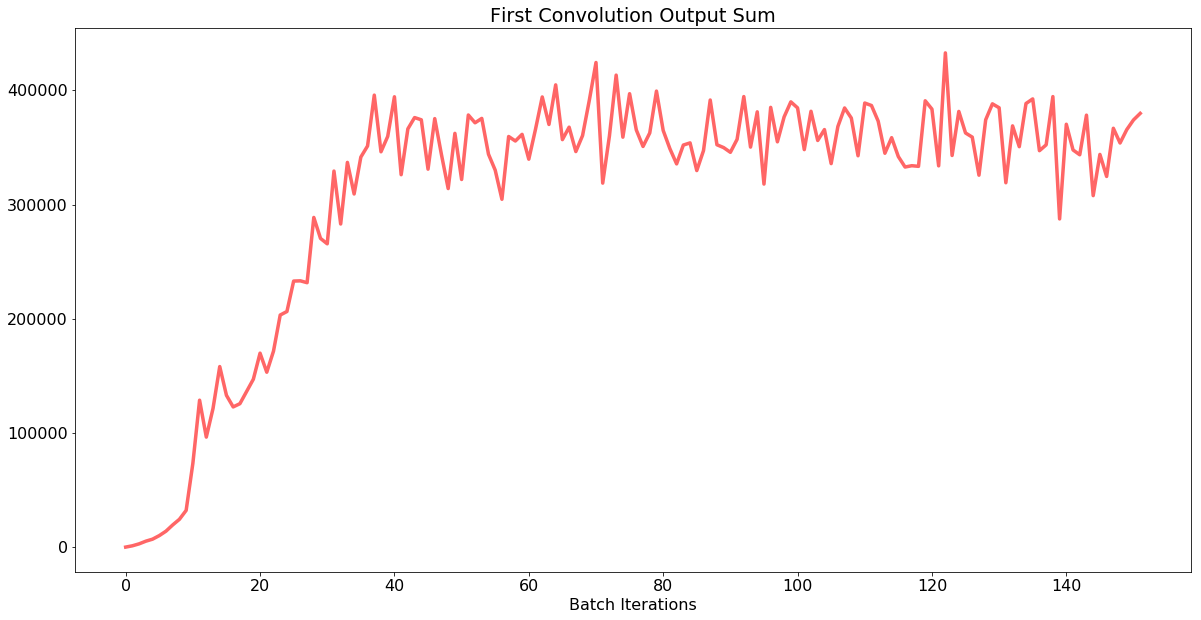

Plotting the first relu output sum


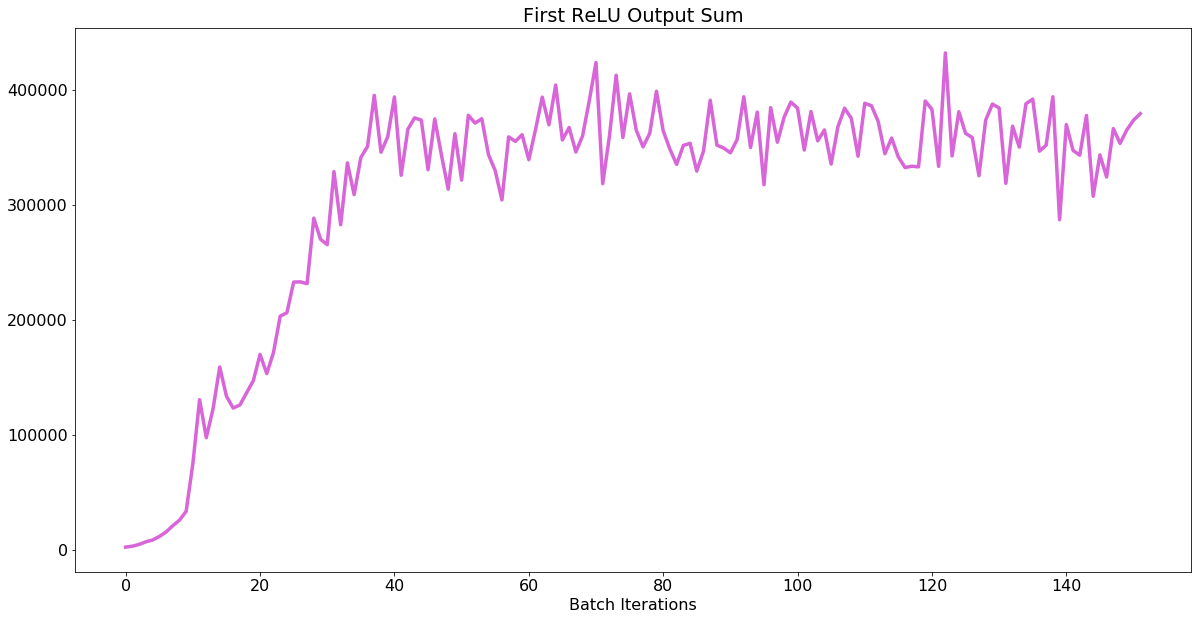

Plotting the first max unpool output sum


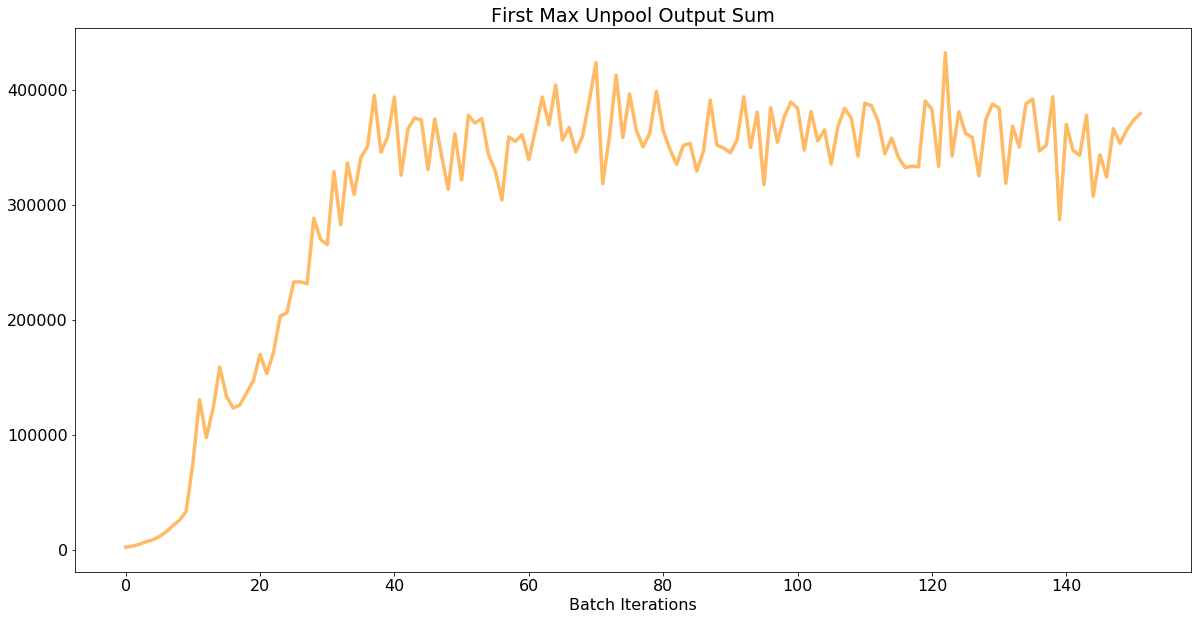

Plotting the second convolution output sum


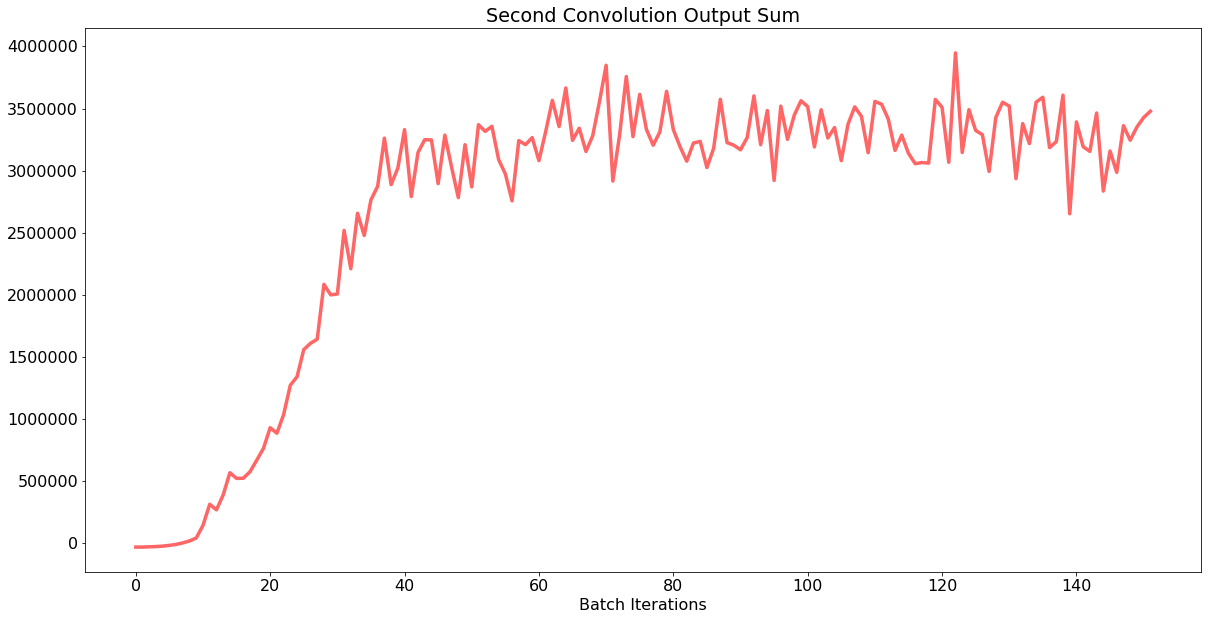

Plotting the second relu output sum


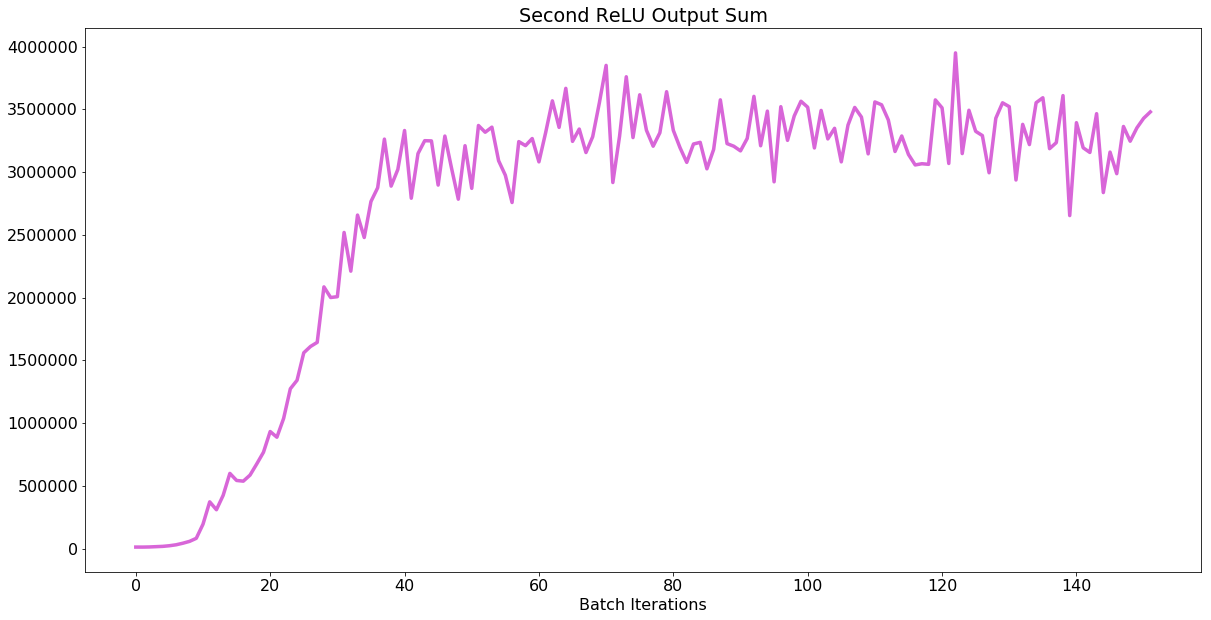

Plotting the second max unpool output sum


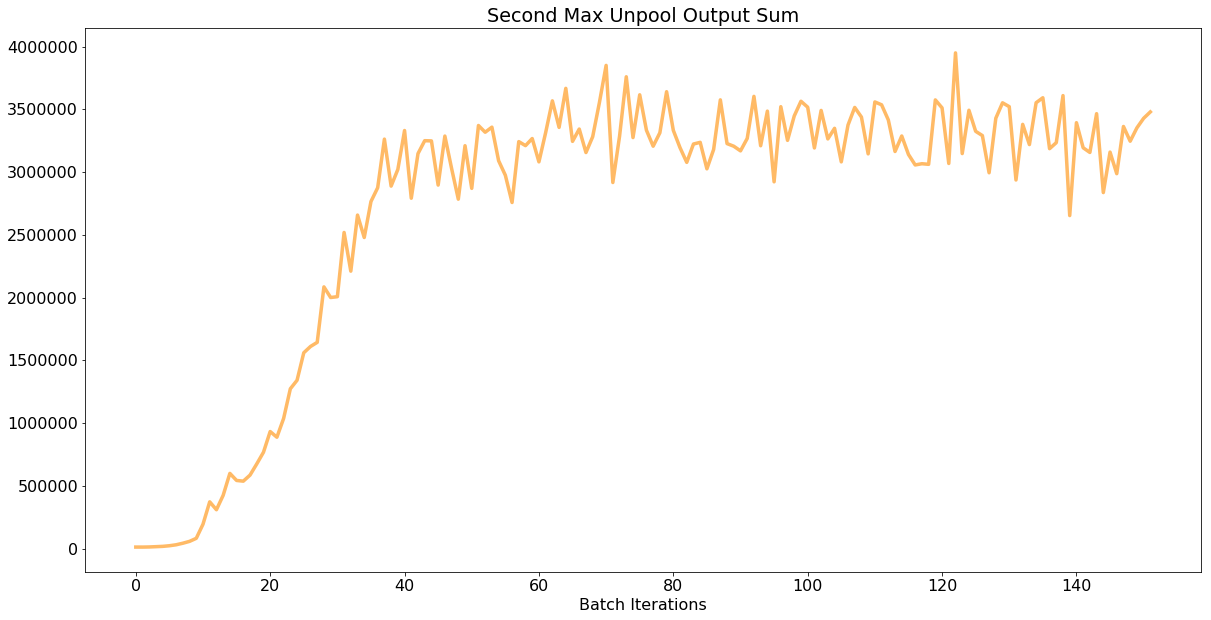

Plotting the third convolution output sum


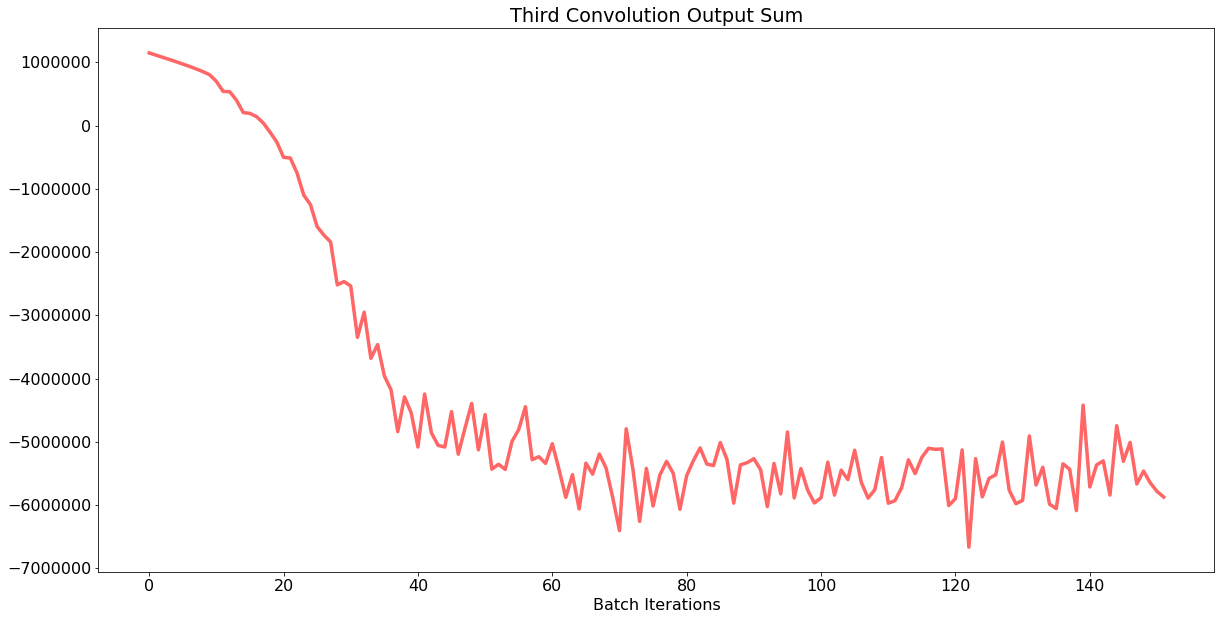

Plotting the third relu output sum


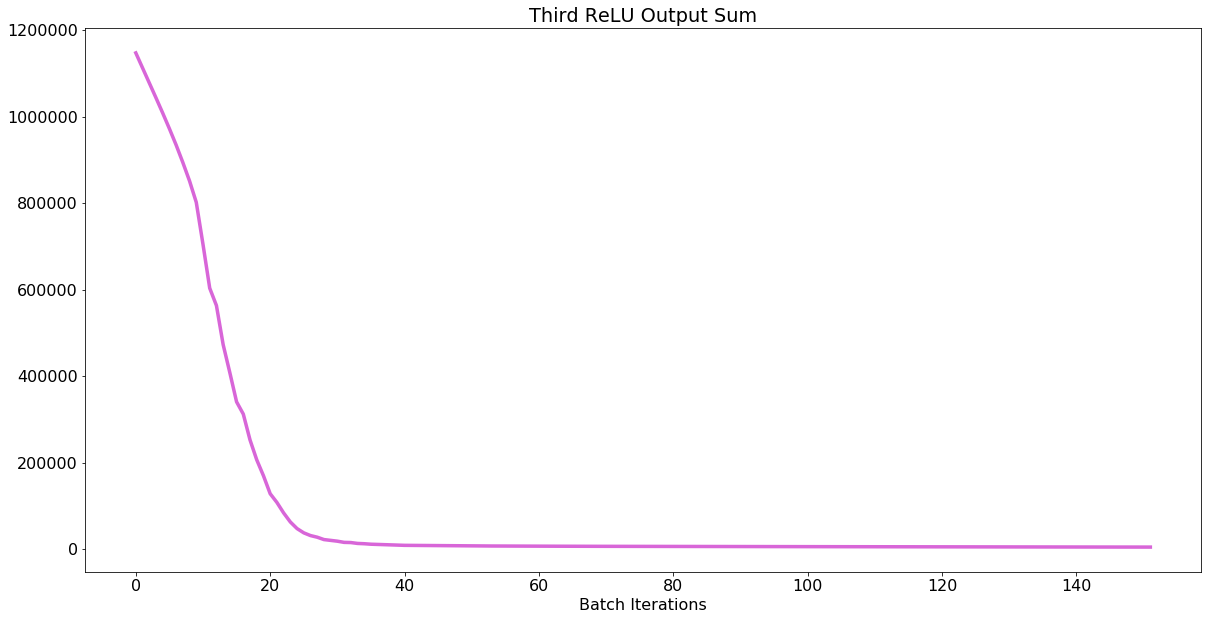

reconstructed cube = torch.Size([16, 128, 128, 128])
reconstructed cube = torch.Size([128, 128, 128])
MSE Loss = tensor(33.5650, device='cuda:0', grad_fn=<MseLossBackward>)
KLD Loss = tensor(0.1372, device='cuda:0', grad_fn=<DivBackward0>)
Train Epoch: 1 [96/256 (38%)]	Loss: 2.106389522552
Data transfer to device completed.
Starting Encoding
torch.Size([16, 2048])
Encode - Forward Pass Finished
torch.Size([16, 16])
torch.Size([16, 16])
Starting Decoding
FIRST DECODE OUT SUM = 20884.74
CONV 1 OUT SUM = 305742.72
RELU 1 OUT SUM = 305742.72
MAX UNPOOL 1 OUT SUM = 305742.66
CONV 2 OUT SUM = 2818904.2
RELU 2 OUT SUM = 2820072.2
MAX UNPOOL 2 OUT SUM = 2820068.5
CONV 3 OUT SUM = -4720776.5
RELU 3 OUT SUM = 5169.7876
data shape = torch.Size([16, 128, 128, 128])
data shape = (128, 128, 128)
Plotting the first decoder output sum
first decoder out sum = [2896.9578, 2894.755, 3238.6477, 3808.3076, 3741.1228, 4201.9287, 4773.0415, 5594.073, 6045.5674, 6948.961, 14237.286, 22334.652, 15180.516, 1762

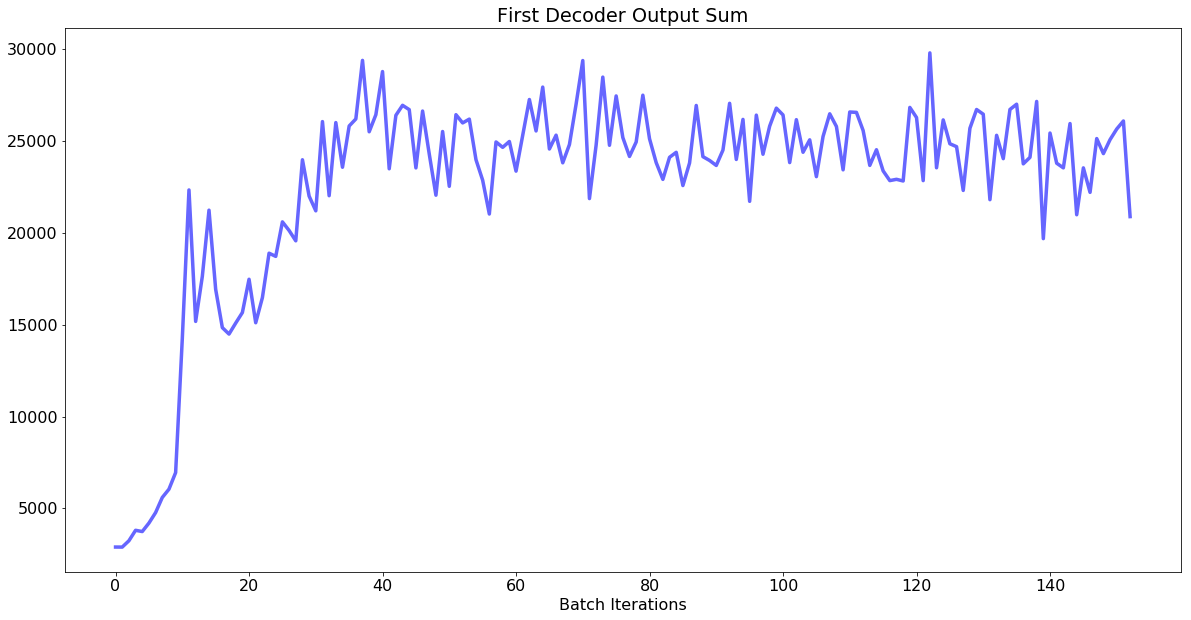

Plotting the first convolution output sum


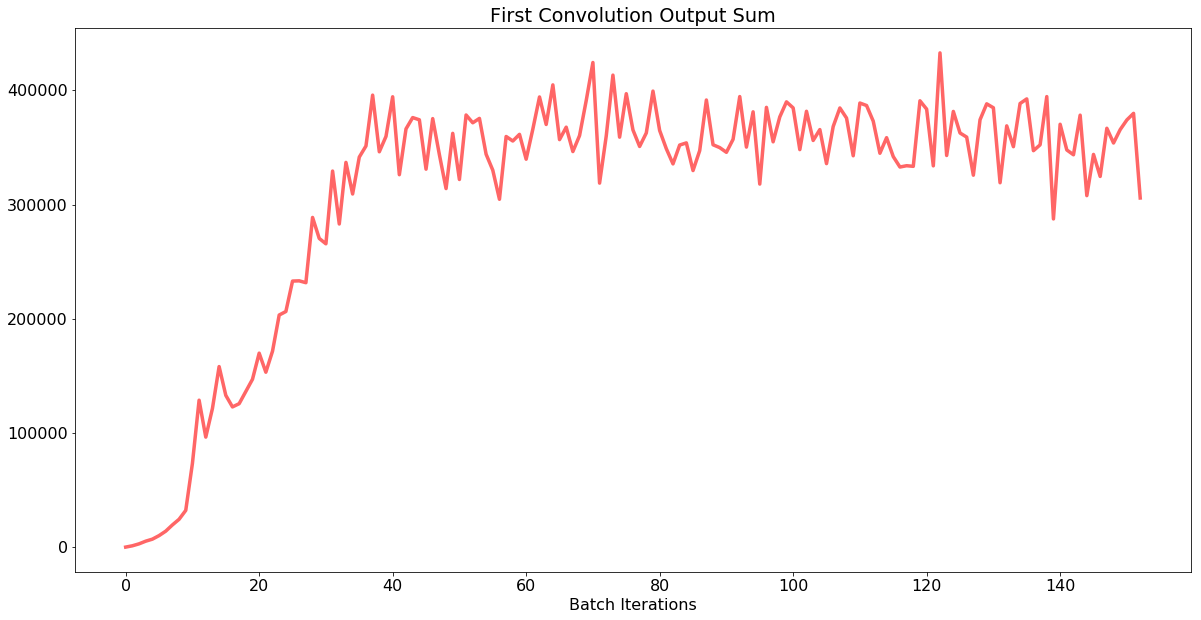

Plotting the first relu output sum


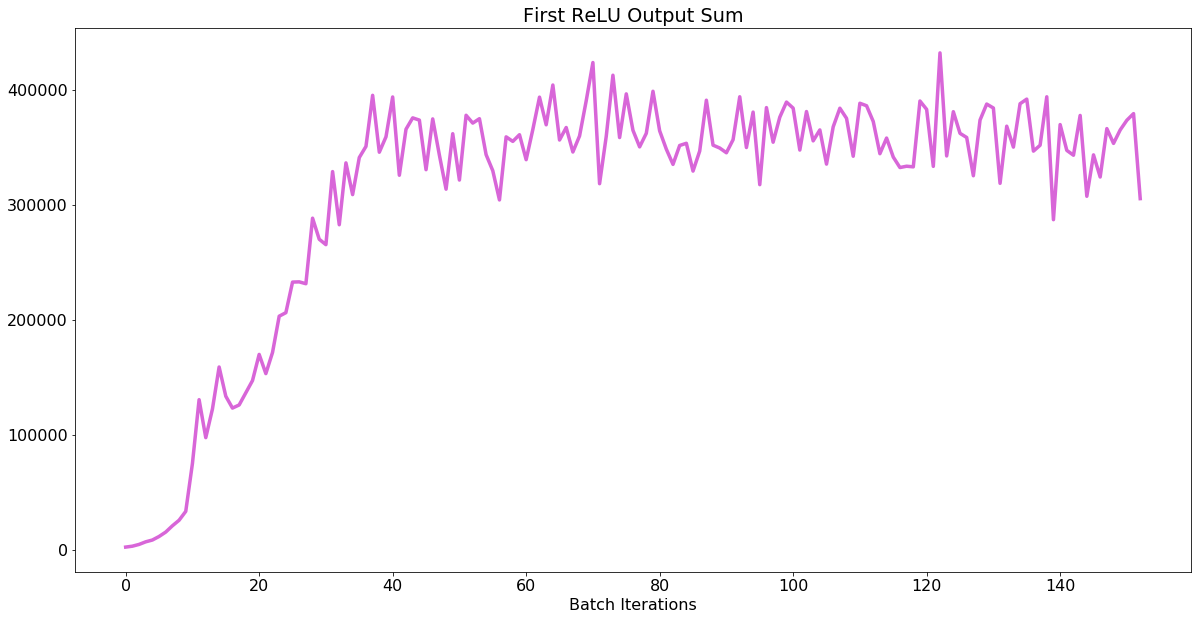

Plotting the first max unpool output sum


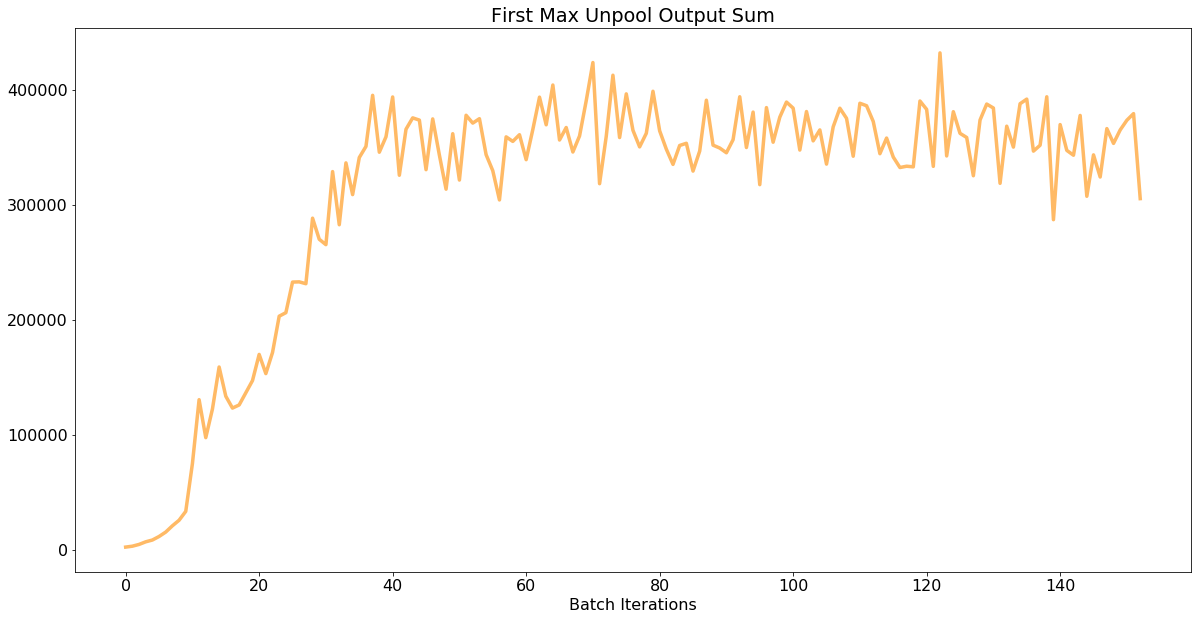

Plotting the second convolution output sum


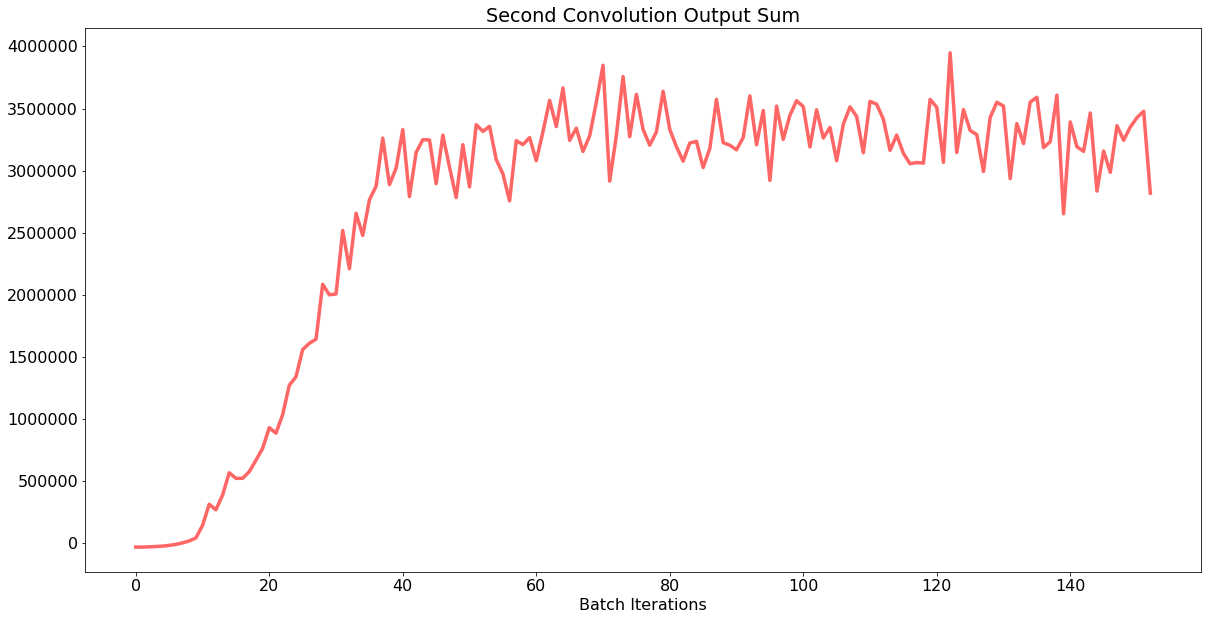

Plotting the second relu output sum


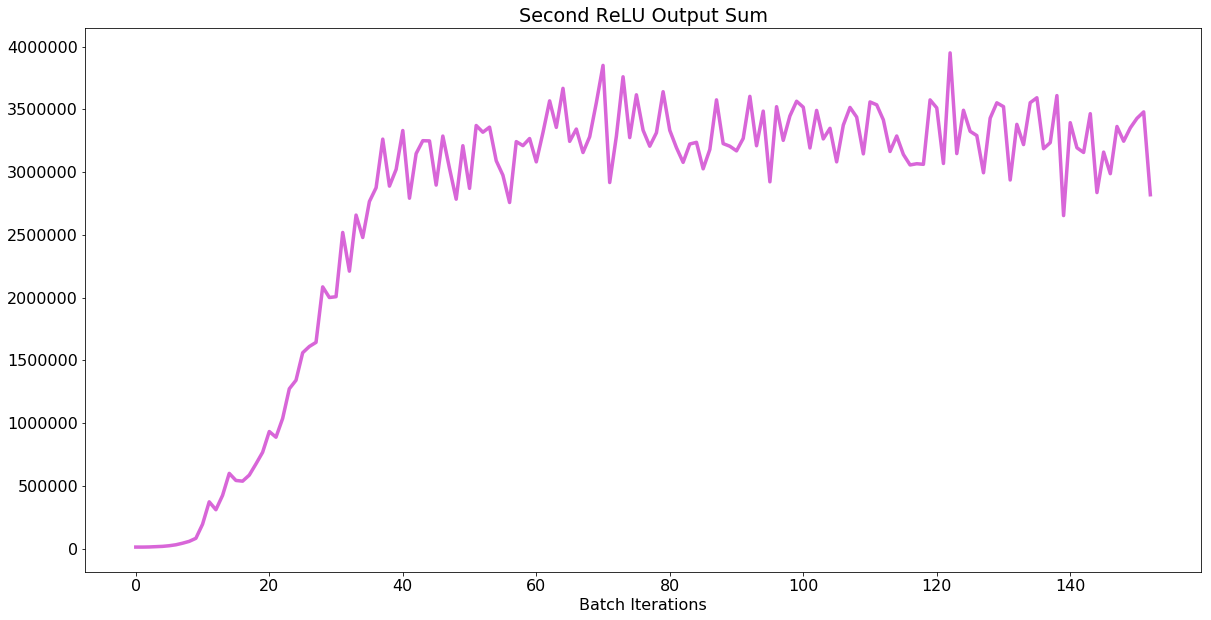

Plotting the second max unpool output sum


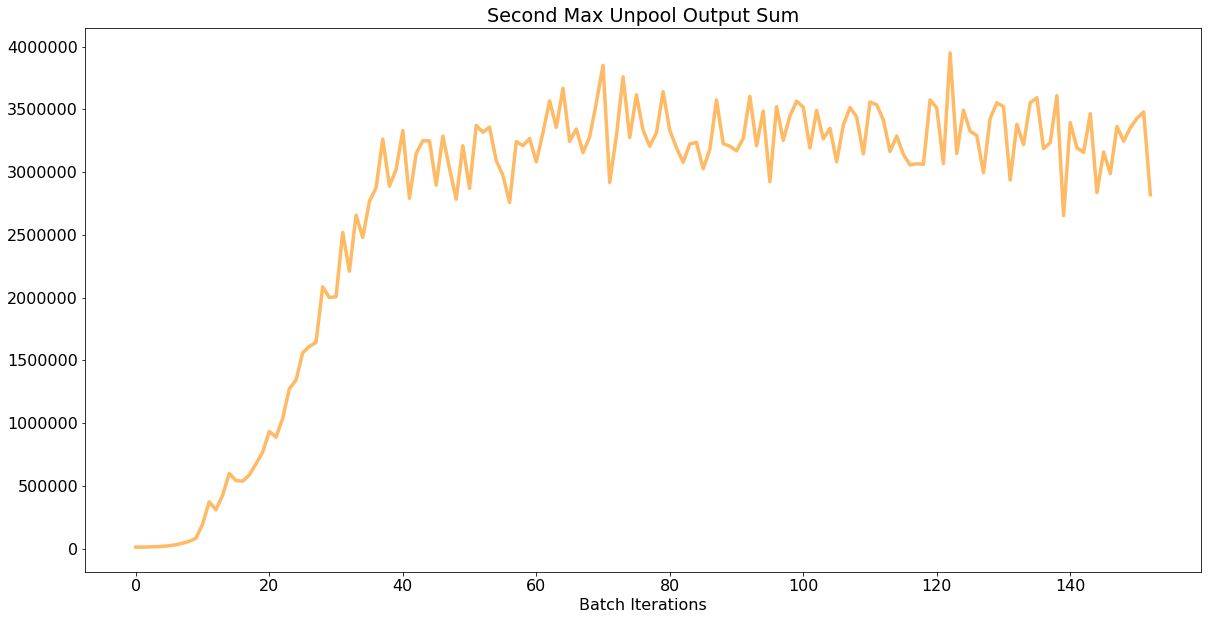

Plotting the third convolution output sum


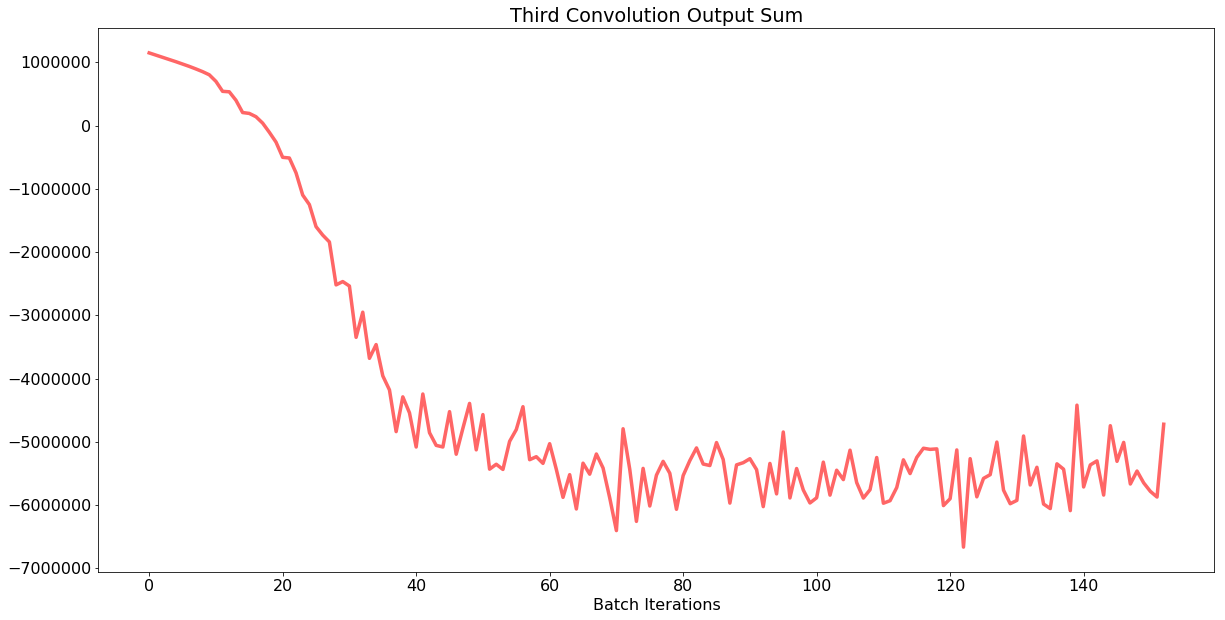

Plotting the third relu output sum


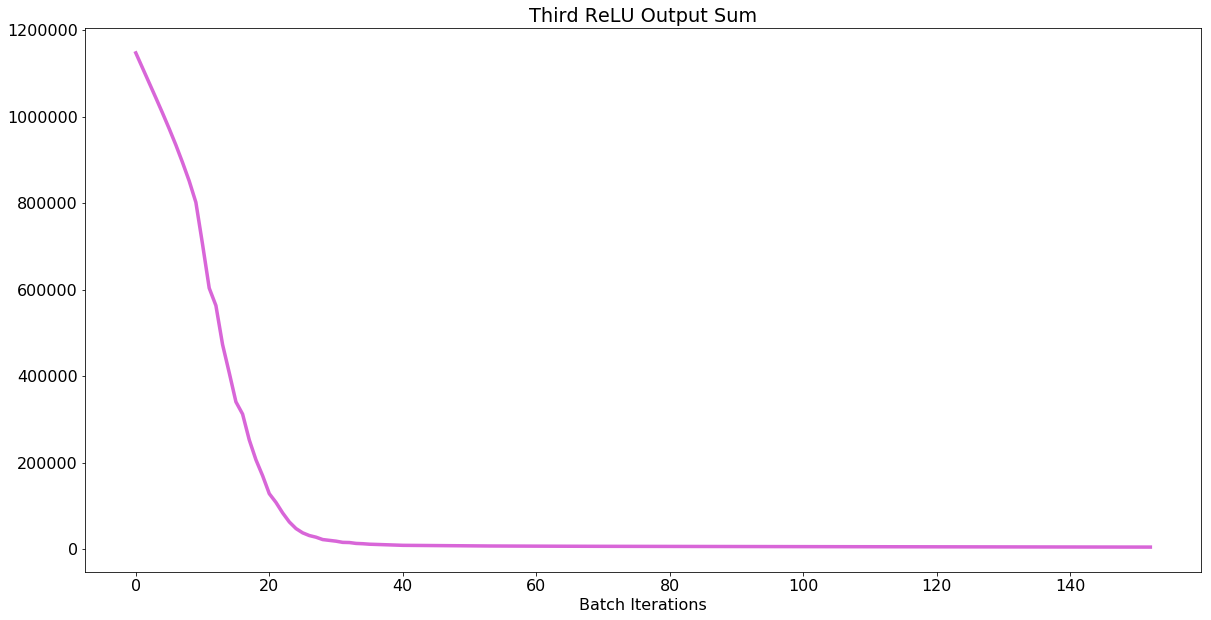

reconstructed cube = torch.Size([16, 128, 128, 128])
reconstructed cube = torch.Size([128, 128, 128])
MSE Loss = tensor(33.2005, device='cuda:0', grad_fn=<MseLossBackward>)
KLD Loss = tensor(0.1444, device='cuda:0', grad_fn=<DivBackward0>)
Train Epoch: 1 [112/256 (44%)]	Loss: 2.084057092667
Data transfer to device completed.
Starting Encoding
torch.Size([16, 2048])
Encode - Forward Pass Finished
torch.Size([16, 16])
torch.Size([16, 16])
Starting Decoding
FIRST DECODE OUT SUM = 23898.0
CONV 1 OUT SUM = 349653.53
RELU 1 OUT SUM = 349653.53
MAX UNPOOL 1 OUT SUM = 349653.6
CONV 2 OUT SUM = 3210933.8
RELU 2 OUT SUM = 3212302.8
MAX UNPOOL 2 OUT SUM = 3212295.0
CONV 3 OUT SUM = -5406381.5
RELU 3 OUT SUM = 5156.9805
data shape = torch.Size([16, 128, 128, 128])
data shape = (128, 128, 128)
Plotting the first decoder output sum
first decoder out sum = [2896.9578, 2894.755, 3238.6477, 3808.3076, 3741.1228, 4201.9287, 4773.0415, 5594.073, 6045.5674, 6948.961, 14237.286, 22334.652, 15180.516, 17629

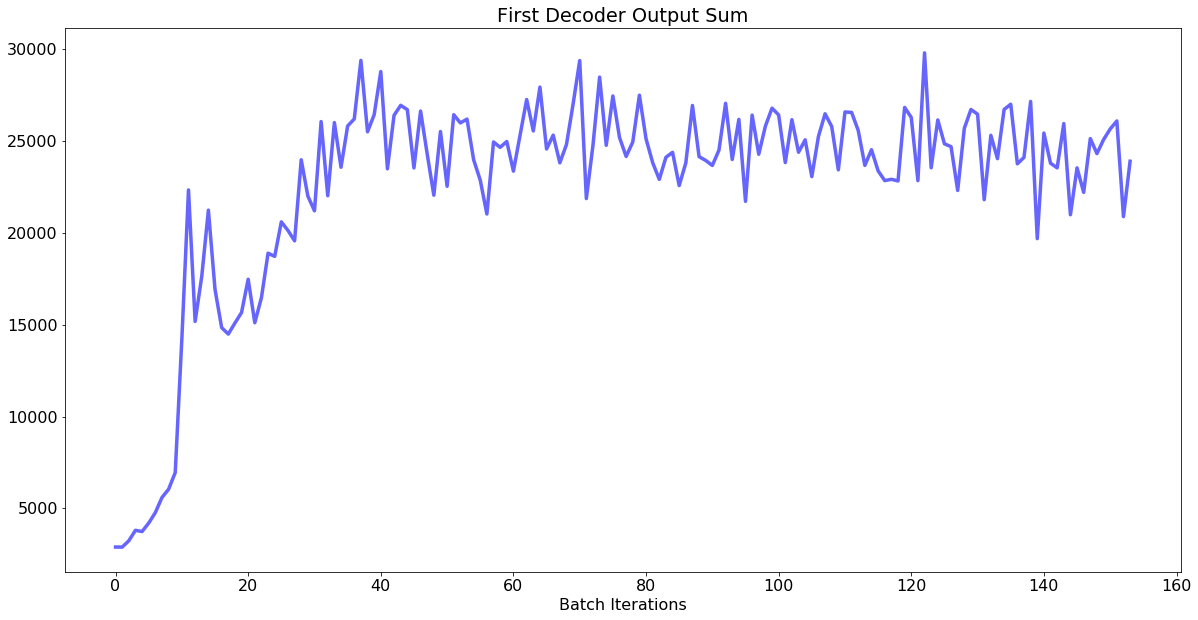

Plotting the first convolution output sum


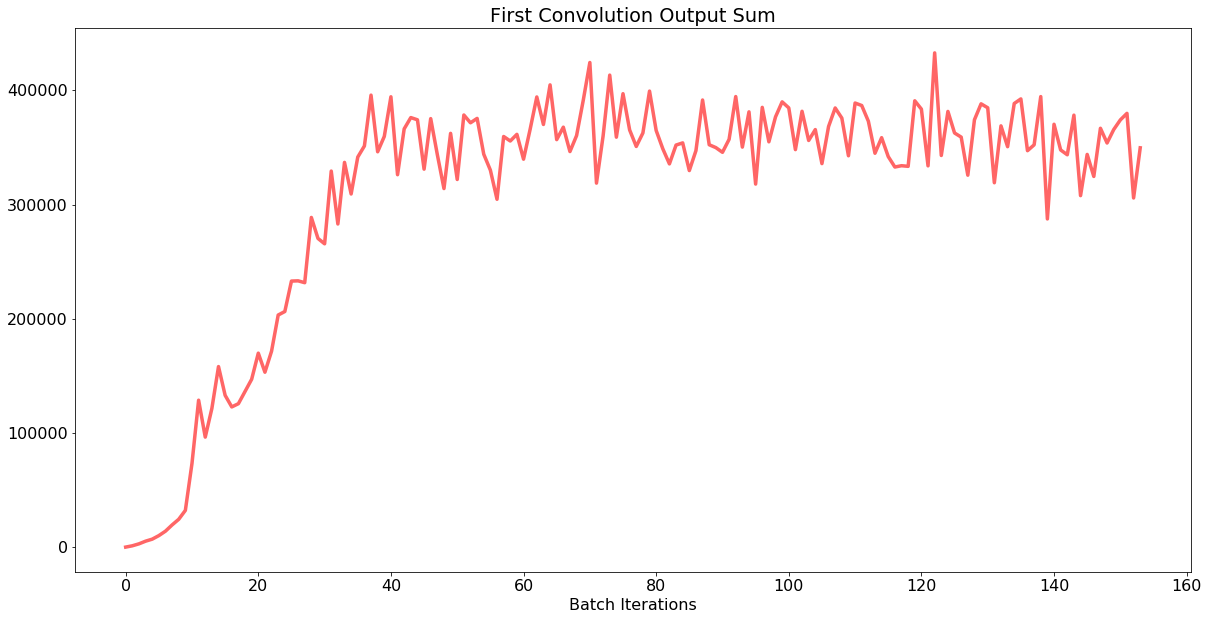

Plotting the first relu output sum


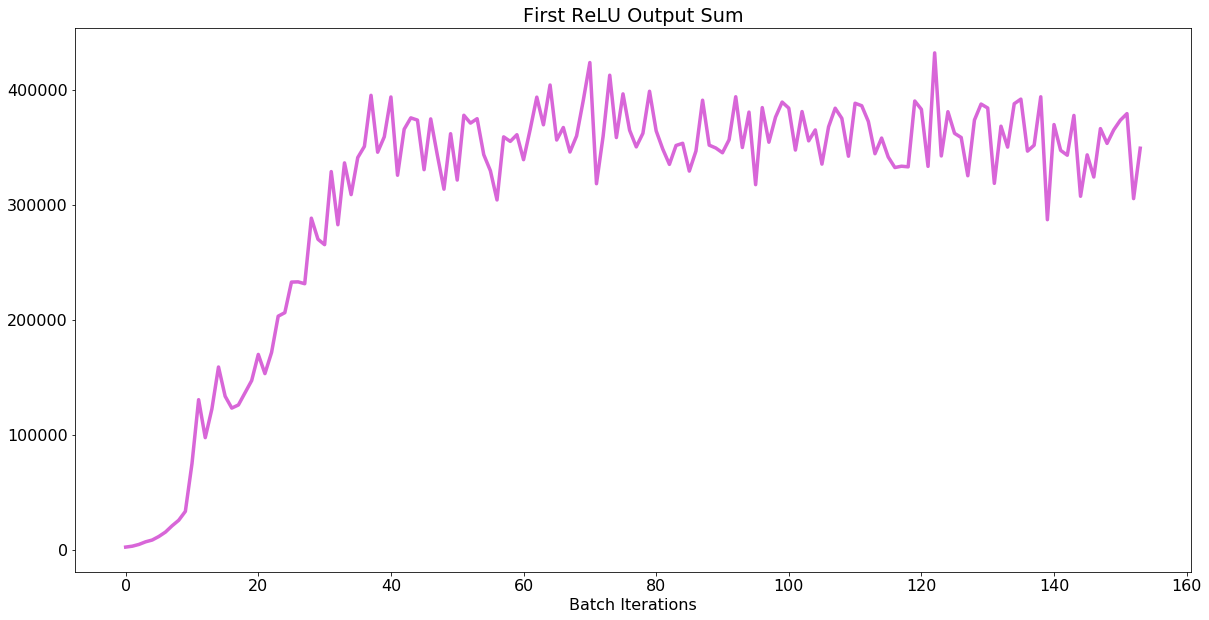

Plotting the first max unpool output sum


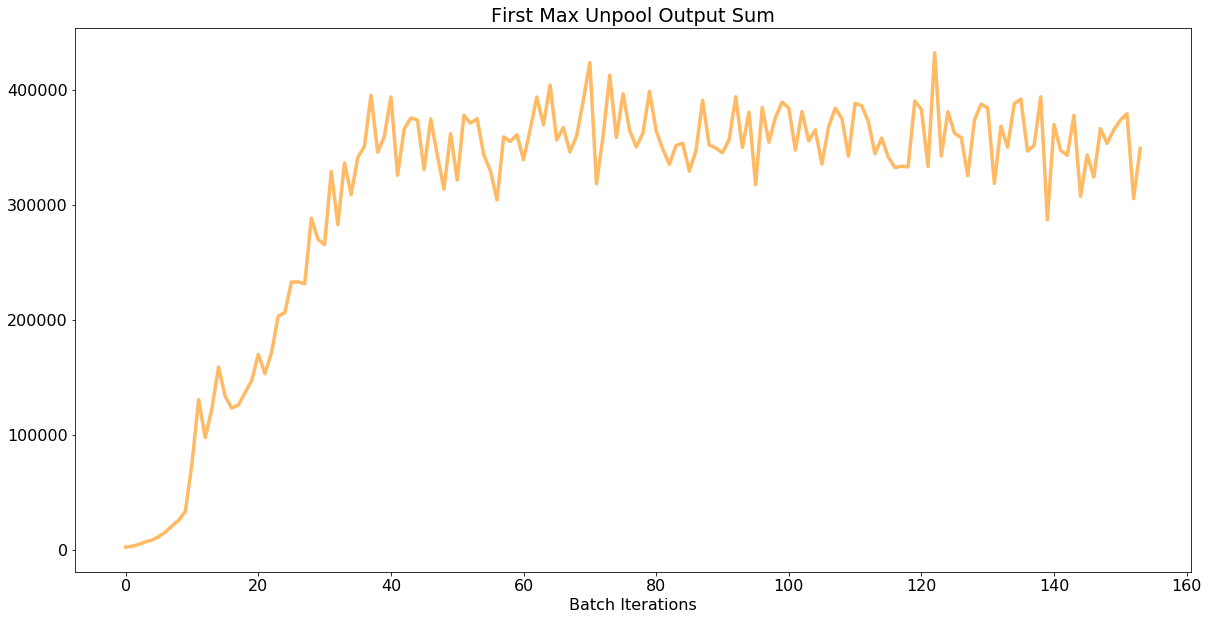

Plotting the second convolution output sum


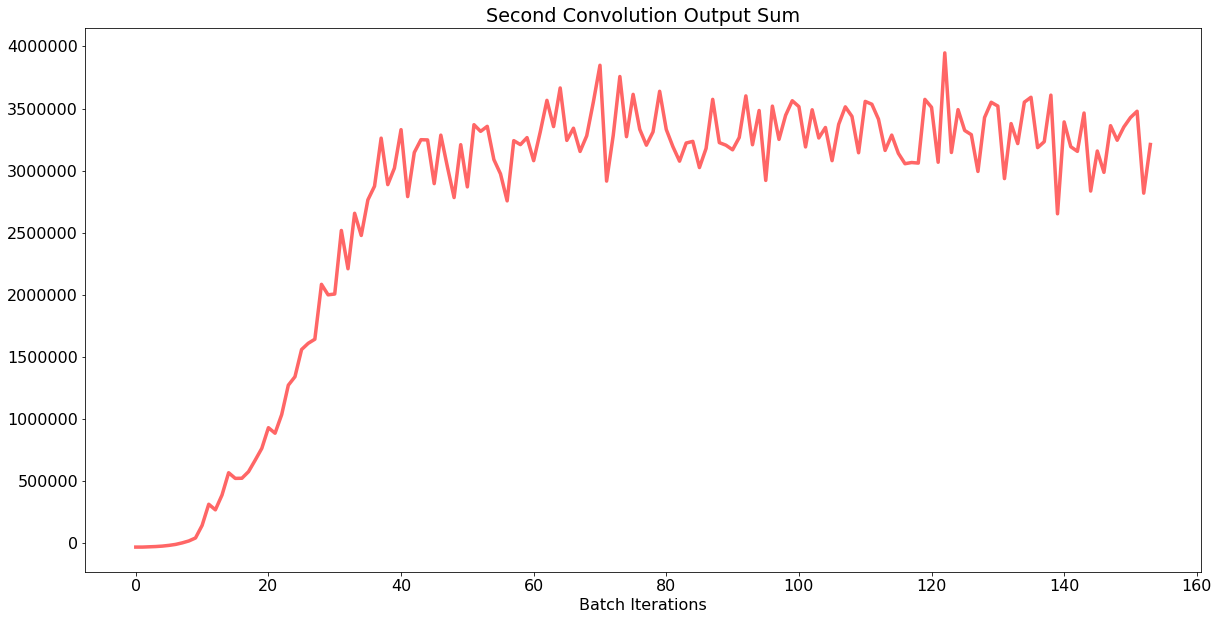

Plotting the second relu output sum


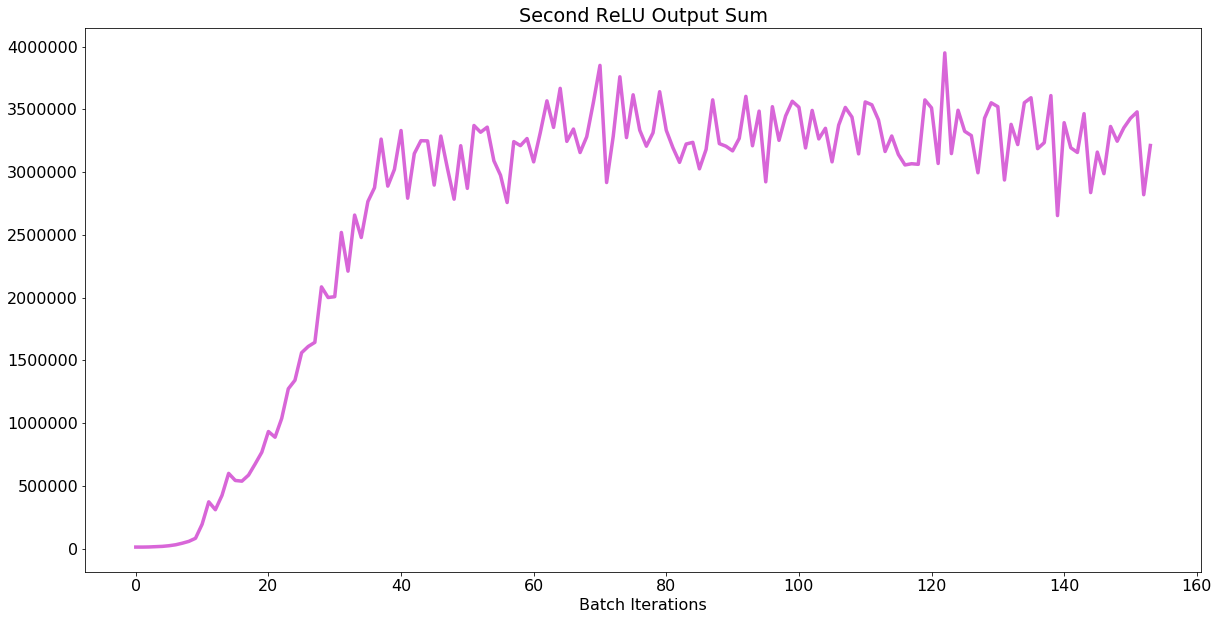

Plotting the second max unpool output sum


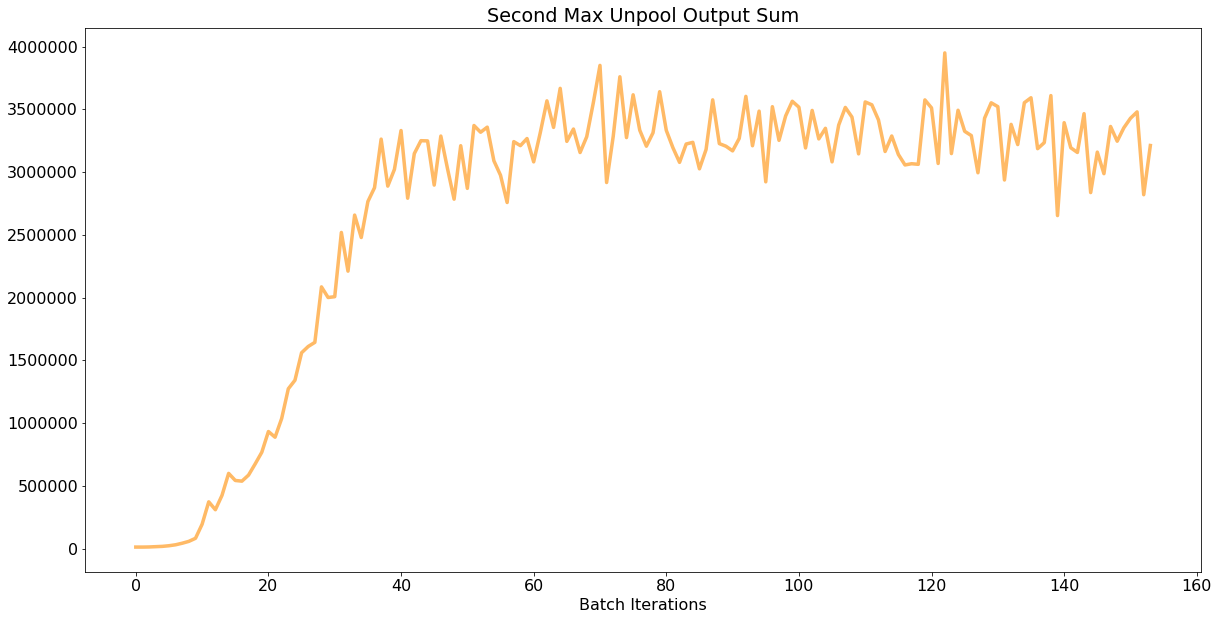

Plotting the third convolution output sum


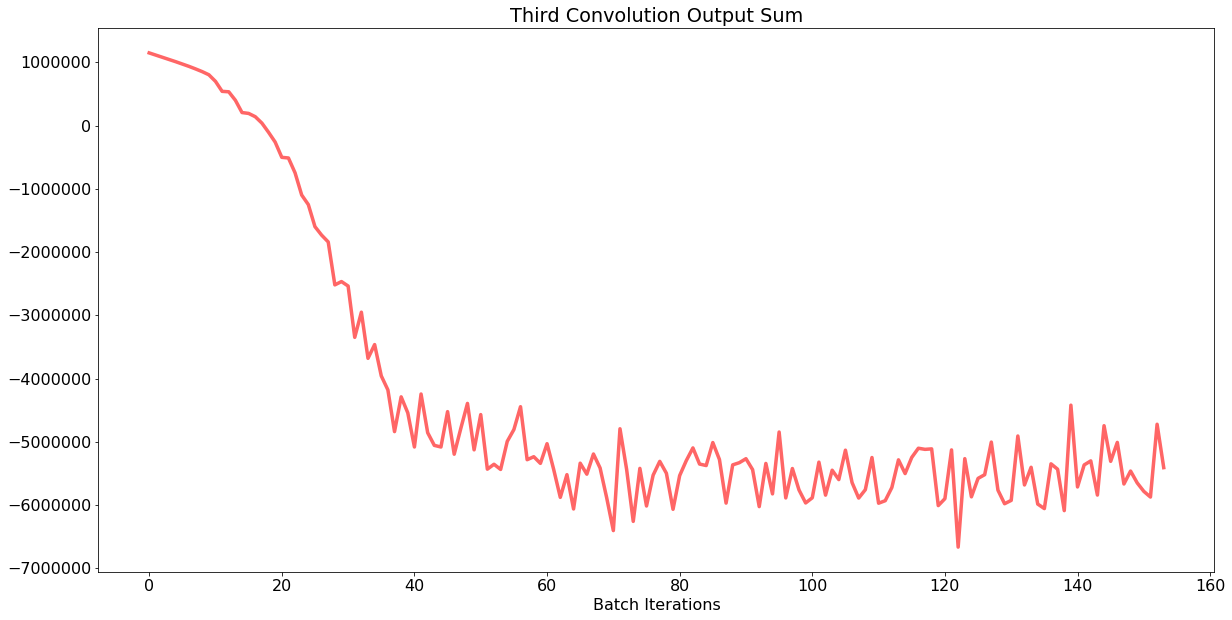

Plotting the third relu output sum


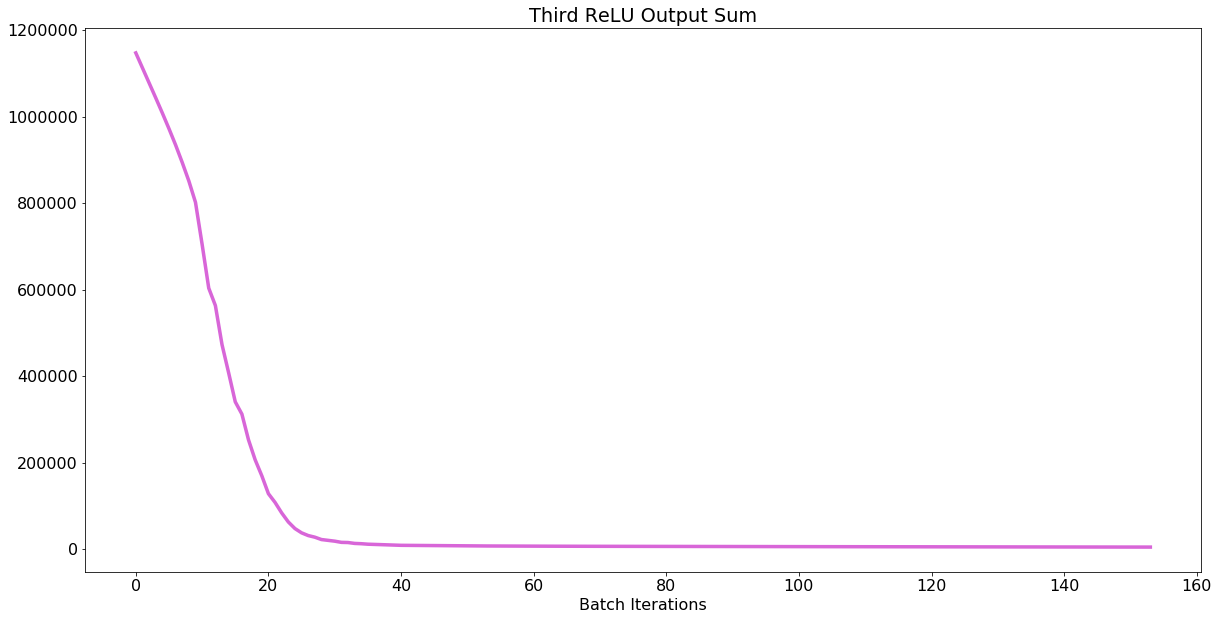

reconstructed cube = torch.Size([16, 128, 128, 128])
reconstructed cube = torch.Size([128, 128, 128])
MSE Loss = tensor(31.6720, device='cuda:0', grad_fn=<MseLossBackward>)
KLD Loss = tensor(0.1558, device='cuda:0', grad_fn=<DivBackward0>)
Train Epoch: 1 [128/256 (50%)]	Loss: 1.989235281944
Data transfer to device completed.
Starting Encoding
torch.Size([16, 2048])
Encode - Forward Pass Finished
torch.Size([16, 16])
torch.Size([16, 16])
Starting Decoding
FIRST DECODE OUT SUM = 26918.79
CONV 1 OUT SUM = 391539.2
RELU 1 OUT SUM = 391539.2
MAX UNPOOL 1 OUT SUM = 391539.06
CONV 2 OUT SUM = 3583516.2
RELU 2 OUT SUM = 3585068.8
MAX UNPOOL 2 OUT SUM = 3585069.2
CONV 3 OUT SUM = -6057812.5
RELU 3 OUT SUM = 5125.175
data shape = torch.Size([16, 128, 128, 128])
data shape = (128, 128, 128)
Plotting the first decoder output sum
first decoder out sum = [2896.9578, 2894.755, 3238.6477, 3808.3076, 3741.1228, 4201.9287, 4773.0415, 5594.073, 6045.5674, 6948.961, 14237.286, 22334.652, 15180.516, 17629.

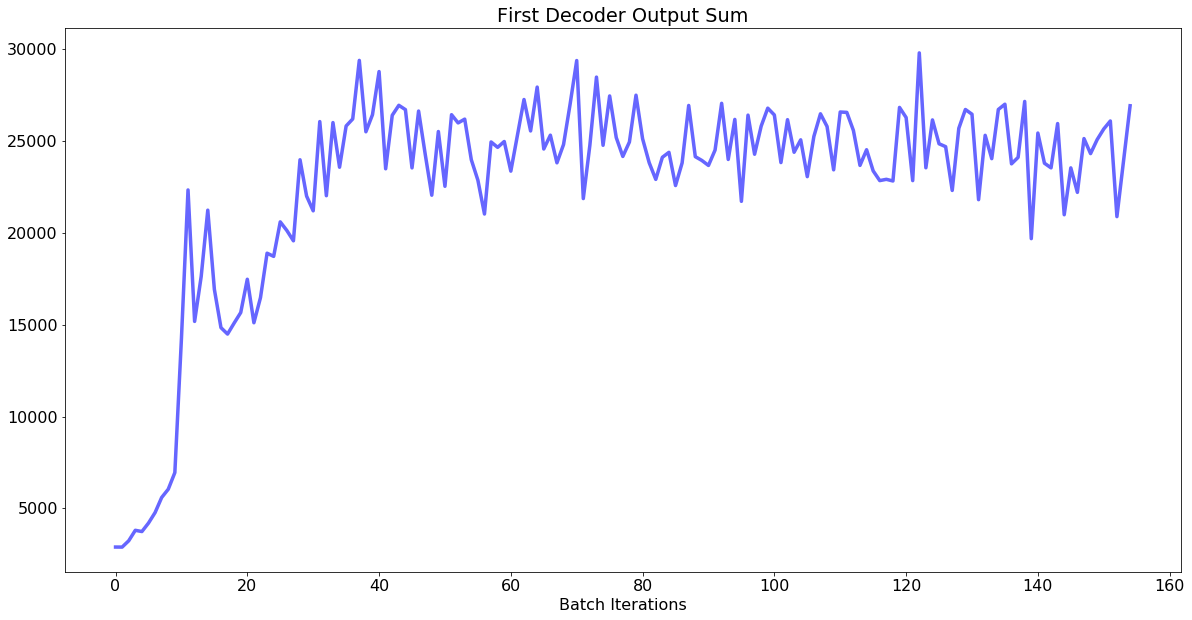

Plotting the first convolution output sum


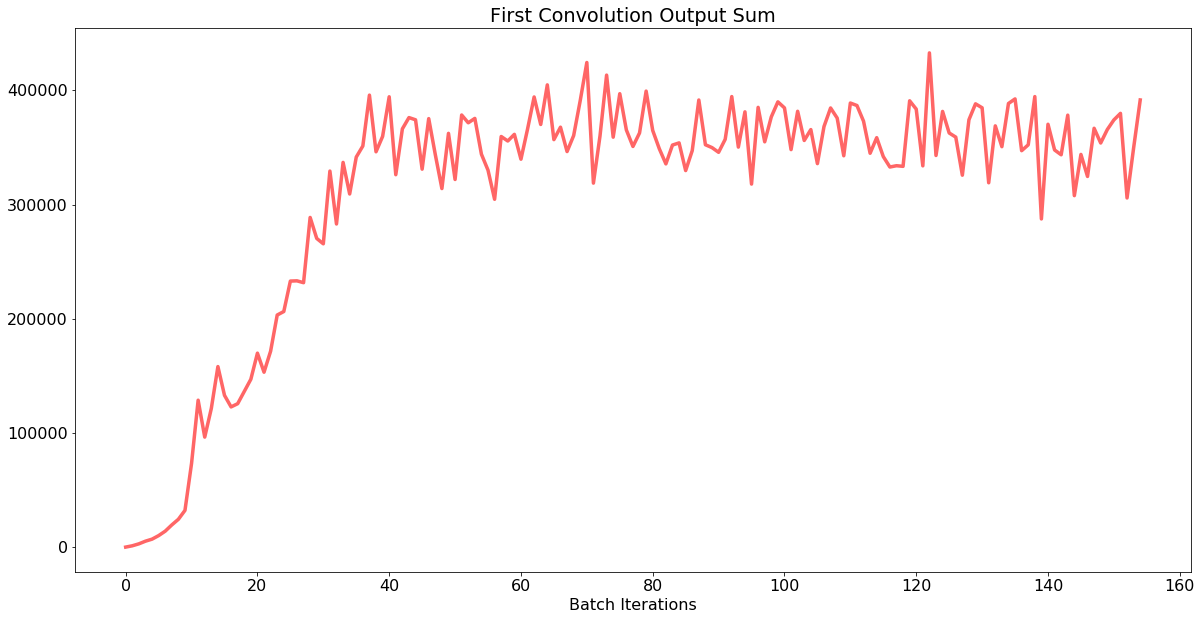

Plotting the first relu output sum


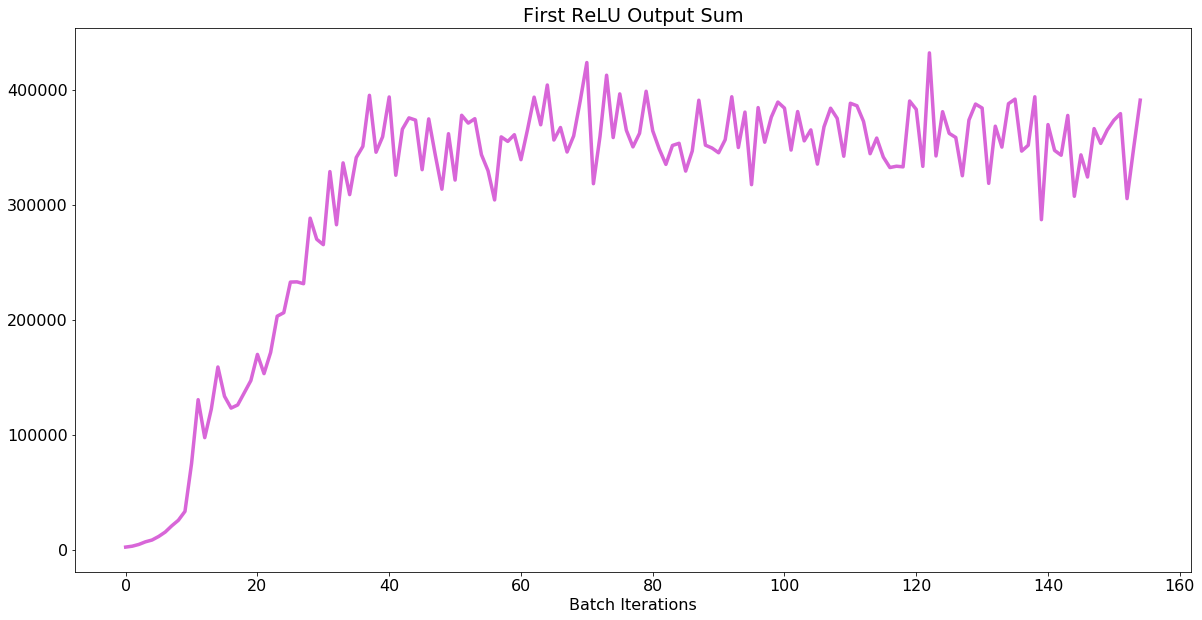

Plotting the first max unpool output sum


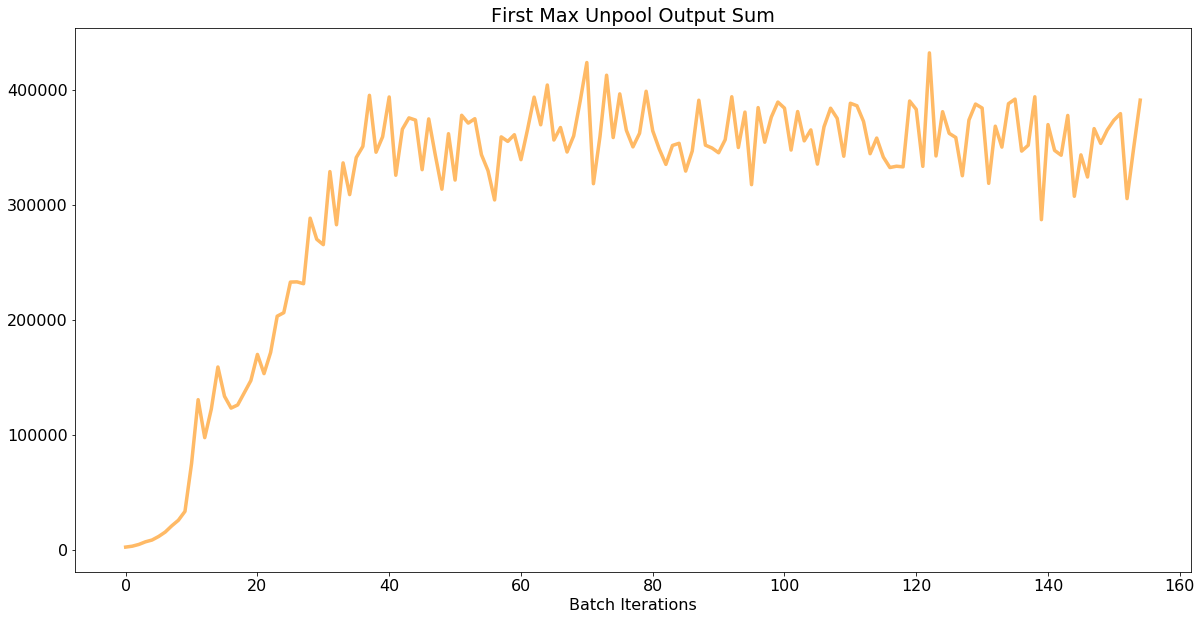

Plotting the second convolution output sum


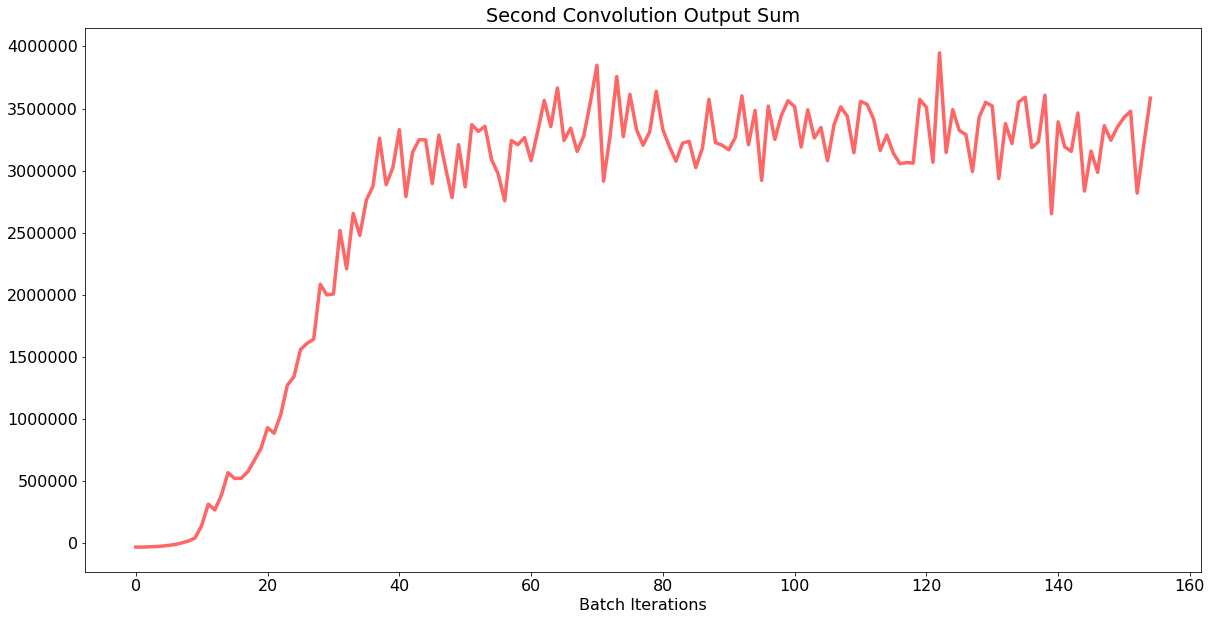

Plotting the second relu output sum


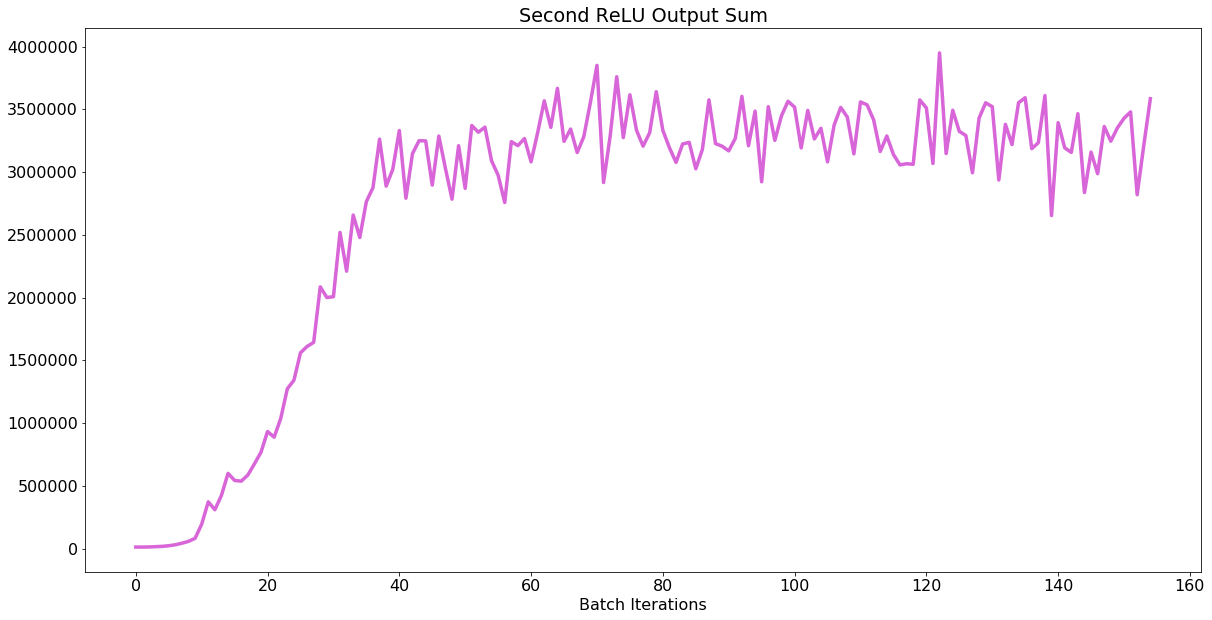

Plotting the second max unpool output sum


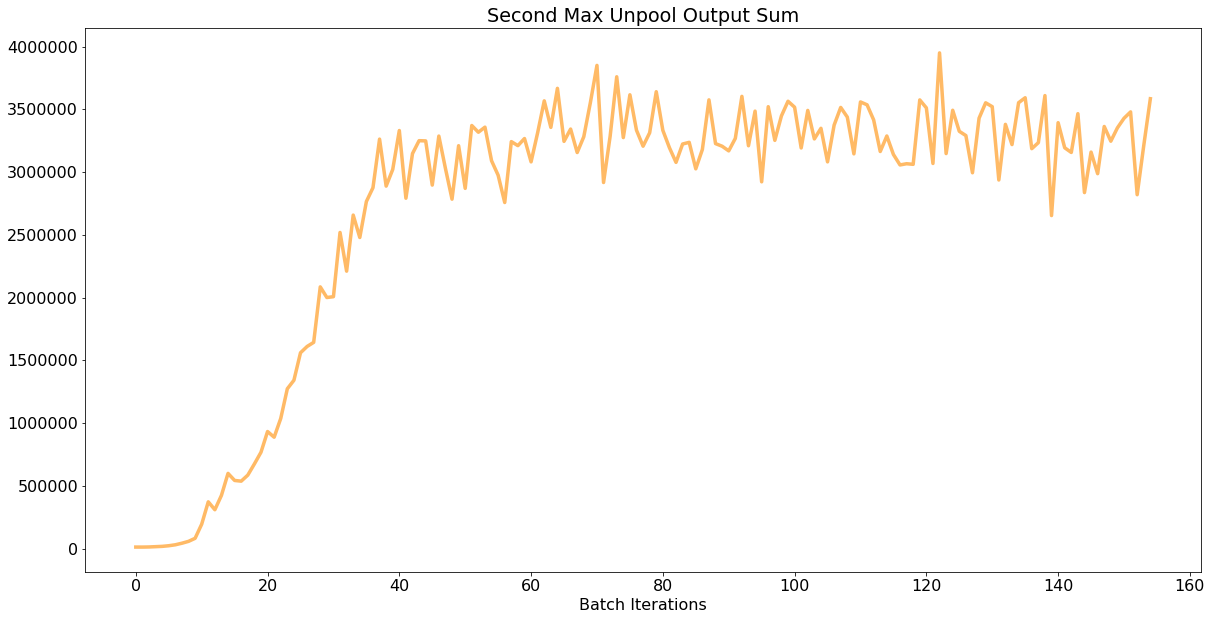

Plotting the third convolution output sum


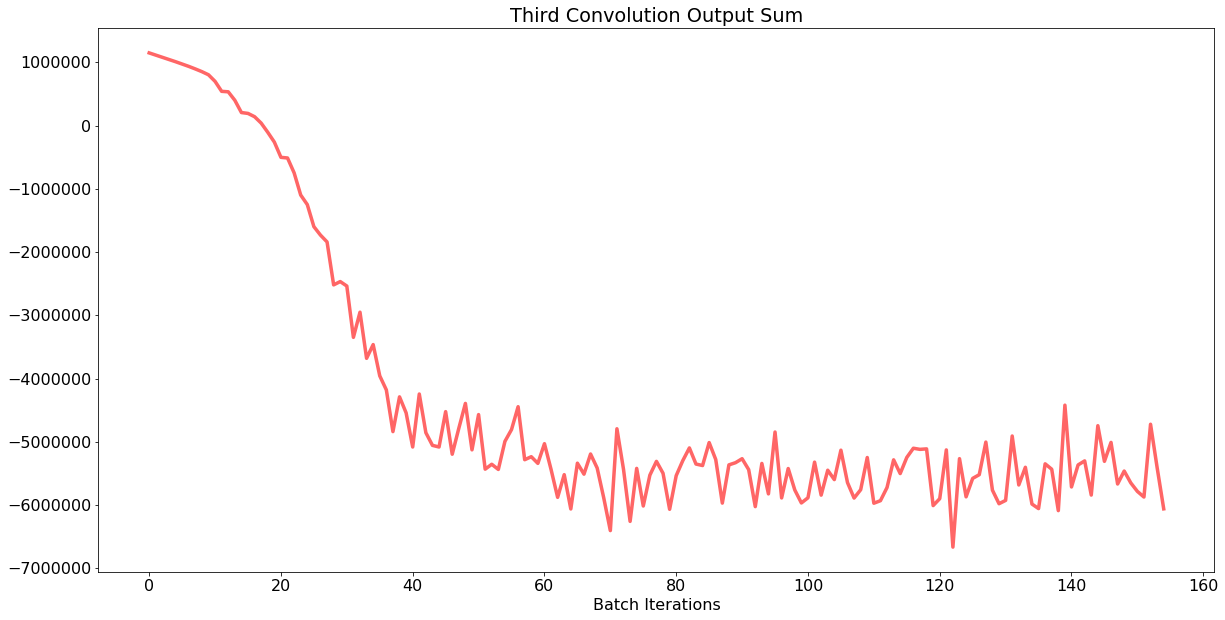

Plotting the third relu output sum


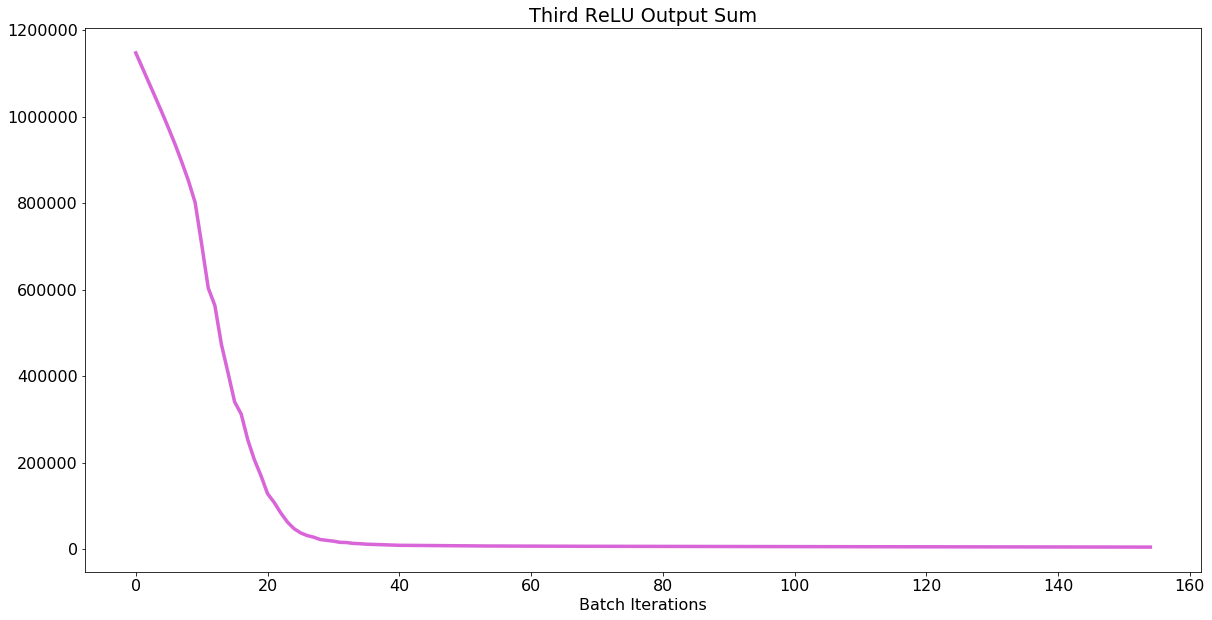

reconstructed cube = torch.Size([16, 128, 128, 128])
reconstructed cube = torch.Size([128, 128, 128])
MSE Loss = tensor(30.5045, device='cuda:0', grad_fn=<MseLossBackward>)
KLD Loss = tensor(0.1398, device='cuda:0', grad_fn=<DivBackward0>)
Train Epoch: 1 [144/256 (56%)]	Loss: 1.915268182755
Data transfer to device completed.
Starting Encoding
torch.Size([16, 2048])
Encode - Forward Pass Finished
torch.Size([16, 16])
torch.Size([16, 16])
Starting Decoding
FIRST DECODE OUT SUM = 25404.742
CONV 1 OUT SUM = 370565.06
RELU 1 OUT SUM = 370565.06
MAX UNPOOL 1 OUT SUM = 370565.1
CONV 2 OUT SUM = 3396881.2
RELU 2 OUT SUM = 3398330.5
MAX UNPOOL 2 OUT SUM = 3398333.5
CONV 3 OUT SUM = -5732749.0
RELU 3 OUT SUM = 5090.2715
data shape = torch.Size([16, 128, 128, 128])
data shape = (128, 128, 128)
Plotting the first decoder output sum
first decoder out sum = [2896.9578, 2894.755, 3238.6477, 3808.3076, 3741.1228, 4201.9287, 4773.0415, 5594.073, 6045.5674, 6948.961, 14237.286, 22334.652, 15180.516, 176

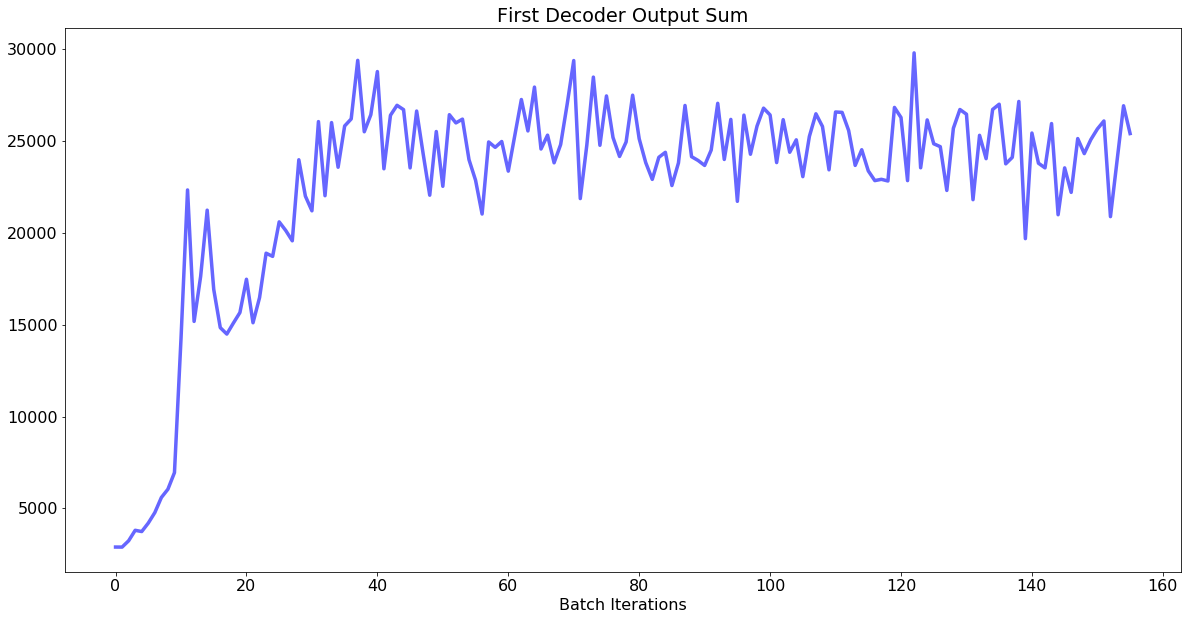

Plotting the first convolution output sum


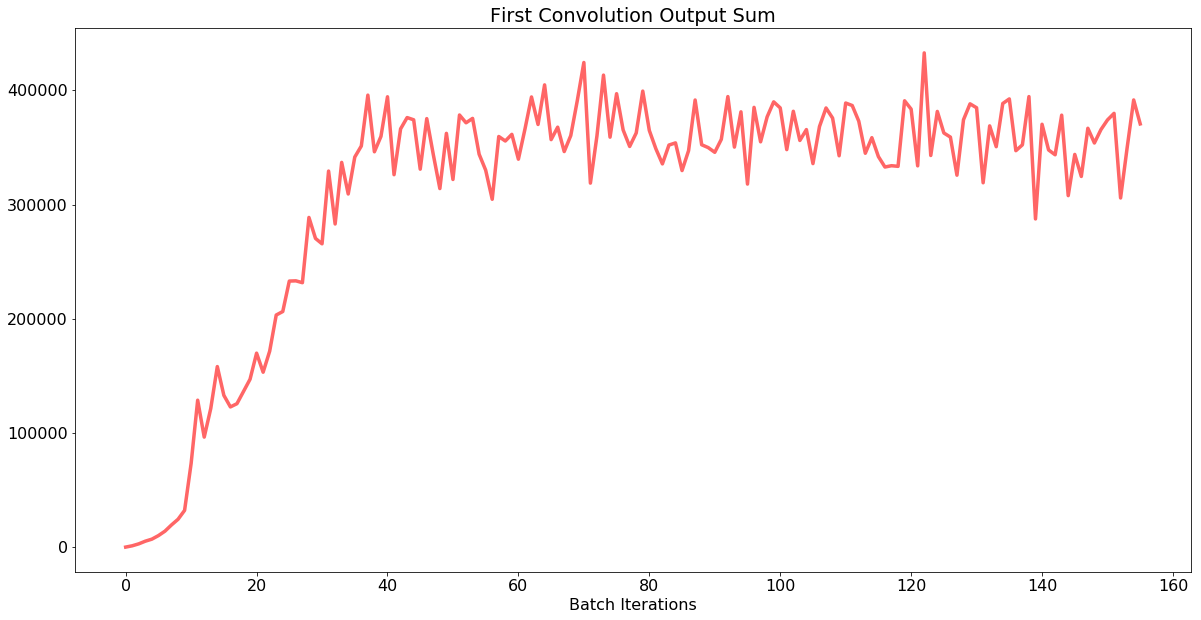

Plotting the first relu output sum


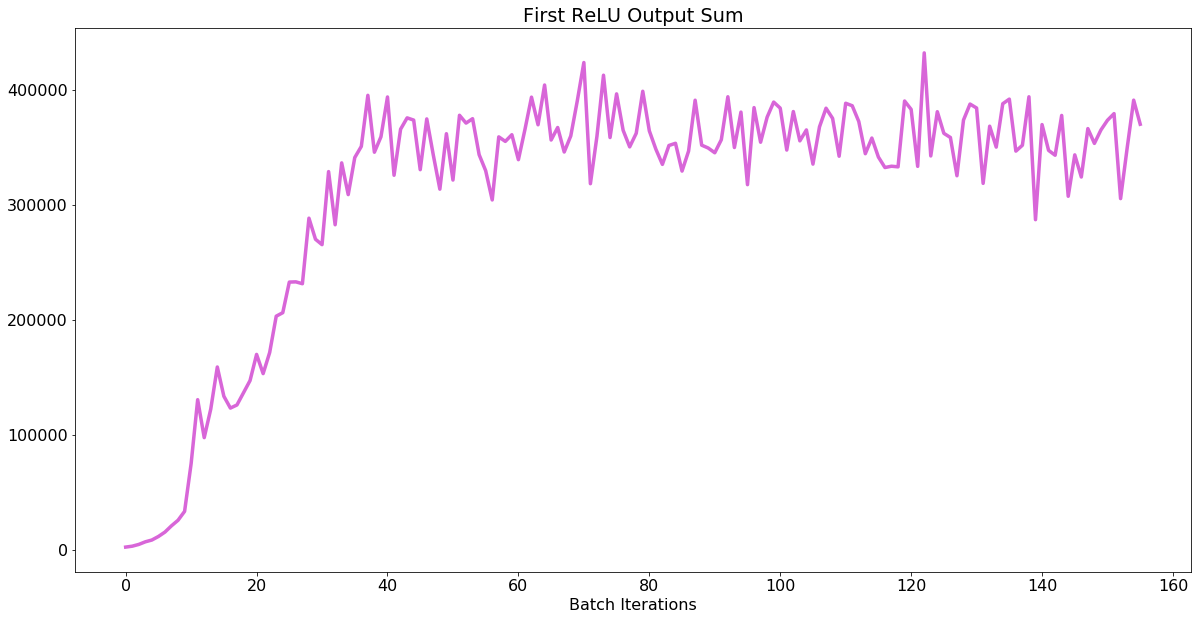

Plotting the first max unpool output sum


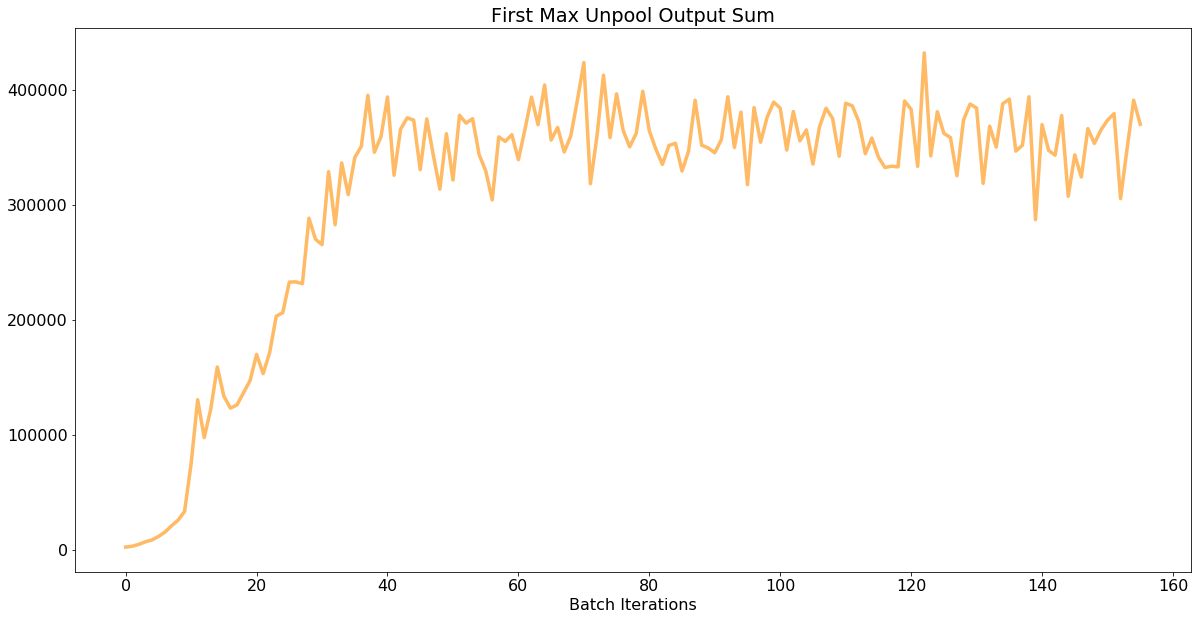

Plotting the second convolution output sum


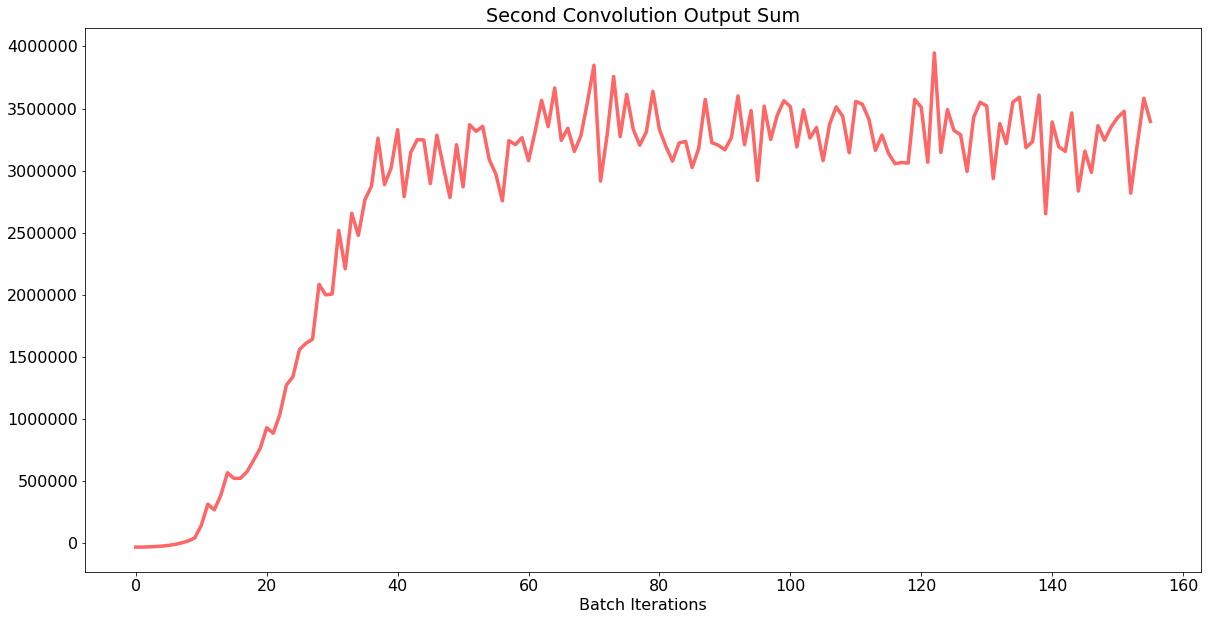

Plotting the second relu output sum


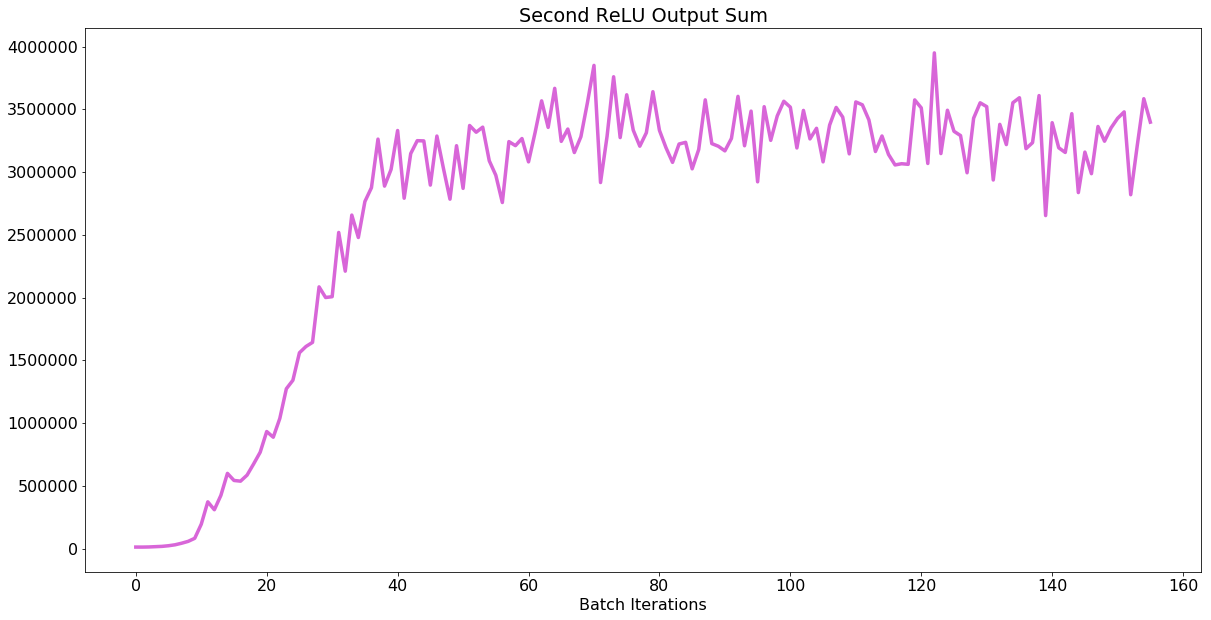

Plotting the second max unpool output sum


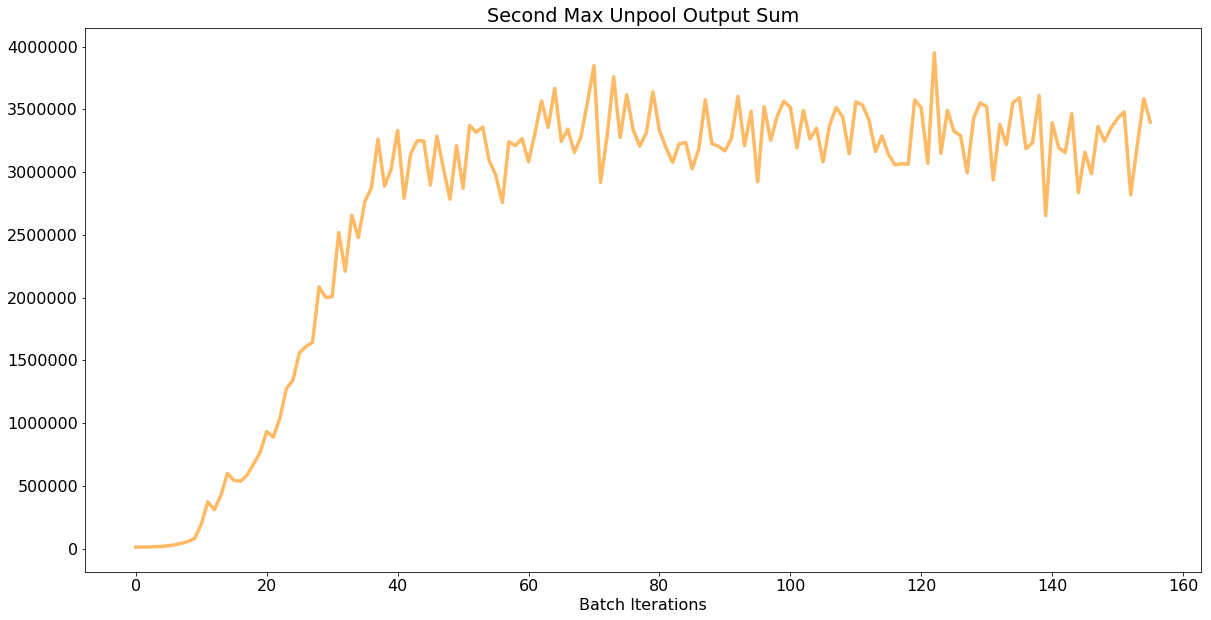

Plotting the third convolution output sum


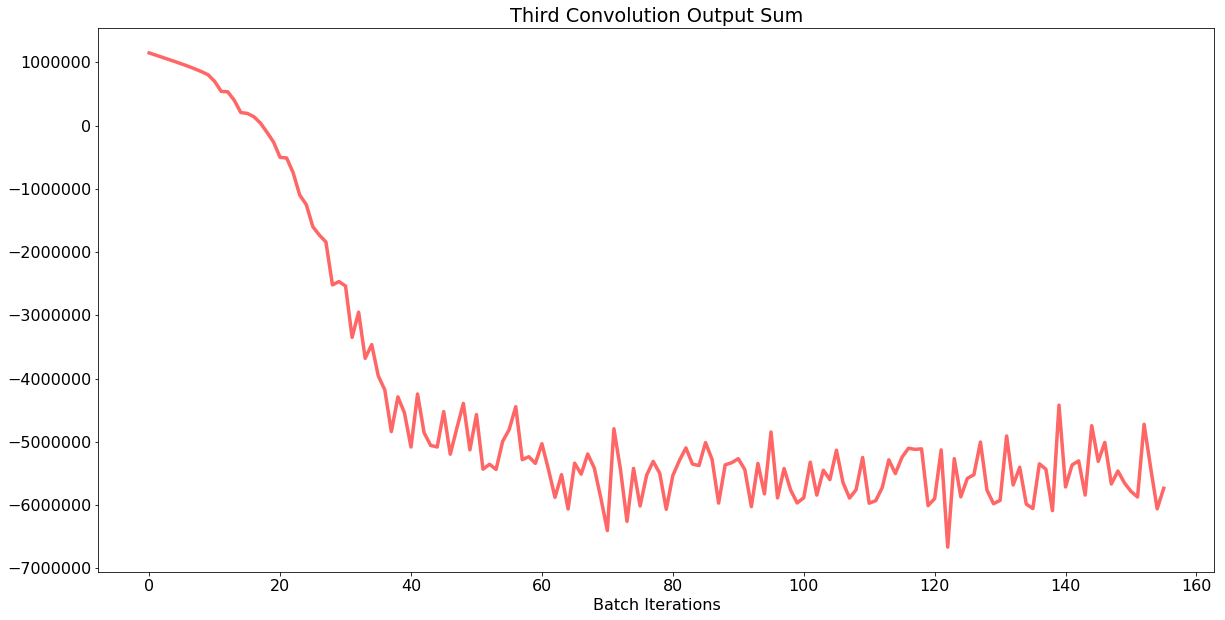

Plotting the third relu output sum


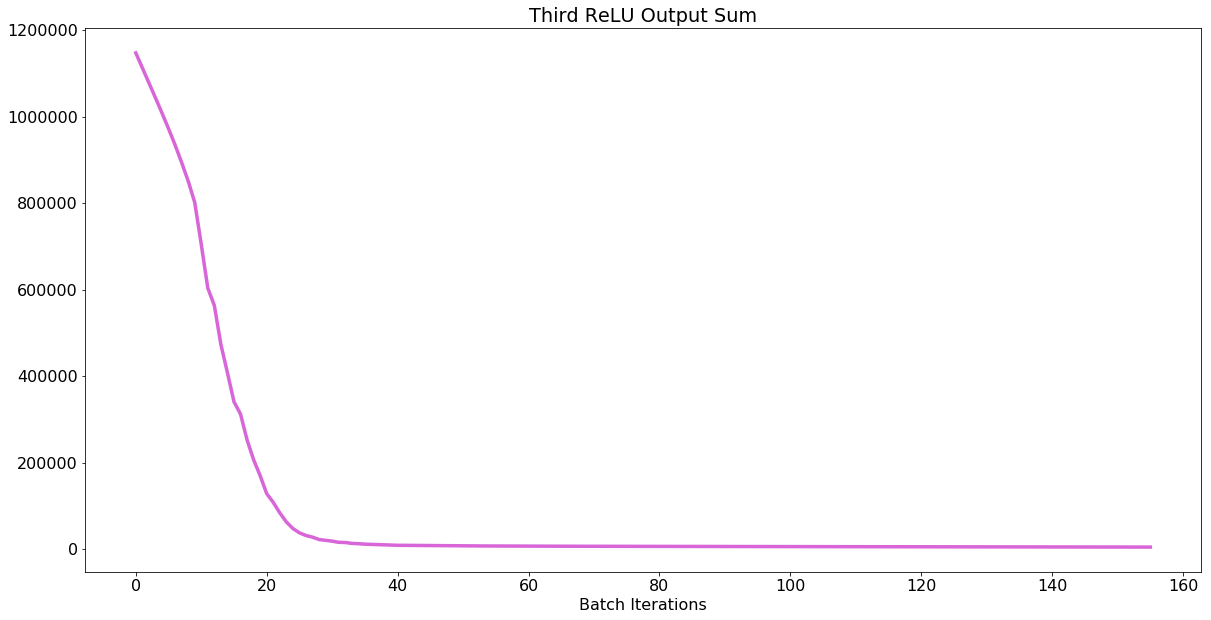

reconstructed cube = torch.Size([16, 128, 128, 128])
reconstructed cube = torch.Size([128, 128, 128])
MSE Loss = tensor(30.5770, device='cuda:0', grad_fn=<MseLossBackward>)
KLD Loss = tensor(0.1482, device='cuda:0', grad_fn=<DivBackward0>)
Train Epoch: 1 [160/256 (62%)]	Loss: 1.920323967934
Data transfer to device completed.
Starting Encoding
torch.Size([16, 2048])
Encode - Forward Pass Finished
torch.Size([16, 16])
torch.Size([16, 16])
Starting Decoding
FIRST DECODE OUT SUM = 26854.1
CONV 1 OUT SUM = 390978.44
RELU 1 OUT SUM = 390978.44
MAX UNPOOL 1 OUT SUM = 390978.47
CONV 2 OUT SUM = 3577594.8
RELU 2 OUT SUM = 3579241.2
MAX UNPOOL 2 OUT SUM = 3579243.8
CONV 3 OUT SUM = -6049398.5
RELU 3 OUT SUM = 5093.8535
data shape = torch.Size([16, 128, 128, 128])
data shape = (128, 128, 128)
Plotting the first decoder output sum
first decoder out sum = [2896.9578, 2894.755, 3238.6477, 3808.3076, 3741.1228, 4201.9287, 4773.0415, 5594.073, 6045.5674, 6948.961, 14237.286, 22334.652, 15180.516, 1762

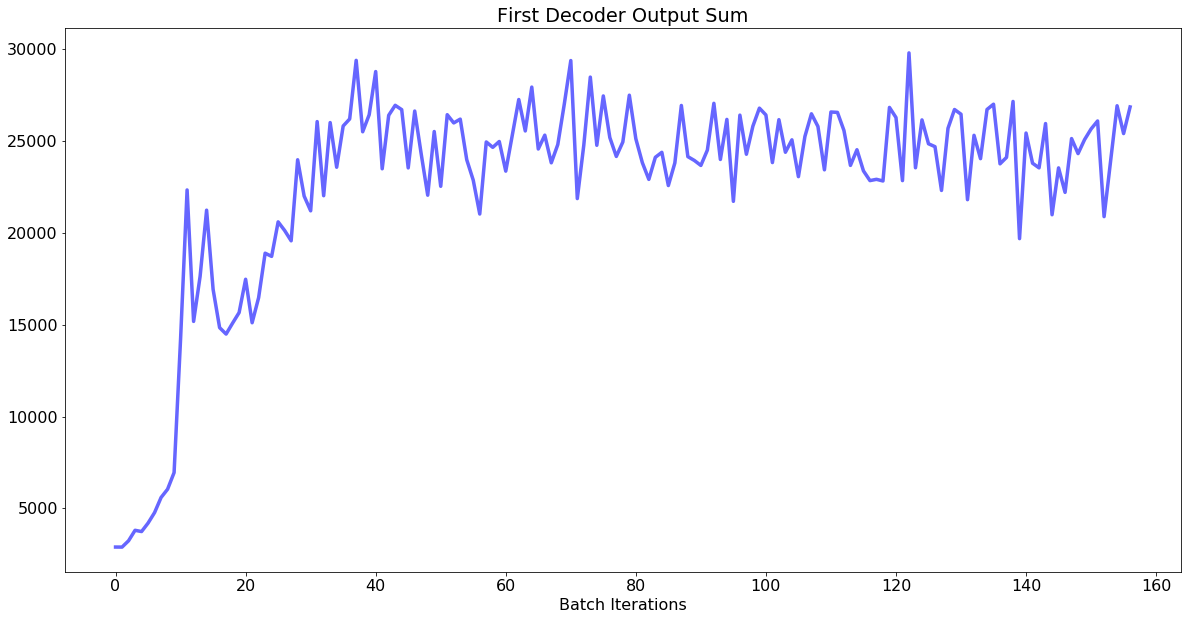

Plotting the first convolution output sum


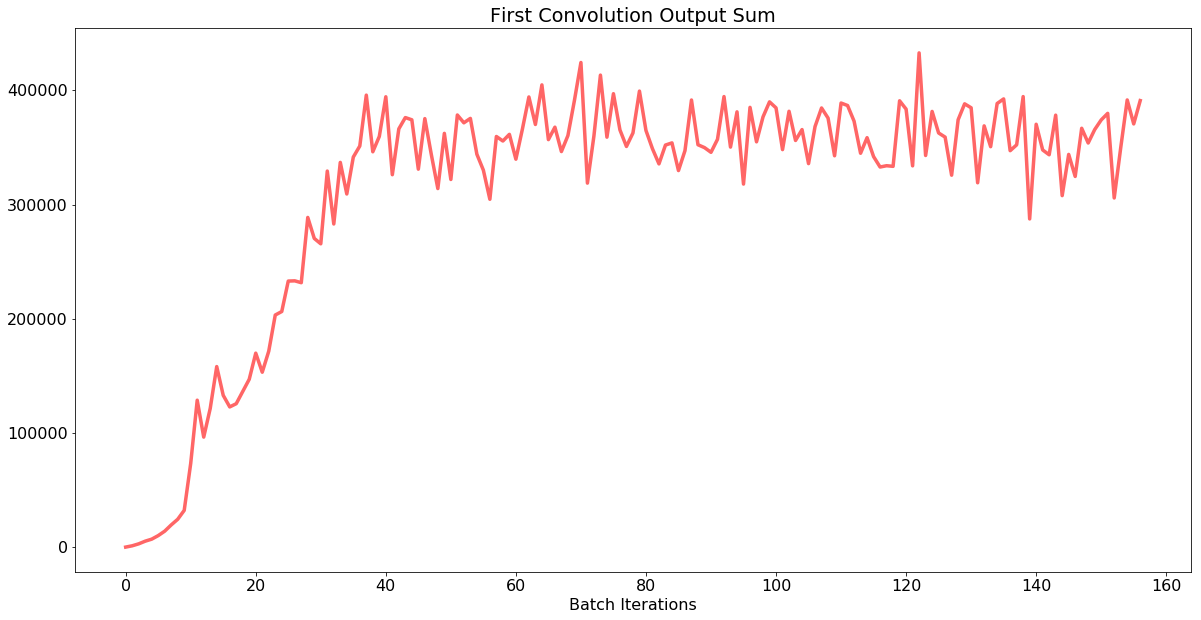

Plotting the first relu output sum


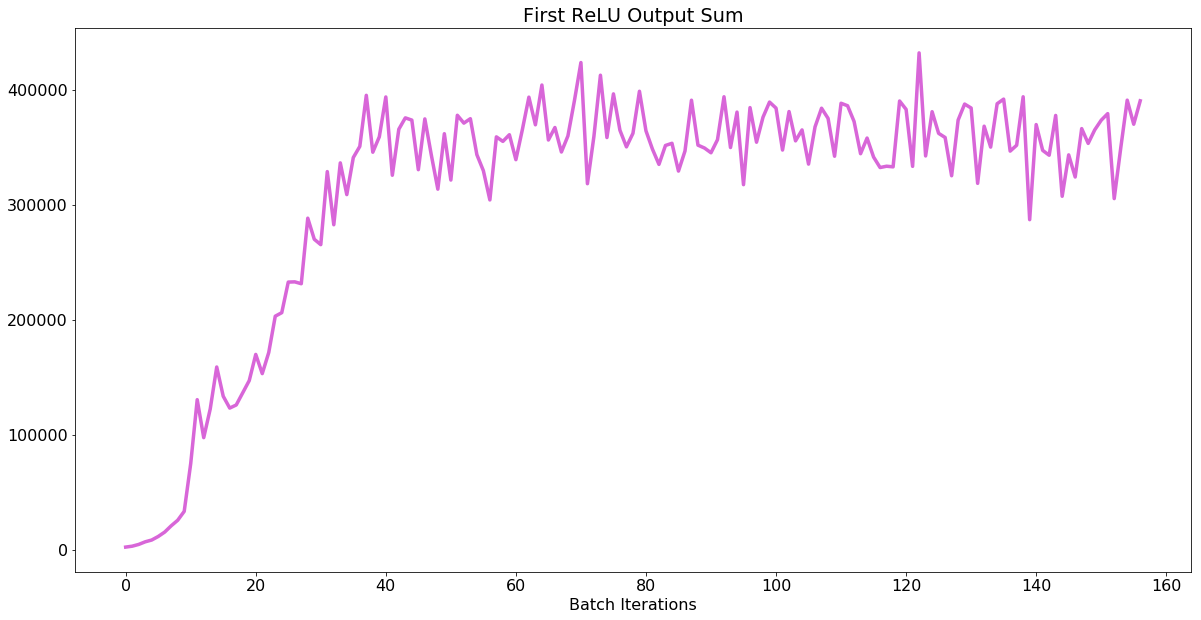

Plotting the first max unpool output sum


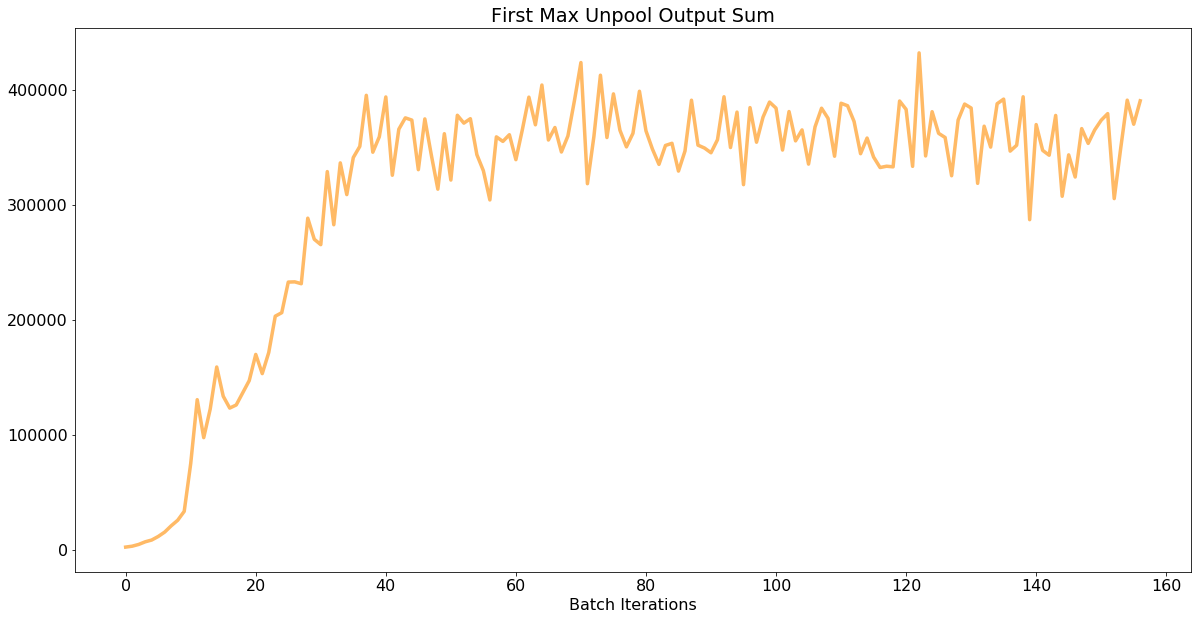

Plotting the second convolution output sum


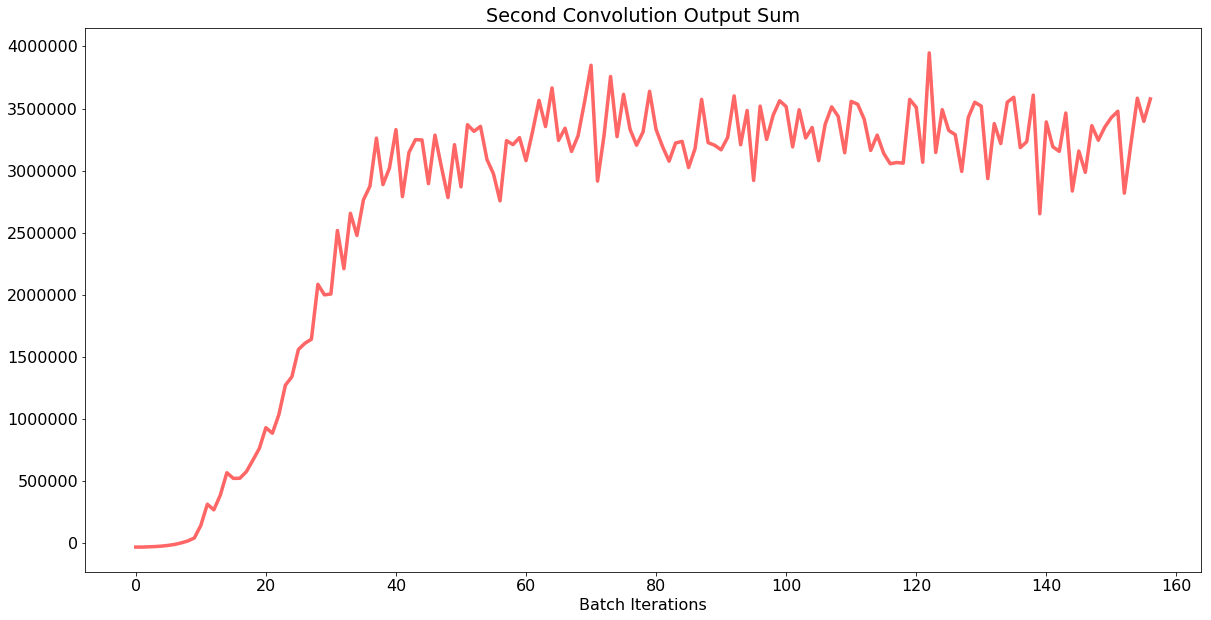

Plotting the second relu output sum


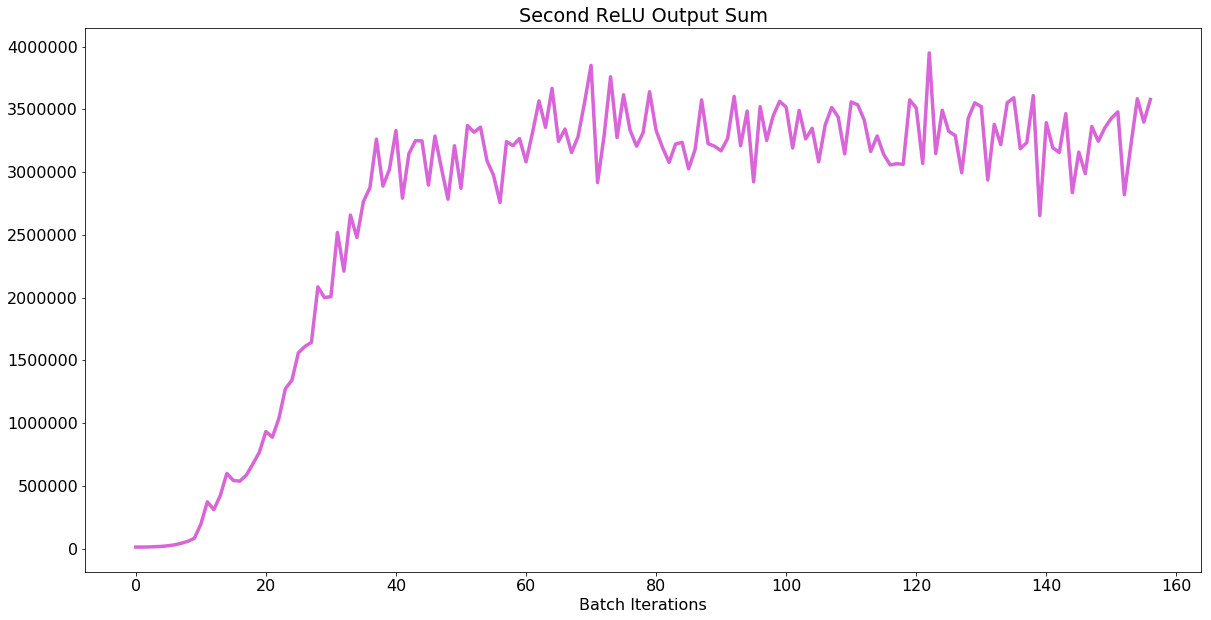

Plotting the second max unpool output sum


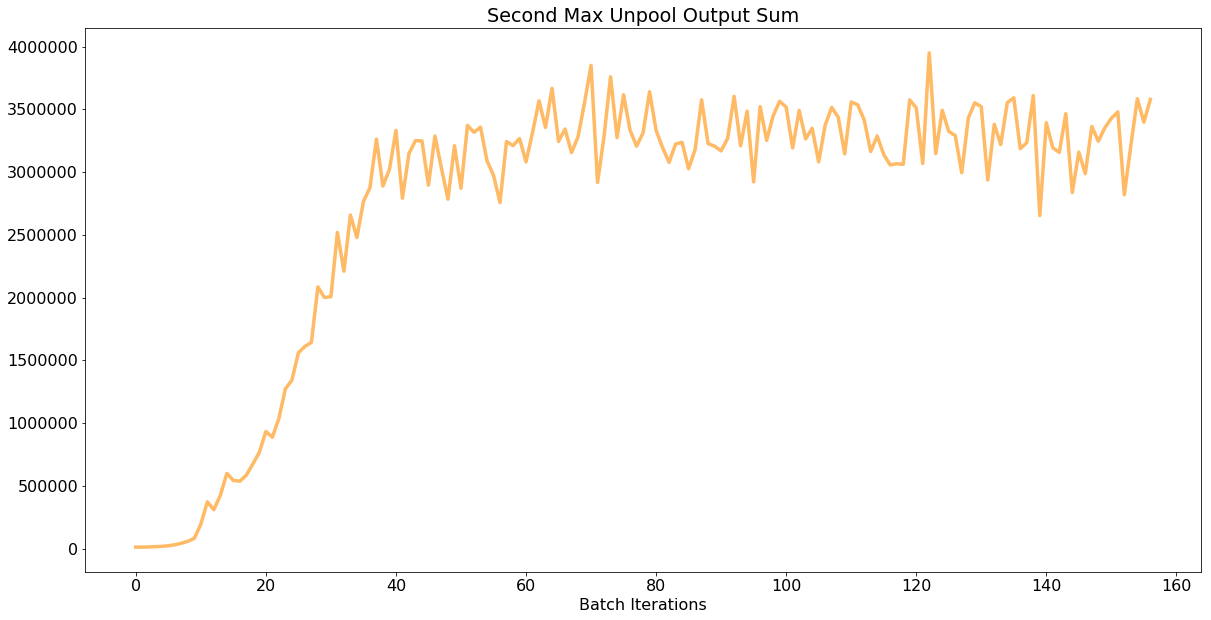

Plotting the third convolution output sum


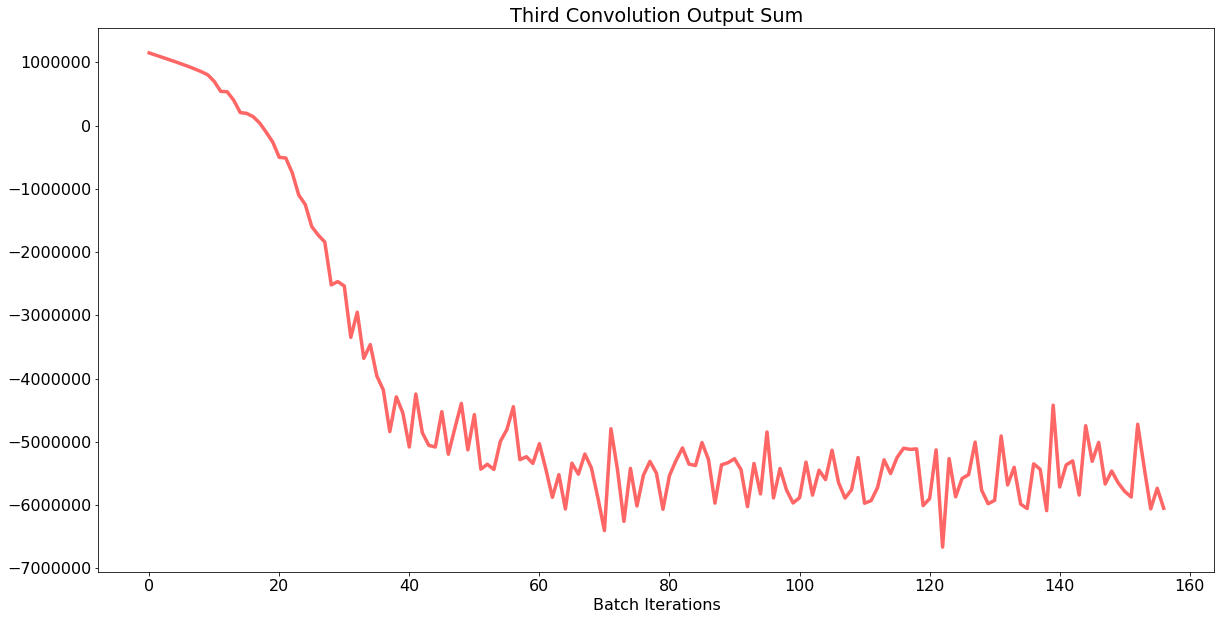

Plotting the third relu output sum


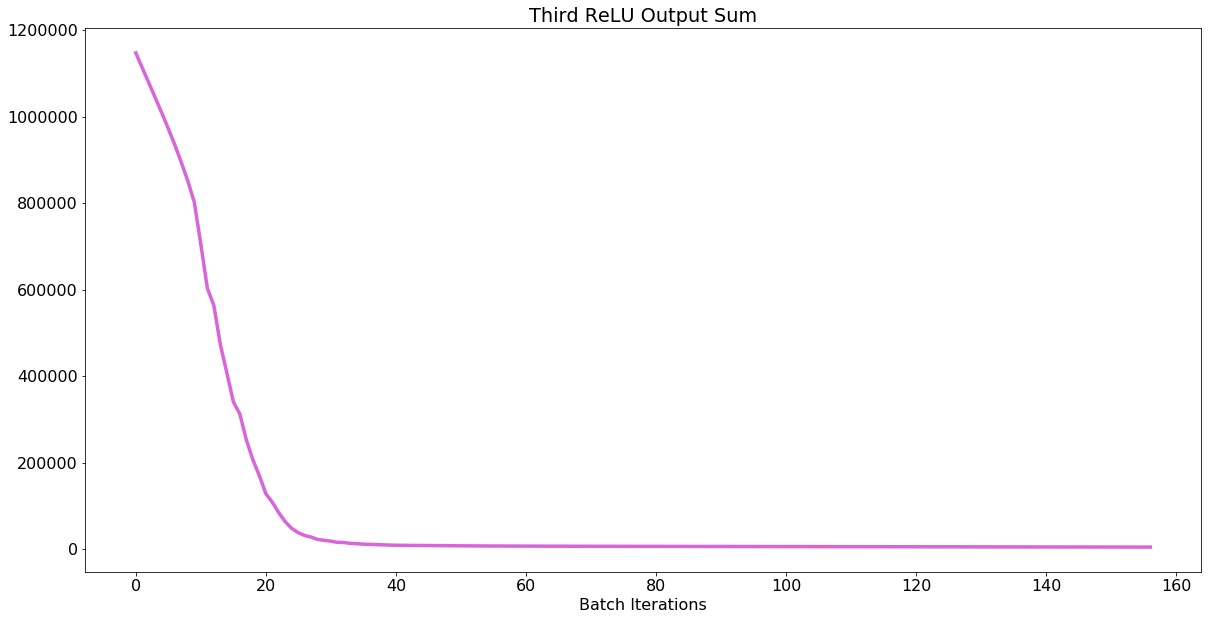

reconstructed cube = torch.Size([16, 128, 128, 128])
reconstructed cube = torch.Size([128, 128, 128])
MSE Loss = tensor(32.5766, device='cuda:0', grad_fn=<MseLossBackward>)
KLD Loss = tensor(0.1768, device='cuda:0', grad_fn=<DivBackward0>)
Train Epoch: 1 [176/256 (69%)]	Loss: 2.047089338303
Data transfer to device completed.
Starting Encoding
torch.Size([16, 2048])
Encode - Forward Pass Finished
torch.Size([16, 16])
torch.Size([16, 16])
Starting Decoding
FIRST DECODE OUT SUM = 24161.838
CONV 1 OUT SUM = 351539.97
RELU 1 OUT SUM = 351539.97
MAX UNPOOL 1 OUT SUM = 351539.88
CONV 2 OUT SUM = 3226762.5
RELU 2 OUT SUM = 3228148.0
MAX UNPOOL 2 OUT SUM = 3228151.8
CONV 3 OUT SUM = -5437655.0
RELU 3 OUT SUM = 5074.1826
data shape = torch.Size([16, 128, 128, 128])
data shape = (128, 128, 128)
Plotting the first decoder output sum
first decoder out sum = [2896.9578, 2894.755, 3238.6477, 3808.3076, 3741.1228, 4201.9287, 4773.0415, 5594.073, 6045.5674, 6948.961, 14237.286, 22334.652, 15180.516, 17

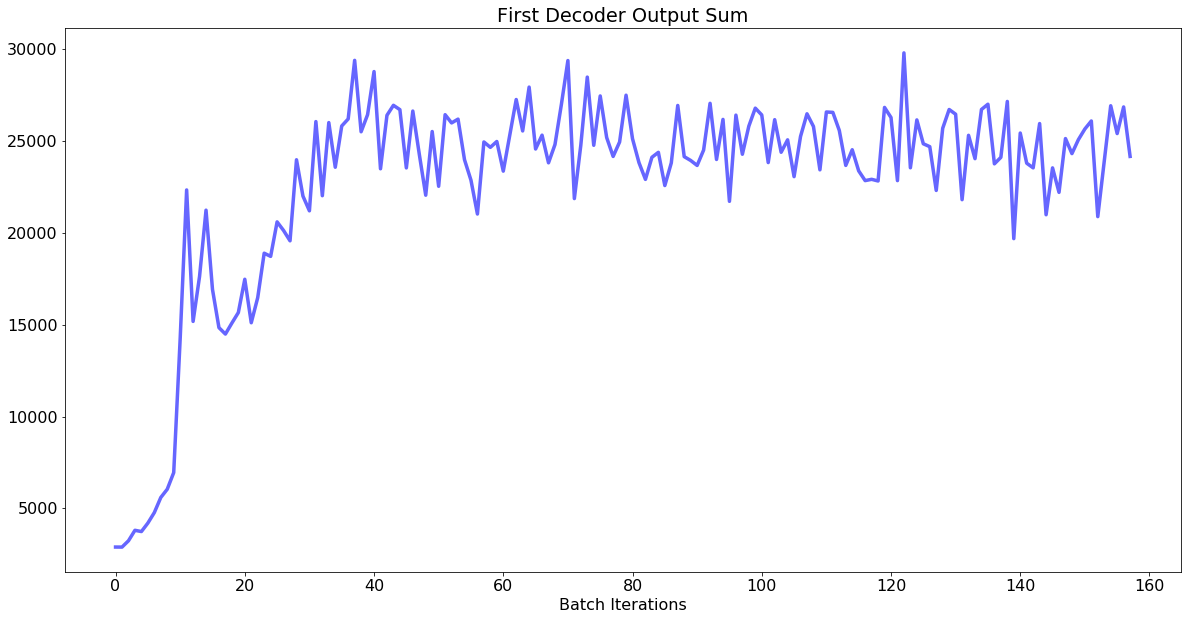

Plotting the first convolution output sum


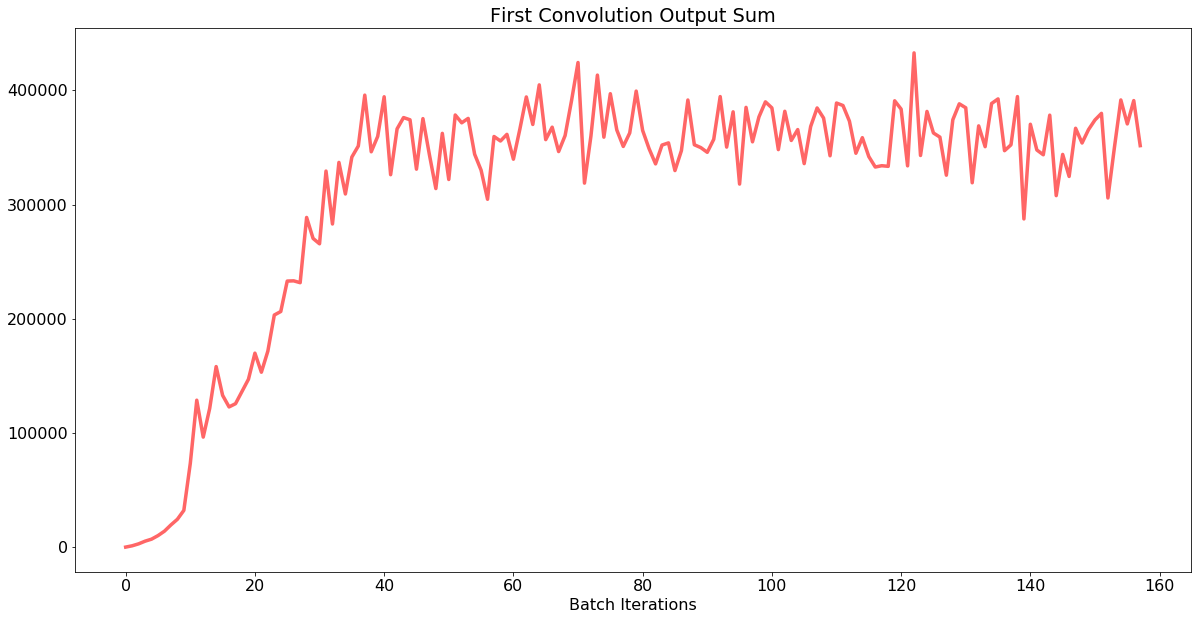

Plotting the first relu output sum


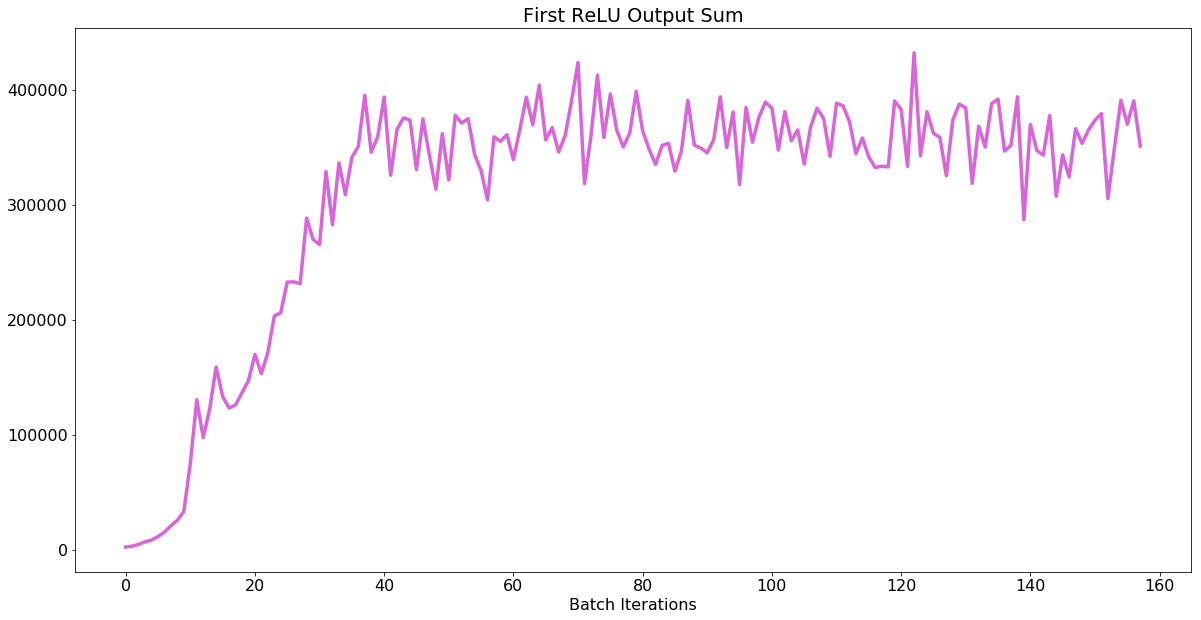

Plotting the first max unpool output sum


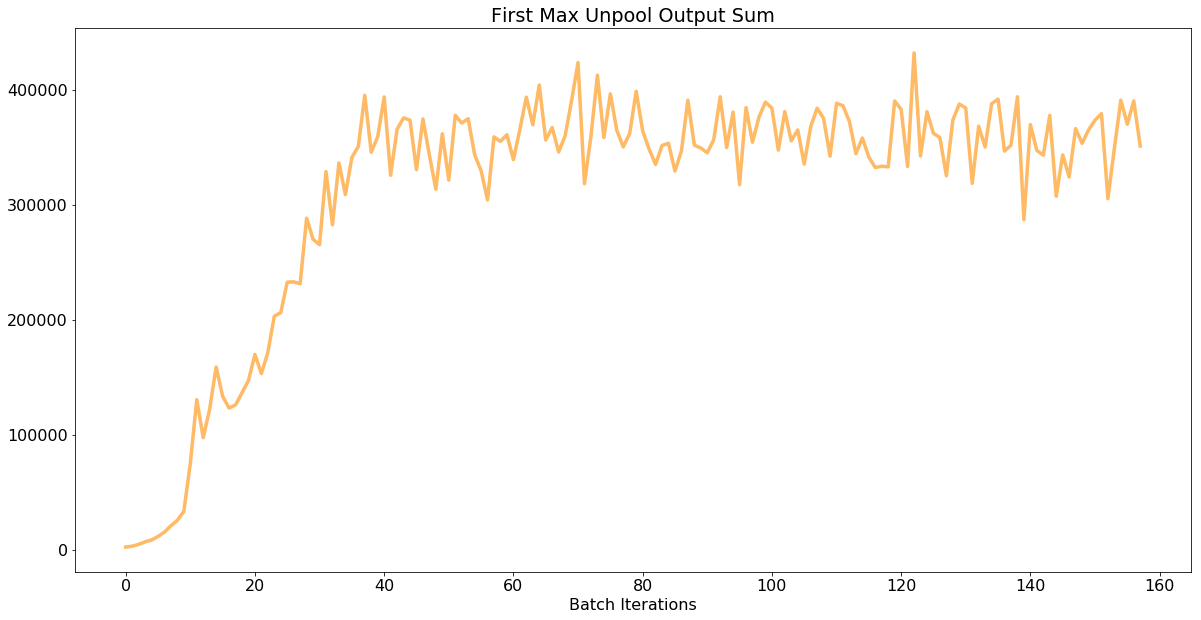

Plotting the second convolution output sum


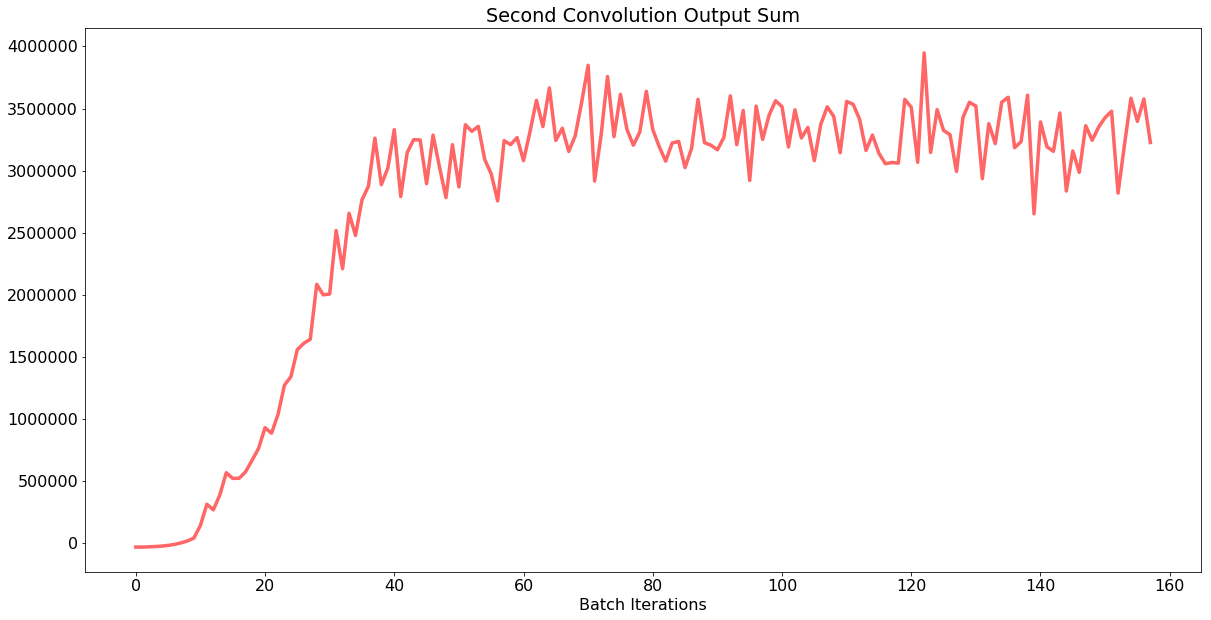

Plotting the second relu output sum


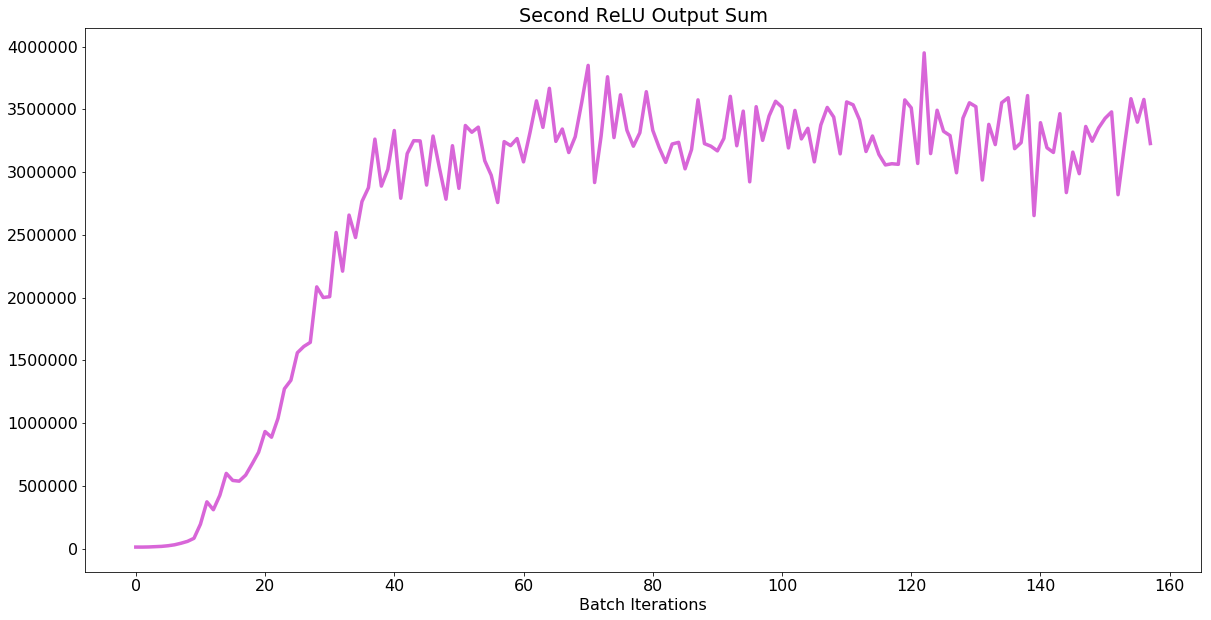

Plotting the second max unpool output sum


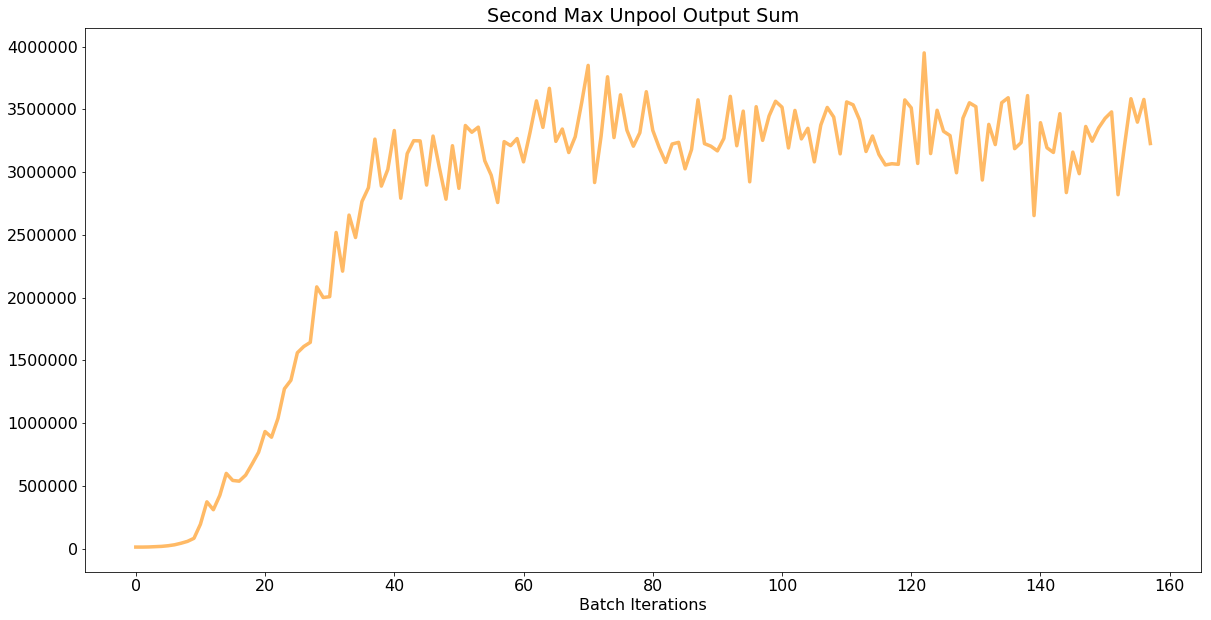

Plotting the third convolution output sum


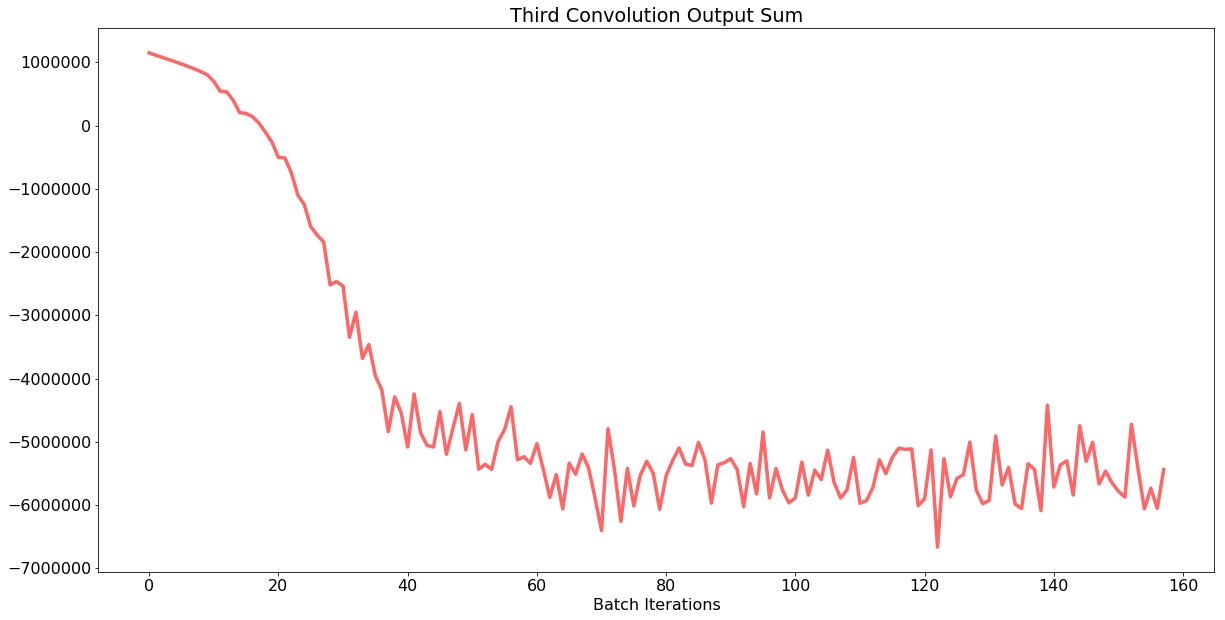

Plotting the third relu output sum


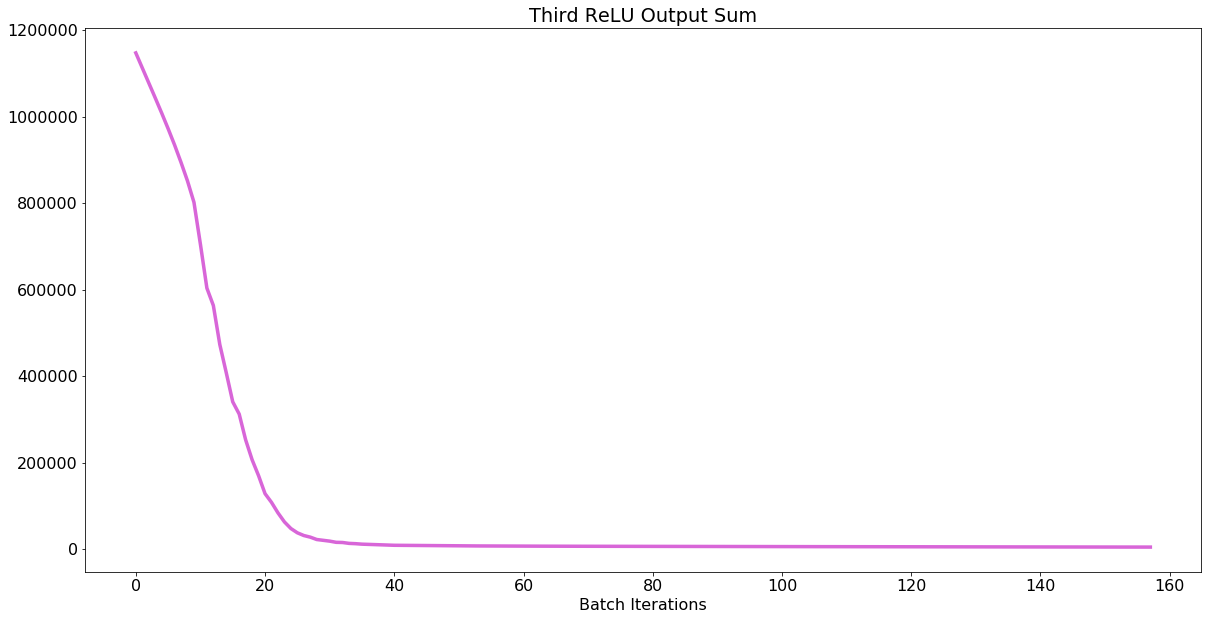

reconstructed cube = torch.Size([16, 128, 128, 128])
reconstructed cube = torch.Size([128, 128, 128])
MSE Loss = tensor(31.5134, device='cuda:0', grad_fn=<MseLossBackward>)
KLD Loss = tensor(0.1385, device='cuda:0', grad_fn=<DivBackward0>)
Train Epoch: 1 [192/256 (75%)]	Loss: 1.978243350983
Data transfer to device completed.
Starting Encoding
torch.Size([16, 2048])
Encode - Forward Pass Finished
torch.Size([16, 16])
torch.Size([16, 16])
Starting Decoding
FIRST DECODE OUT SUM = 23109.34
CONV 1 OUT SUM = 337299.78
RELU 1 OUT SUM = 337299.78
MAX UNPOOL 1 OUT SUM = 337299.75
CONV 2 OUT SUM = 3099586.0
RELU 2 OUT SUM = 3100864.2
MAX UNPOOL 2 OUT SUM = 3100867.8
CONV 3 OUT SUM = -5215757.0
RELU 3 OUT SUM = 5036.582
data shape = torch.Size([16, 128, 128, 128])
data shape = (128, 128, 128)
Plotting the first decoder output sum
first decoder out sum = [2896.9578, 2894.755, 3238.6477, 3808.3076, 3741.1228, 4201.9287, 4773.0415, 5594.073, 6045.5674, 6948.961, 14237.286, 22334.652, 15180.516, 1762

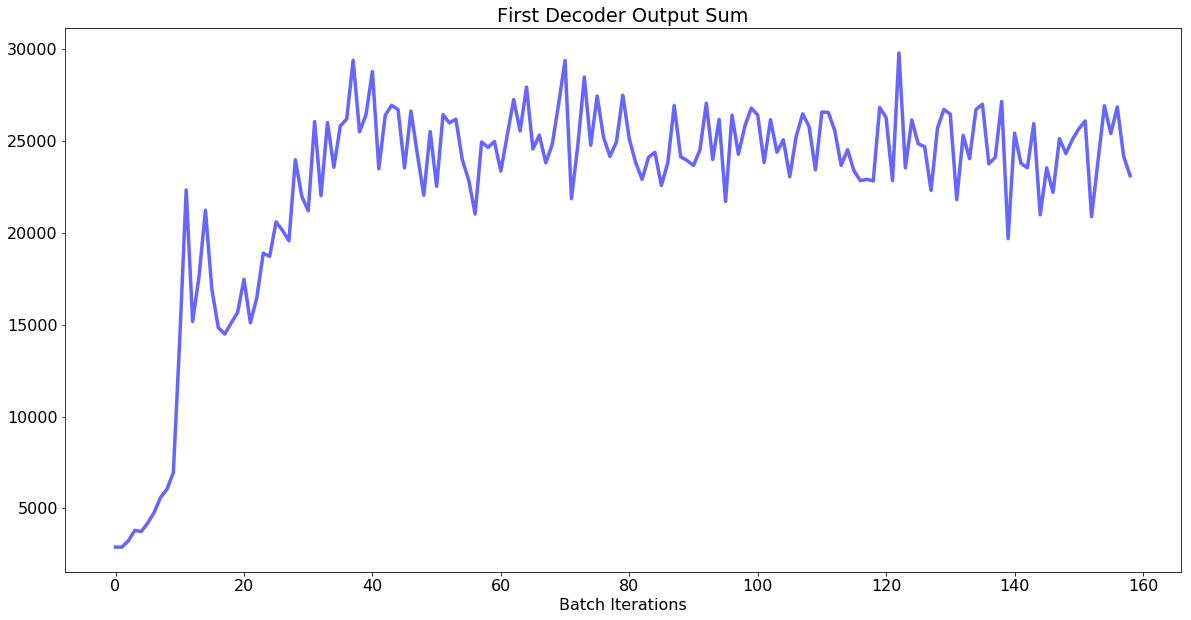

Plotting the first convolution output sum


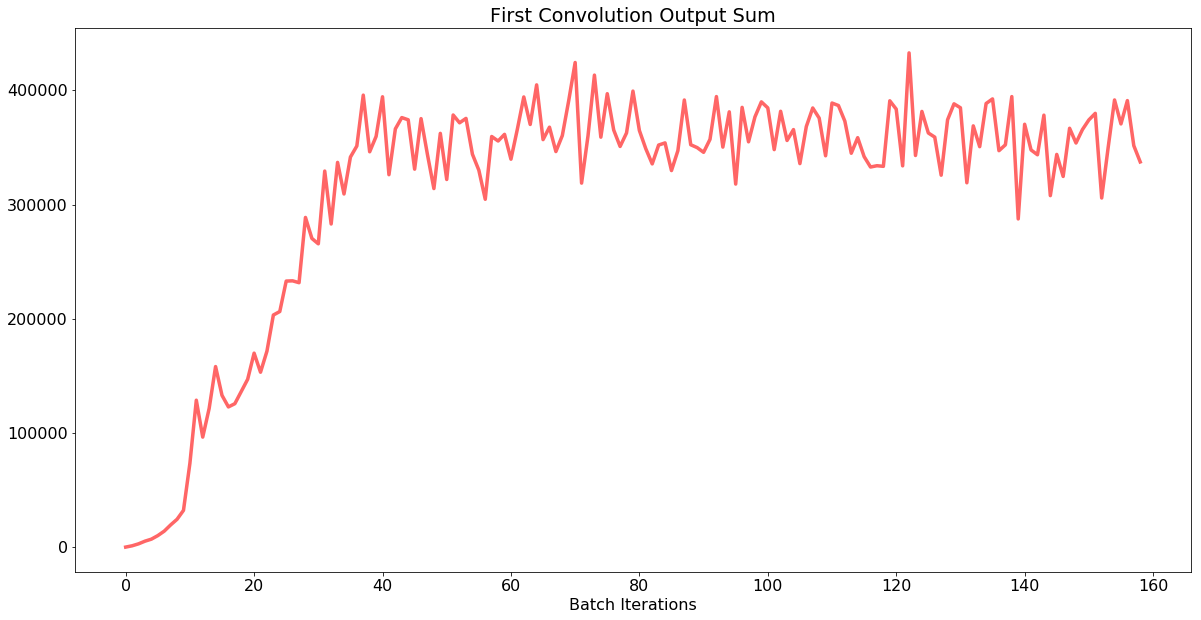

Plotting the first relu output sum


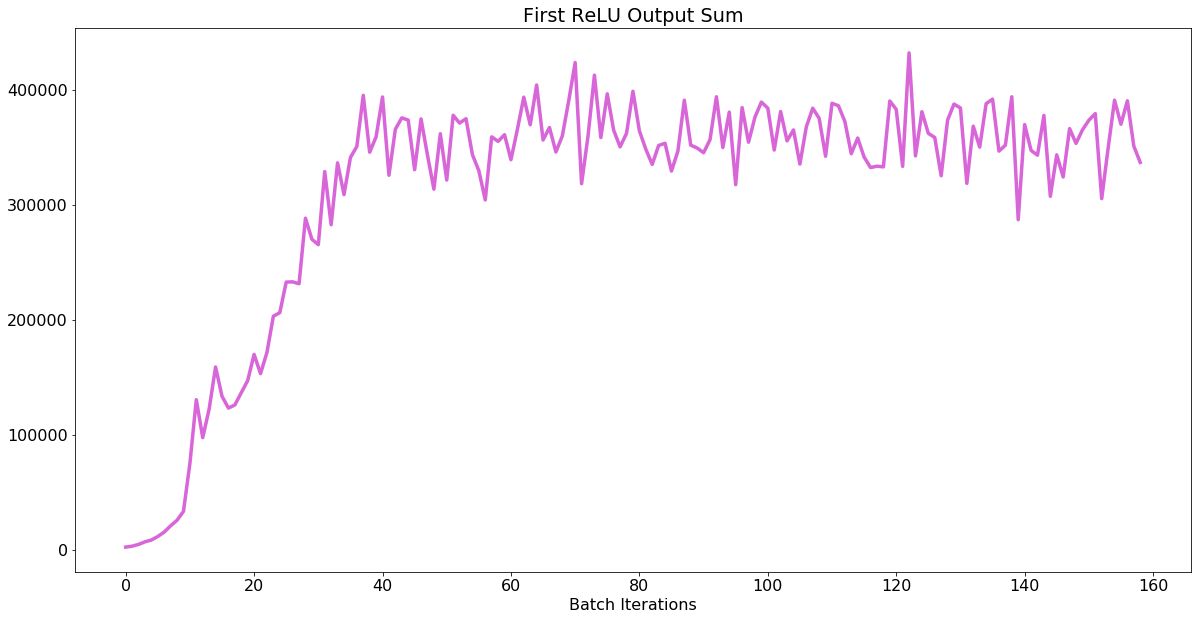

Plotting the first max unpool output sum


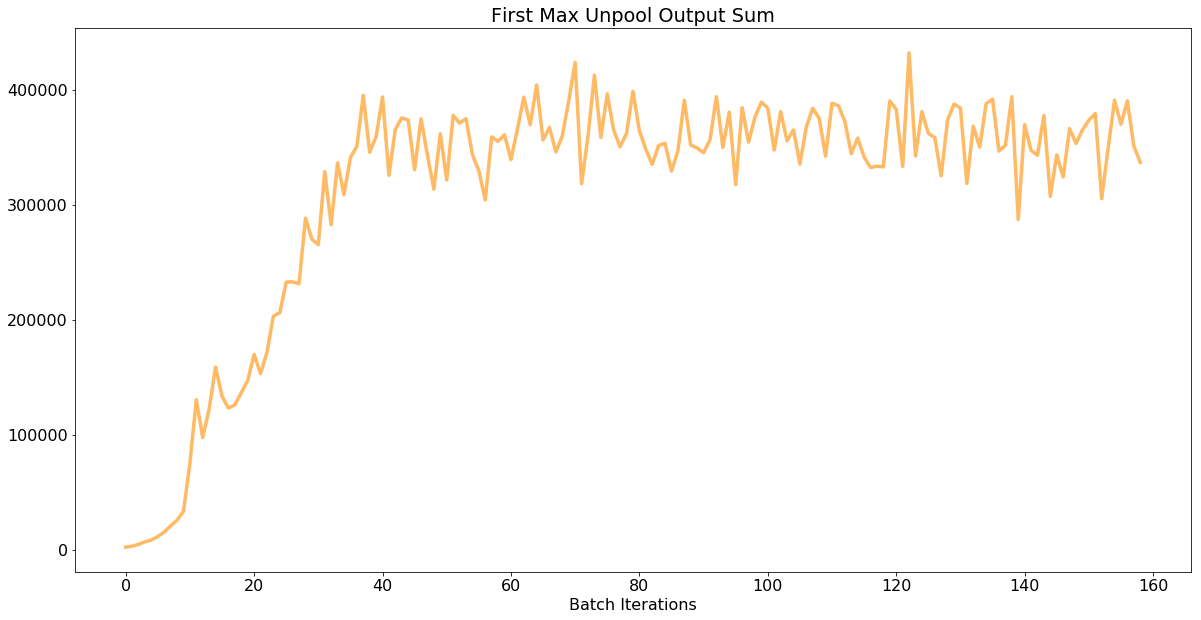

Plotting the second convolution output sum


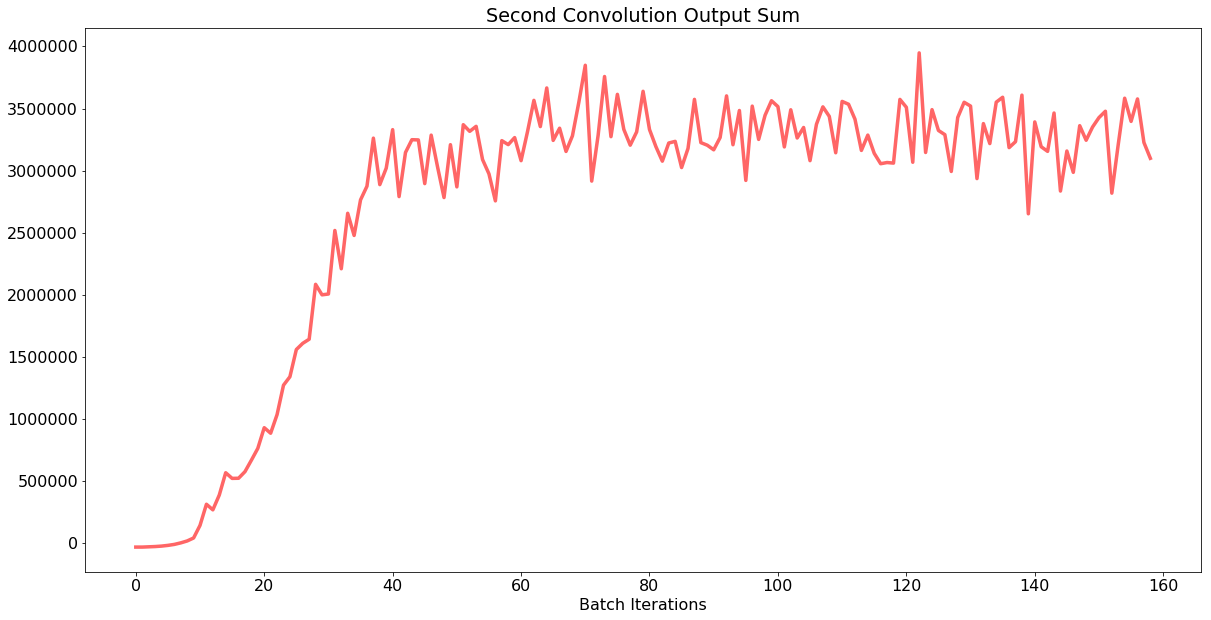

Plotting the second relu output sum


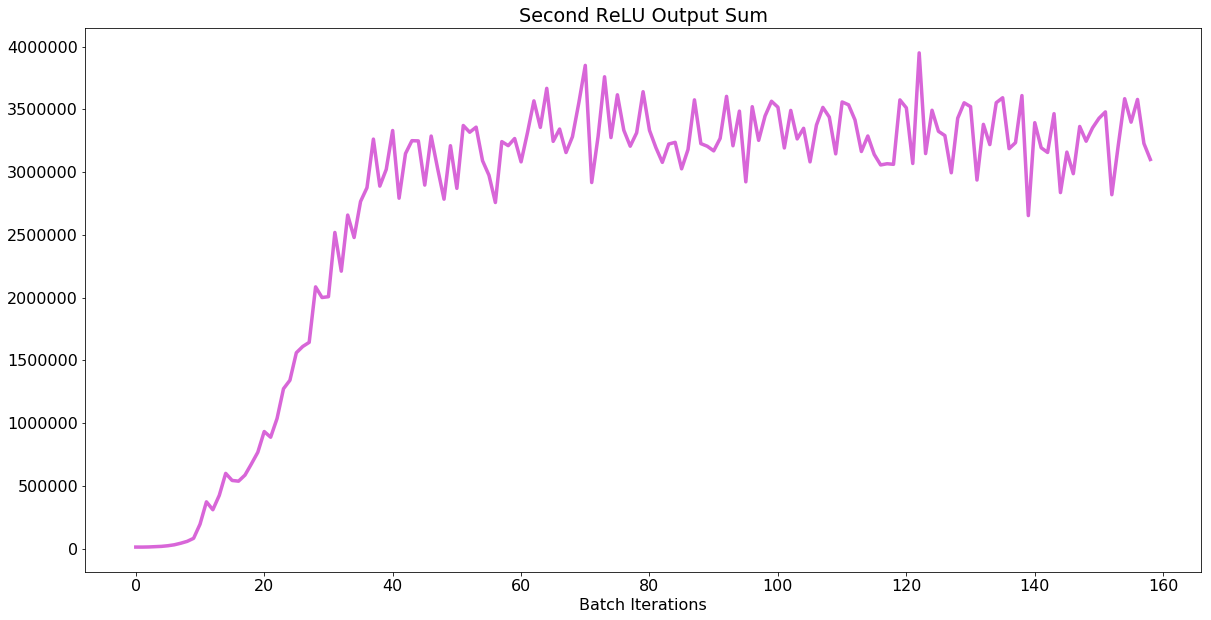

Plotting the second max unpool output sum


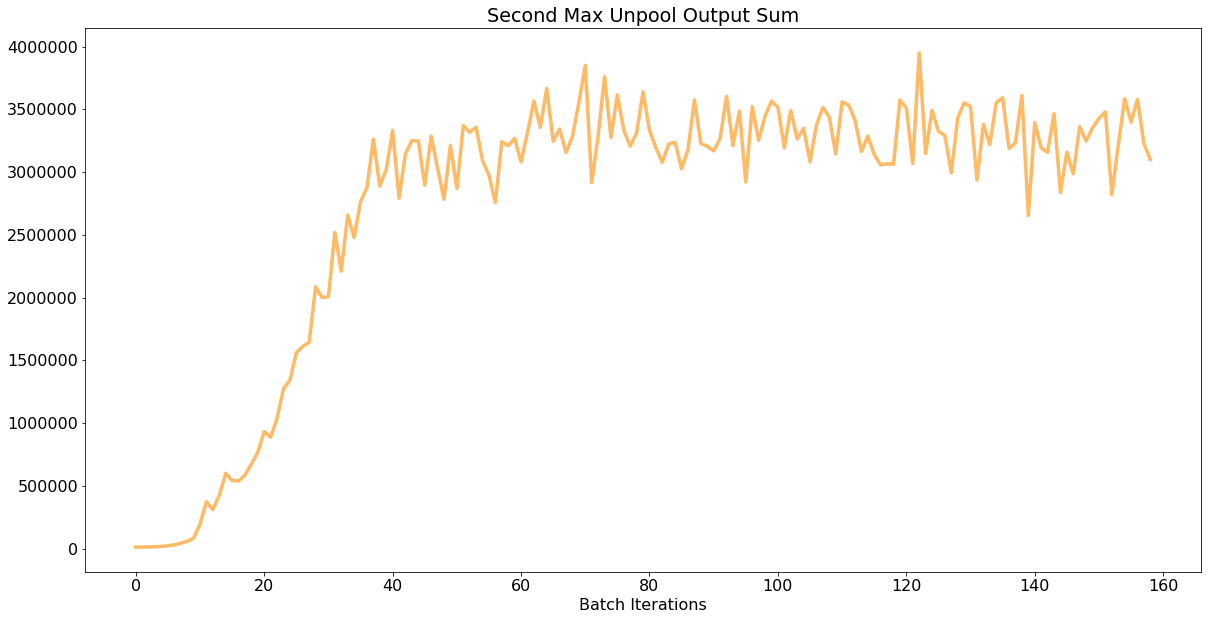

Plotting the third convolution output sum


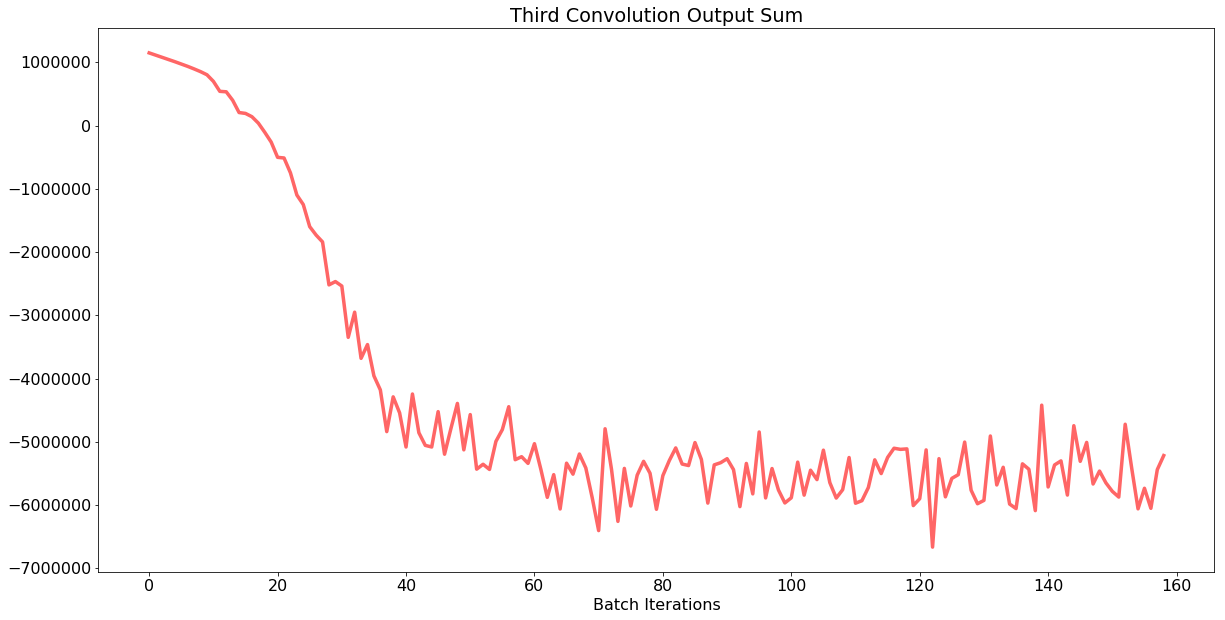

Plotting the third relu output sum


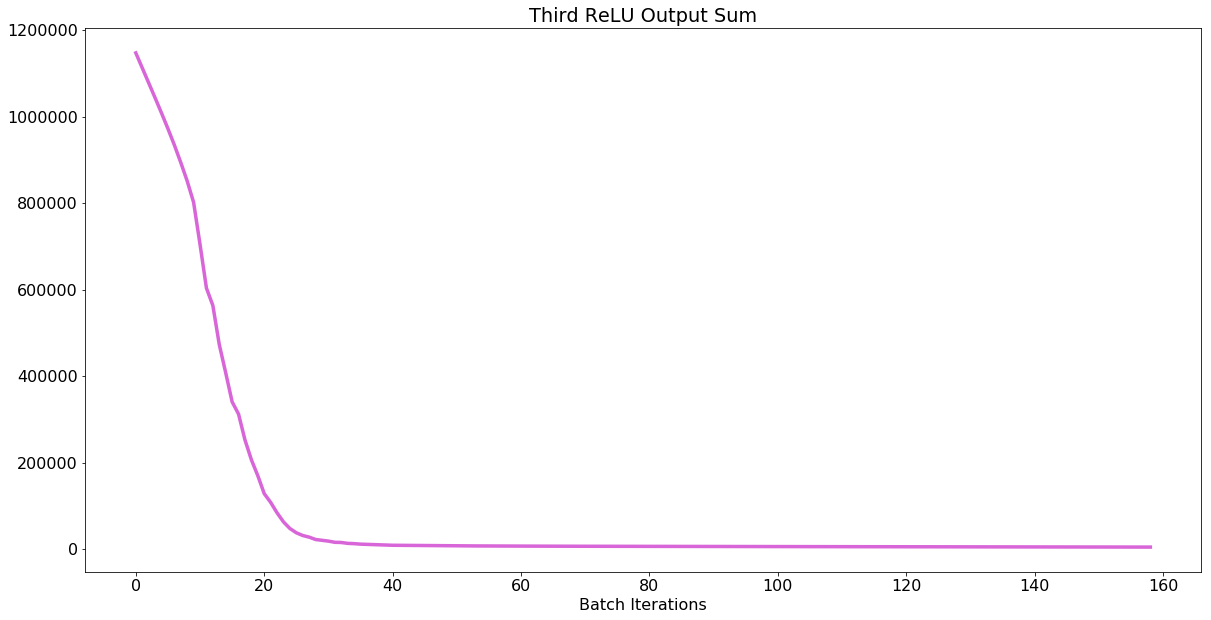

reconstructed cube = torch.Size([16, 128, 128, 128])
reconstructed cube = torch.Size([128, 128, 128])
MSE Loss = tensor(31.2372, device='cuda:0', grad_fn=<MseLossBackward>)
KLD Loss = tensor(0.1410, device='cuda:0', grad_fn=<DivBackward0>)
Train Epoch: 1 [208/256 (81%)]	Loss: 1.961140394211
Data transfer to device completed.
Starting Encoding
torch.Size([16, 2048])
Encode - Forward Pass Finished
torch.Size([16, 16])
torch.Size([16, 16])
Starting Decoding
FIRST DECODE OUT SUM = 23576.734
CONV 1 OUT SUM = 344717.44
RELU 1 OUT SUM = 344717.44
MAX UNPOOL 1 OUT SUM = 344717.44
CONV 2 OUT SUM = 3167533.0
RELU 2 OUT SUM = 3168862.2
MAX UNPOOL 2 OUT SUM = 3168864.5
CONV 3 OUT SUM = -5336370.0
RELU 3 OUT SUM = 5015.5566
data shape = torch.Size([16, 128, 128, 128])
data shape = (128, 128, 128)
Plotting the first decoder output sum
first decoder out sum = [2896.9578, 2894.755, 3238.6477, 3808.3076, 3741.1228, 4201.9287, 4773.0415, 5594.073, 6045.5674, 6948.961, 14237.286, 22334.652, 15180.516, 17

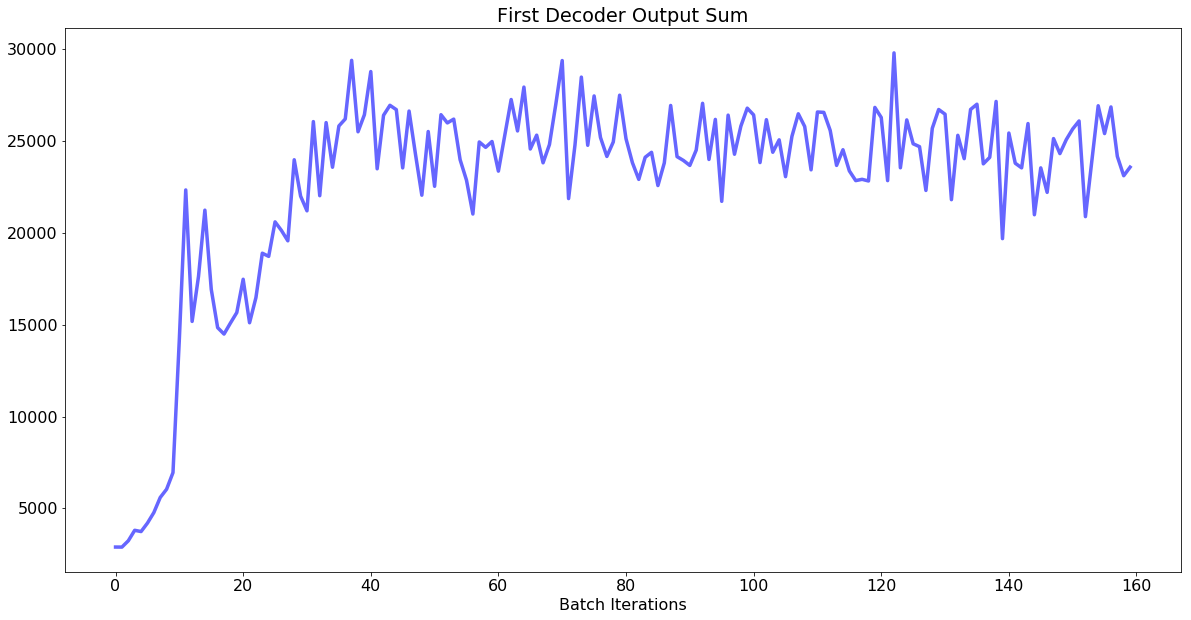

Plotting the first convolution output sum


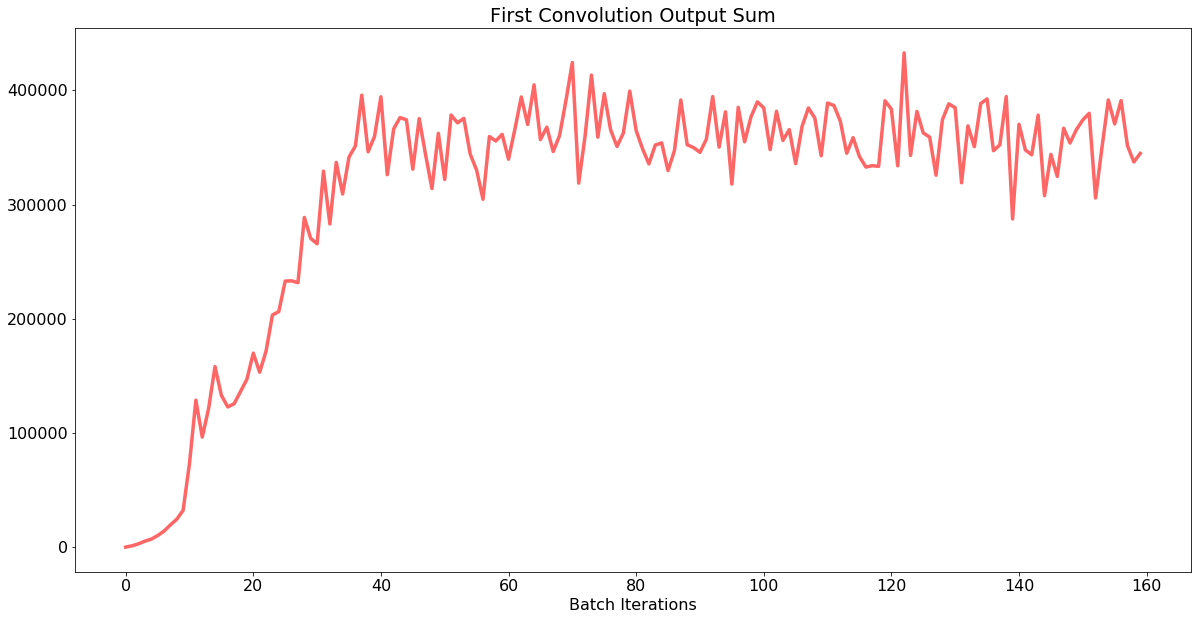

Plotting the first relu output sum


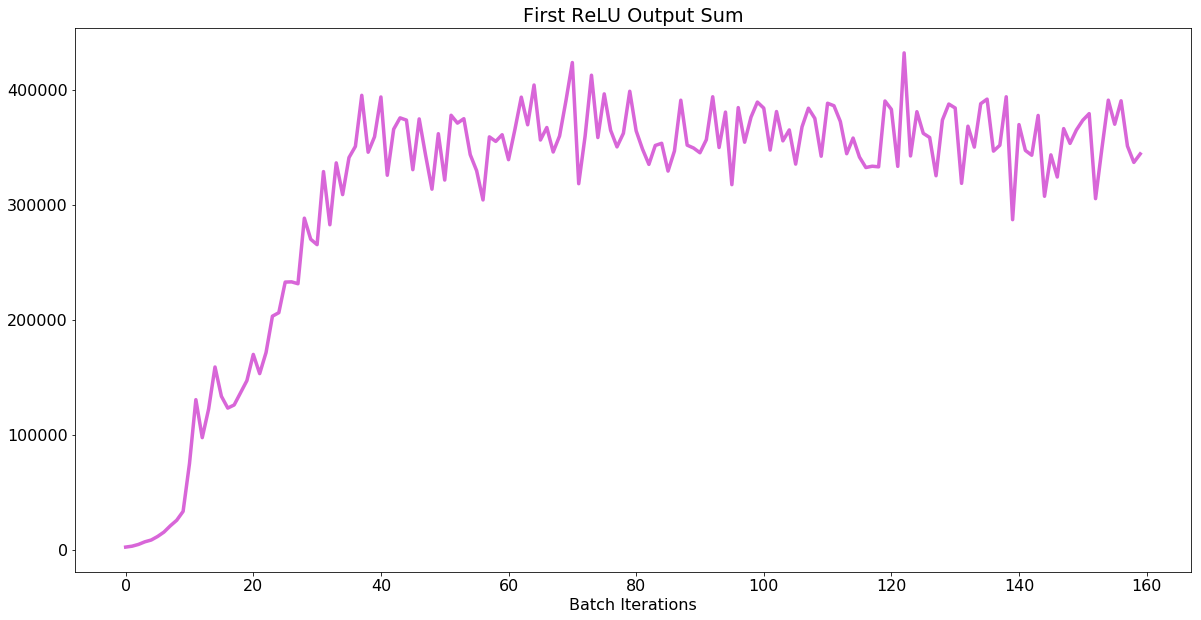

Plotting the first max unpool output sum


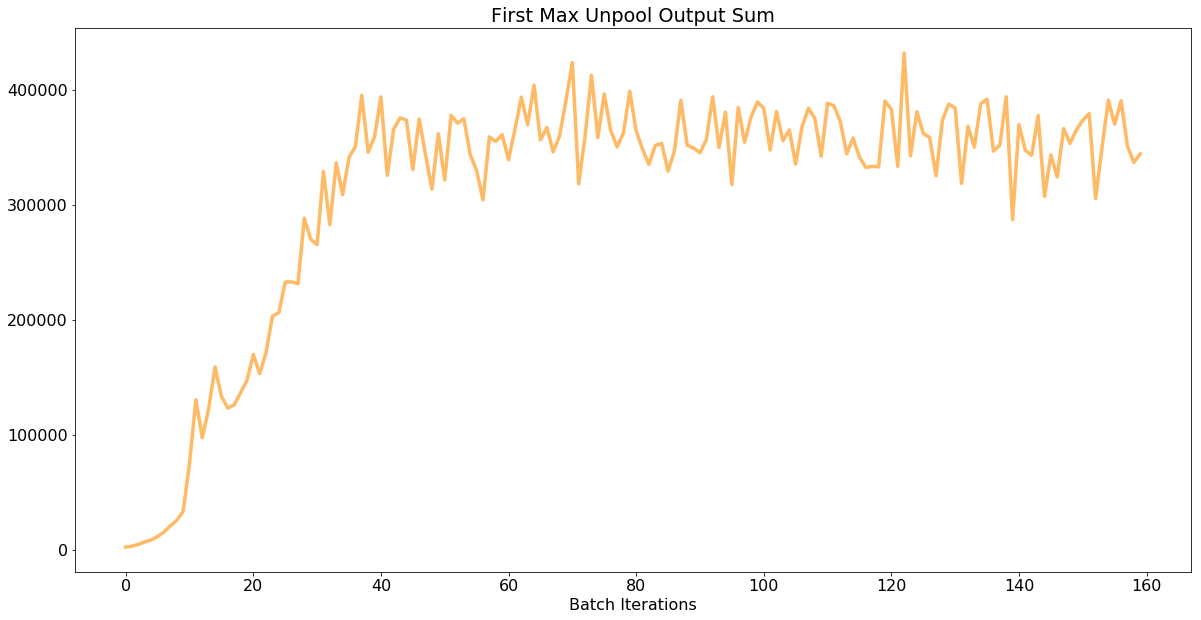

Plotting the second convolution output sum


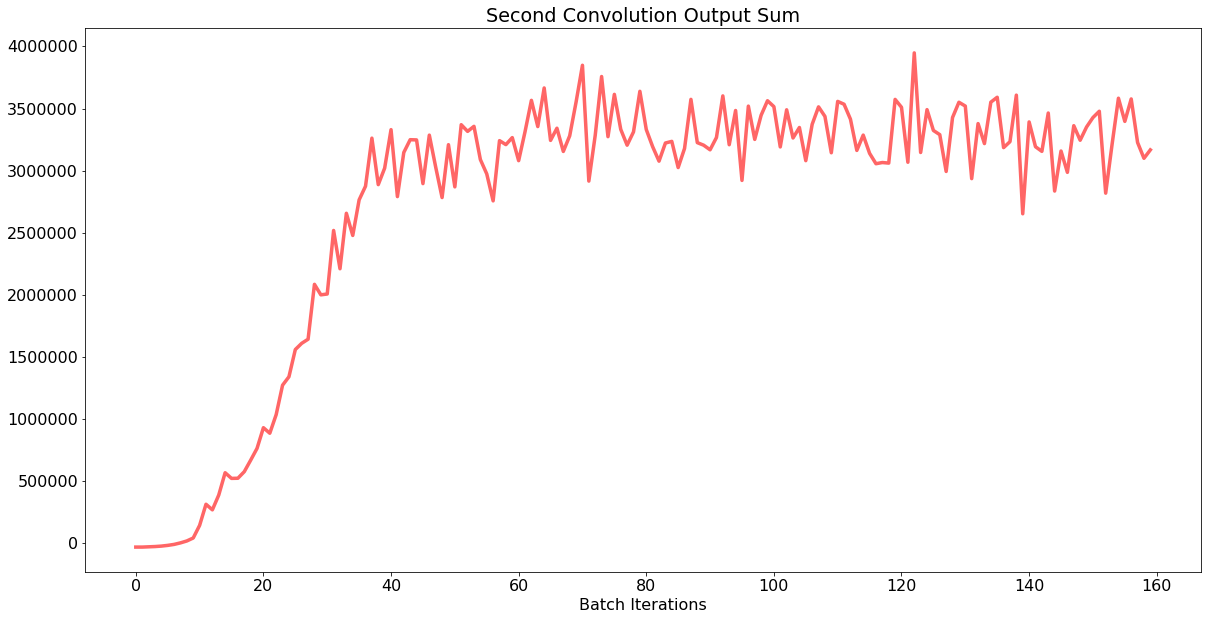

Plotting the second relu output sum


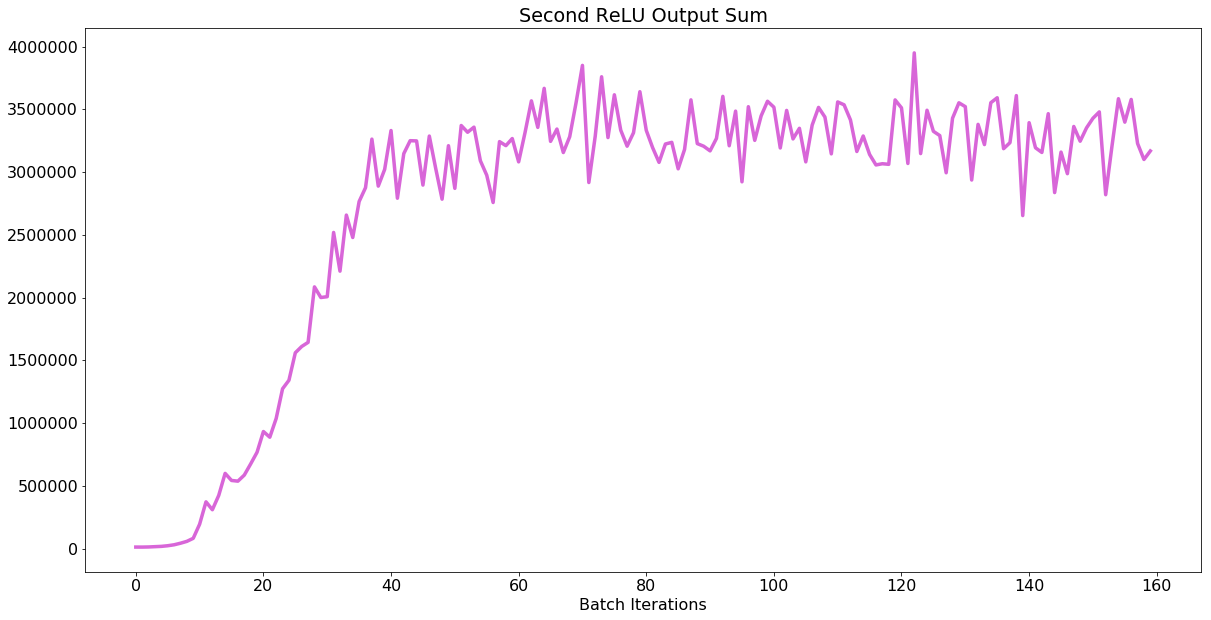

Plotting the second max unpool output sum


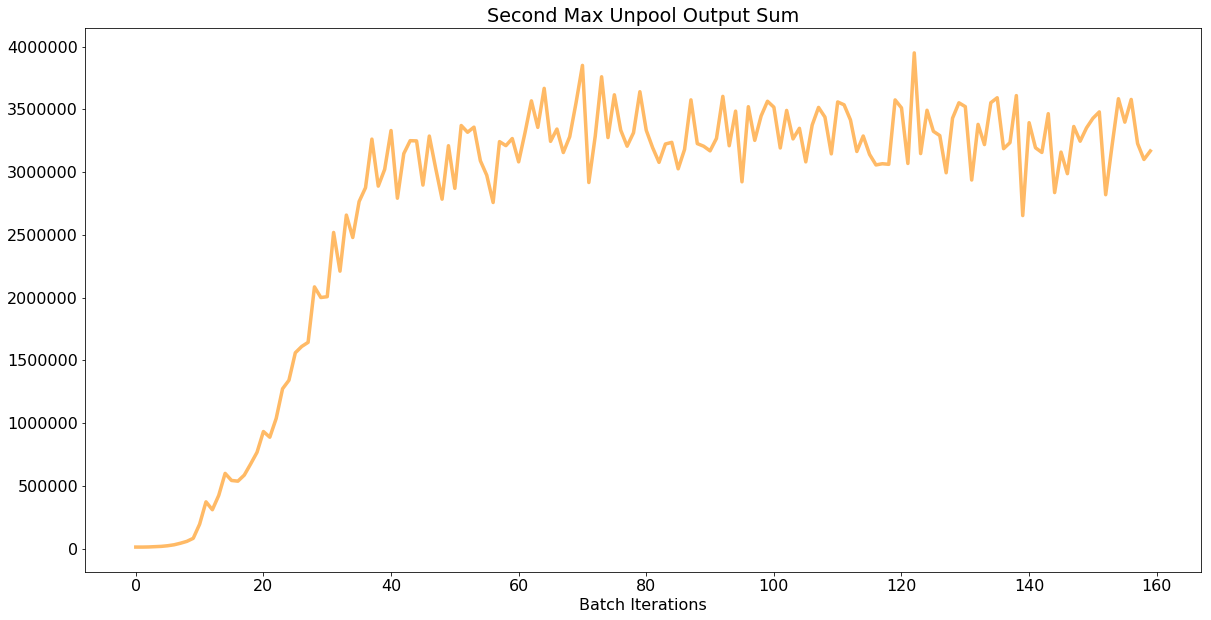

Process Process-254:


Plotting the third convolution output sum


Traceback (most recent call last):
  File "/share/apps/python3/3.6.3/intel/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/share/apps/python3/3.6.3/intel/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/adc563/pytorch-cpu/py3.6.3/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 96, in _worker_loop
    r = index_queue.get(timeout=MANAGER_STATUS_CHECK_INTERVAL)
  File "/share/apps/python3/3.6.3/intel/lib/python3.6/multiprocessing/queues.py", line 104, in get
    if not self._poll(timeout):
  File "/share/apps/python3/3.6.3/intel/lib/python3.6/multiprocessing/connection.py", line 257, in poll
    return self._poll(timeout)
  File "/share/apps/python3/3.6.3/intel/lib/python3.6/multiprocessing/connection.py", line 414, in _poll
    r = wait([self], timeout)
  File "/share/apps/python3/3.6.3/intel/lib/python3.6/multiprocessing/connection.py", line 911, in wait
   

KeyboardInterrupt: 

In [133]:
if __name__ == "__main__":
    
    loss_history = []
    
    decoder_sum_lists = {}
        
    for out_plot in ["first_decode_out_sum", "conv_1_out_sum", "relu_1_out_sum", "max_unpool_1_out_sum",
                    "conv_2_out_sum", "relu_2_out_sum", "max_unpool_2_out_sum", "conv_3_out_sum", \
                    "relu_3_out_sum"]:
            
        decoder_sum_lists[out_plot] = []
            
    #for epoch in range(1, args.epochs + 1):
    for epoch in range(1, epochs + 1):
        print("Epoch = " + str(epoch) + " / " + str(epochs))
        
        train(epoch)
        
        # Plotting Training Losses
        plt.figure(figsize=(20,10))
#         plt.ylim(-0.0001,0.7)
        plt.plot(loss_history, linewidth=3.5, alpha=0.6,
                color="crimson", marker="o")
        plt.show()
        

#         test(epoch)
        
        
#         with torch.no_grad():
#             sample = torch.randn(64, 20).to(device)
#             sample = model.decode(sample).cpu()
#             save_image(sample.view(64, 1, 28, 28),
#                        'results/sample_' + str(epoch) + '.png')